<a href="https://colab.research.google.com/github/gabrielxcosta/PCC142---Data-Mining/blob/main/Project/data_mining_Gabriel__London_Underground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.9 MB/s eta 0:00:00


In [93]:
# Built-in libraries
import os
import re
import json
import zipfile
import copy
import pickle as pk
import warnings

# Data manipulation and analysis
import numpy as np
import pandas as pd
import geopandas as gpd

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgb, ListedColormap
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Geometry and geospatial operations
from shapely.geometry import Point, LineString, box

# Graphs and networks
import networkx as nx

# Machine learning and preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Input  # Caso esteja usando Model funcional do Keras
from keras.models import Model  # Caso esteja usando Model funcional do Keras

# Time series modeling
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Other utilities
import sys
import time
import kagglehub
from scipy import stats
from scipy.stats import wilcoxon
from fuzzywuzzy import fuzz, process

# Warnings configuration
warnings.filterwarnings("ignore")

In [ ]:
path = kagglehub.dataset_download("jonbown/london-tube-station-usage")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/london-tube-station-usage


In [ ]:
os.listdir(path)

['2011_Entry_Exit.csv',
 '2010_Entry_Exit.csv',
 '2008_Entry_Exit.csv',
 '2013_Entry_Exit.csv',
 '2012_Entry_Exit.csv',
 '2007_Entry_Exit.csv',
 '2009_Entry_Exit.csv',
 '2014_Entry_Exit.csv',
 'stations.json',
 '2016_Entry_Exit.csv',
 '2017_Entry_Exit.csv',
 '2015_Entry_Exit.csv']

# Aluno: Gabriel F. Costa - PCC142 (Mineração de Dados) - Prof. Anderson Almeida Ferreira

## Dataset - London Underground Station Usage

Este dataset do Kaggle fornece informações sobre o uso das estações do metrô de Londres (**London Underground**), com dados de entrada e saída de passageiros por estação. As contagens são fornecidas separadamente para dias úteis, sábados e domingos, além de um valor total anual estimado de uso por estação.

### Importante sobre as Contagens:

As colunas de entrada e saída **não representam totais anuais**, mas sim **valores típicos para um único dia** de operação. Para estimar os totais anuais, é utilizado o seguinte peso:

- **Dias úteis**: 253
- **Sábados**: 52
- **Domingos**: 59  
*(Pressupõe 364 dias no ano, tratando 7 feriados como domingos e excluindo o Natal)

O total anual estimado é calculado como:


$\text{Total Anual} = (Entry\_Week + Exit\_Week) \times 253 + (Entry\_Saturday + Exit\_Saturday) \times 52 + (Entry\_Sunday + Exit\_Sunday) \times 59$

> Observação: A soma total de entradas e saídas em todo o sistema **não é igual** devido a variações na coleta dos dados, dias diferentes de contagem e inclusão eventual de passageiros de serviços ferroviários nacionais (NR).

---

### Coluna de Observações (`Note`):

Esta coluna indica anomalias nos dados de algumas estações:

- **N**: Estação fechada
- **T**: Os números incluem todos os passageiros da linha W&C (que fica fechada aos domingos)
- **B**: Os números para Bank/Monument agora excluem passageiros da linha W&C em transferência
- **A**: Contagens do ano anterior ajustadas pela variação média por zona

---

### Colunas do Dataset:

| Coluna                       | Descrição                                                                 | Tipo            |
|-----------------------------|---------------------------------------------------------------------------|-----------------|
| **nlc**                     | ID da estação (código numérico)                                          | `object`        |
| **Station Name**            | Nome da estação                                                          | `object`        |
| **Borough**                 | Nome do bairro ou região onde a estação está localizada                  | `object`        |
| **Note**                    | Observações sobre a contagem de dados                                    | `object`        |
| **Entry_Week**              | Total típico de entradas em um dia útil                                  | `float64`       |
| **Entry_Saturday**          | Total típico de entradas em um sábado                                    | `float64`       |
| **Entry_Sunday**            | Total típico de entradas em um domingo                                   | `float64`       |
| **Exit_Week**               | Total típico de saídas em um dia útil                                    | `float64`       |
| **Exit_Saturday**           | Total típico de saídas em um sábado                                      | `float64`       |
| **Exit_Sunday**             | Total típico de saídas em um domingo                                     | `float64`       |
| **AnnualEntryExit_Mill**    | Total anual estimado de entradas + saídas (em milhões)                   | `float64`       |
| **date**                    | Ano da contagem (em formato de período anual)                            | `period[Y-DEC]` |
| **Entry_Week_norm**         | Entrada em dia útil, normalizada (escala comparativa entre estações)     | `float64`       |
| **Exit_Week_norm**          | Saída em dia útil, normalizada                                           | `float64`       |
| **AnnualEntryExit_Mill_norm** | Total anual de fluxo, normalizado                                      | `float64`       |
| **Total_Weekday**           | Soma de entradas e saídas em dias úteis                                  | `float64`       |
| **Total_Weekend**           | Soma de entradas e saídas no fim de semana                               | `float64`       |
| **Ratio_Weekend_Weekday**   | Razão entre o fluxo de fim de semana e dias úteis                        | `float64`       |
| **year**                    | Ano extraído da coluna `date`                                            | `int64`         |
| **lat**                     | Latitude da estação                                                      | `float64`       |
| **lon**                     | Longitude da estação                                                     | `float64`       |
| **geometry**                | Geometria do ponto geográfico (latitude, longitude)                      | `geometry`      |
| **msoa21cd**                | Código da área estatística (MSOA 2021)                                   | `object`        |
| **msoa21nm**                | Nome da área estatística (MSOA 2021)                                     | `object`        |
| **lad22cd**                 | Código do distrito administrativo local (LAD 2022)                       | `object`        |
| **lad22nm**                 | Nome do distrito administrativo local (LAD 2022)                         | `object`        |

### Arquivo Geoespacial (Complementar)

Um segundo arquivo JSON é fornecido com coordenadas geográficas para visualização em mapas. Ele contém três chaves principais:

- **stations**: Nomes das estações e suas coordenadas (latitude e longitude)
- **lines**: Geometria das linhas do metrô (ex: Central, District, etc.)
- **river**: Traçado do rio Tâmisa (Thames)

Esse arquivo é útil para criar mapas estilizados no estilo clássico do metrô de Londres.

> Obs.: Os dados foram atualizados apenas até 2017. Assim que a TFL (Transport for London) disponibilizar dados mais recentes, o autor pretende atualizá-los no Kaggle.

# **Fase 1 - Pré-processamento e transformação**

## Agrupando os dados anuais

In [ ]:
files = os.listdir(path)
pattern = re.compile(r'(\d{4})_Entry_Exit\.csv')
df_list = []

for filename in files:
    match = pattern.match(filename)
    if match:
        year = int(match.group(1))
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path)
        df['date'] = pd.Period(f'{year}', freq='Y')
        df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)
full_df

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,date,Borough,Unnamed: 11
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,2011,NaN,NaN
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,2011,NaN,NaN
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,2011,NaN,NaN
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,2011,NaN,NaN
4,506,Amersham,,3461.0,1496.0,975.0,3775.0,1582.0,869.0,2.100000,2011,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,2015,Merton,NaN
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,2015,Haringey,NaN
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,2015,Hammersmith and Fulham,NaN
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,2015,Redbridge,NaN


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   nlc                   2955 non-null   object       
 1   Station               2953 non-null   object       
 2   Note                  2242 non-null   object       
 3   Entry_Week            2953 non-null   float64      
 4   Entry_Saturday        2953 non-null   float64      
 5   Entry_Sunday          2953 non-null   float64      
 6   Exit_Week             2953 non-null   float64      
 7   Exit_Saturday         2953 non-null   float64      
 8   Exit_Sunday           2953 non-null   float64      
 9   AnnualEntryExit_Mill  2952 non-null   float64      
 10  date                  2955 non-null   period[Y-DEC]
 11  Borough               1072 non-null   object       
 12  Unnamed: 11           0 non-null      float64      
dtypes: float64(8), object(4), period[

## Análise descritiva e pré-processamento

### Estatísticas descritivas básicas


In [ ]:
full_df.describe(include='all')  # Inclui estatísticas para colunas não numéricas

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,date,Borough,Unnamed: 11
count,2955.0,2953,2242,2953.000000,2953.000000,2953.000000,2953.000000,2953.000000,2953.00000,2952.000000,2955,1072,0.0
unique,544.0,883,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,31,NaN
top,771.0,Heathrow Terminals 123,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,City of Westminster,NaN
freq,9.0,10,1888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,124,NaN
mean,NaN,NaN,NaN,15832.458517,11222.802235,7556.190992,15585.829311,10913.880461,7354.04276,128.599217,NaN,NaN,NaN
std,NaN,NaN,NaN,21455.326175,16397.478007,11101.870239,21794.432258,16570.054653,10968.99336,656.292805,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,4482.000000,2835.000000,1846.000000,4203.000000,2583.000000,1753.00000,2.930000,NaN,NaN,NaN
50%,NaN,NaN,NaN,8453.000000,5625.000000,3805.000000,8099.000000,5227.000000,3610.00000,5.816754,NaN,NaN,NaN
75%,NaN,NaN,NaN,18038.000000,11736.000000,8406.000000,17574.000000,10864.000000,8045.00000,15.060000,NaN,NaN,NaN


### Verificar valores ausentes por coluna e imputar

In [ ]:
full_df.isnull().sum()

,0
nlc,0
Station,2
Note,713
Entry_Week,2
Entry_Saturday,2
Entry_Sunday,2
Exit_Week,2
Exit_Saturday,2
Exit_Sunday,2
AnnualEntryExit_Mill,3


#### IterativeImputer

> Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

O **`IterativeImputer`** do `scikit-learn` é uma técnica de imputação de valores ausentes baseada em modelos preditivos. Ele preenche os valores ausentes de forma iterativa, tratando cada coluna com valores faltantes como uma variável a ser prevista usando as outras colunas como variáveis independentes.

#### Como funciona?

1. Inicializa os valores ausentes com um valor (como a média).
2. Para cada coluna com valores ausentes, utiliza um modelo (como regressão) para prever os valores ausentes com base nas outras colunas.
3. O processo é repetido várias vezes para melhorar a imputação.

### Vantagens

- Mais preciso que métodos simples (média/mediana).
- Refina a imputação em várias iterações.

In [ ]:
full_df['Note'] = full_df['Note'].fillna('Normal')  # Preenche valores nulos na coluna 'Note' com o valor 'Normal'
full_df['Station'] = full_df['Station'].fillna('Desconhecida')  # Preenche valores nulos na coluna 'Station' com 'Desconhecida'

# Instanciando o IterativeImputer
iter_imputer = IterativeImputer(max_iter=1000, random_state=0)

# Imputando valores nas colunas numéricas
full_df[['Entry_Week', 'Entry_Saturday', 'Entry_Sunday', 'Exit_Week', 'Exit_Saturday', 'Exit_Sunday', 'AnnualEntryExit_Mill']] = iter_imputer.fit_transform(
    full_df[['Entry_Week', 'Entry_Saturday', 'Entry_Sunday', 'Exit_Week', 'Exit_Saturday', 'Exit_Sunday', 'AnnualEntryExit_Mill']]
)

full_df = full_df.drop(columns=['Unnamed: 11'])  # Remove a coluna 'Unnamed: 11', pois ela não contém dados úteis

# Confirmar
full_df.isnull().sum()

,0
nlc,0
Station,0
Note,0
Entry_Week,0
Entry_Saturday,0
Entry_Sunday,0
Exit_Week,0
Exit_Saturday,0
Exit_Sunday,0
AnnualEntryExit_Mill,0


#### Como imputar `Borough` usando scraping?

Uma abordagem possível para preencher os valores ausentes na coluna `Borough` é usar **web scraping** com `BeautifulSoup` e `requests`, consultando páginas da Wikipedia. A ideia é:

1. **Criar uma string de busca** combinando o nome da estação com `'station borough'`.
2. **Pesquisar no Google ou diretamente na Wikipedia** usando esse nome.
3. **Rastrear o HTML da página** da estação correspondente.
4. **Extrair o nome do borough** a partir da infobox ou do texto da introdução.
5. **Atualizar a coluna `Borough` no DataFrame** com o valor obtido.

> ⚠️ Importante: Esse processo deve respeitar as regras de uso dos sites e pode exigir tratamento de exceções, limites de requisição e ajustes manuais.

Como alternativa automatizada e mais robusta, também é possível usar APIs como a do OpenStreetMap (Nominatim) ou consultar dados geográficos oficiais do Transport for London (TfL).


### Distribuição das entradas e saídas semanais de cada ano

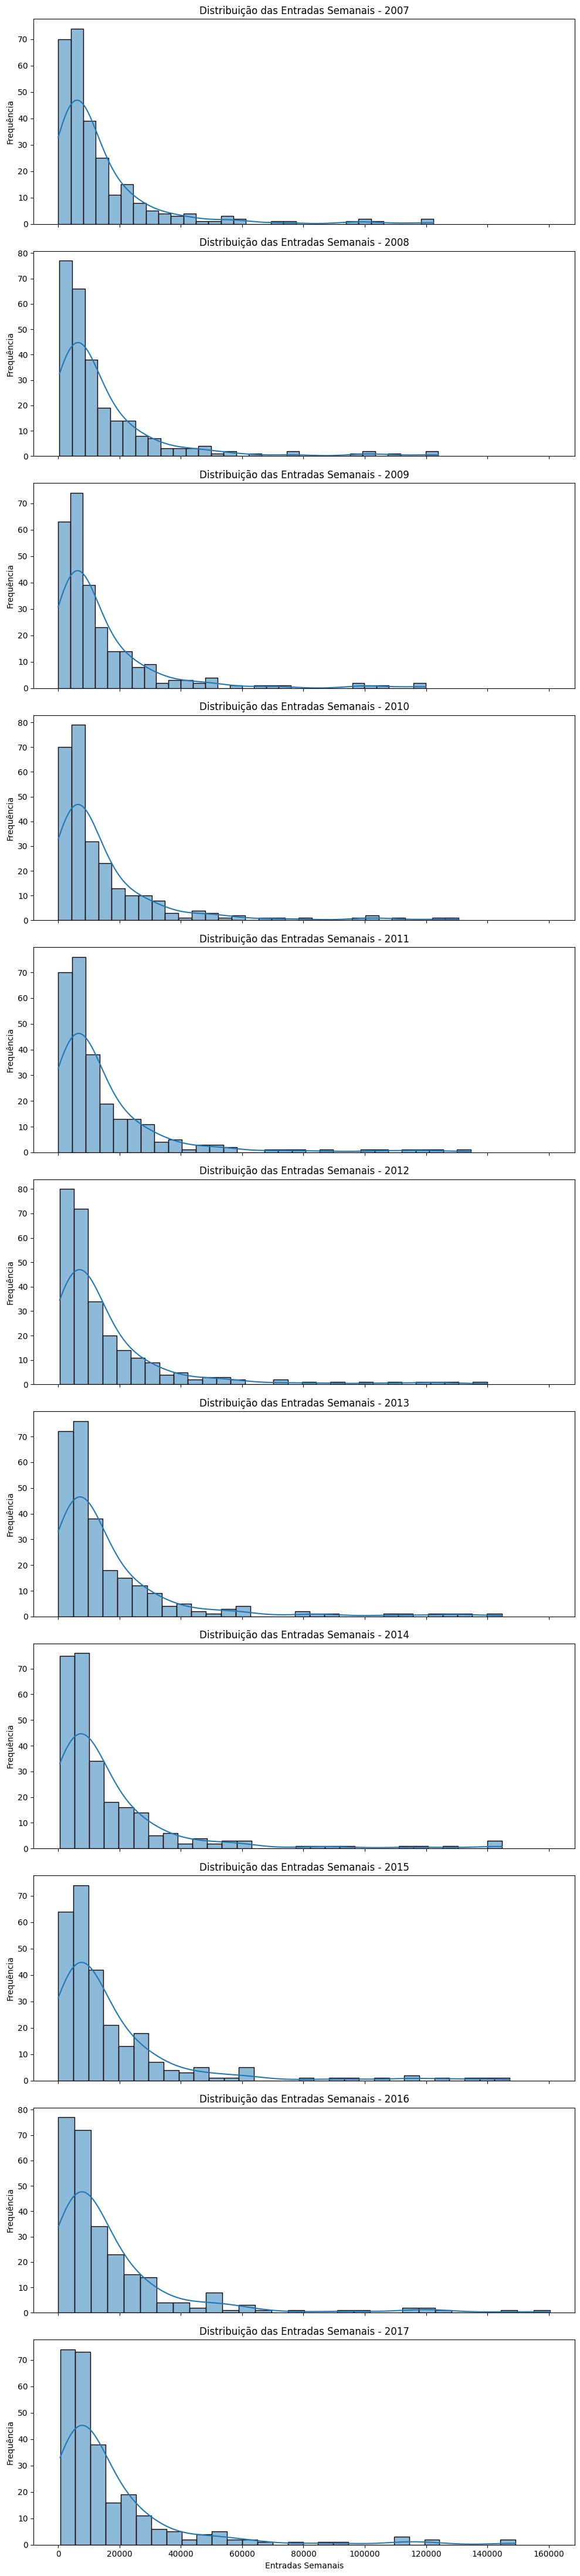

In [ ]:
years = sorted(full_df['date'].unique())
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(10, 4 * n_years), sharex=True)

for i, year in enumerate(years):
    sns.histplot(full_df[full_df['date'] == year]['Entry_Week'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição das Entradas Semanais - {year}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequência')

axes[-1].set_xlabel('Entradas Semanais')
plt.tight_layout()
plt.show()

### Top 10 estações com maior movimento anual

In [ ]:
top_stations = full_df.sort_values(by='AnnualEntryExit_Mill', ascending=False).head(10)
print(top_stations[['Station', 'AnnualEntryExit_Mill']])

                       Station  AnnualEntryExit_Mill
2547  King's Cross St. Pancras              12208.11
2663                  Waterloo              10569.46
2588             Oxford Circus              10417.31
2658                  Victoria               9727.26
2558             London Bridge               8204.75
2637                 Stratford               8112.43
2557          Liverpool Street               7652.50
2430           Bank & Monument               6171.74
2589                Paddington               5776.20
2455              Canary Wharf               5537.58


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   nlc                   2955 non-null   object       
 1   Station               2955 non-null   object       
 2   Note                  2955 non-null   object       
 3   Entry_Week            2955 non-null   float64      
 4   Entry_Saturday        2955 non-null   float64      
 5   Entry_Sunday          2955 non-null   float64      
 6   Exit_Week             2955 non-null   float64      
 7   Exit_Saturday         2955 non-null   float64      
 8   Exit_Sunday           2955 non-null   float64      
 9   AnnualEntryExit_Mill  2955 non-null   float64      
 10  date                  2955 non-null   period[Y-DEC]
 11  Borough               1072 non-null   object       
dtypes: float64(7), object(4), period[Y-DEC](1)
memory usage: 277.2+ KB


### Correlação entre as variáveis

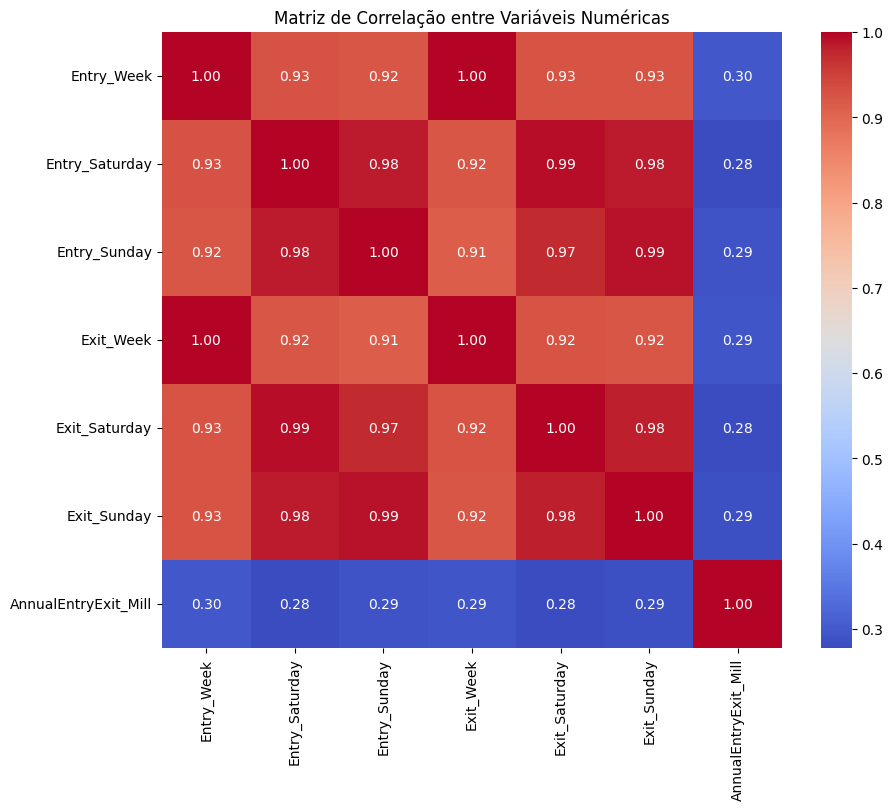

In [ ]:
# Matriz de correlação
correlation_matrix = full_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

### Boxplots

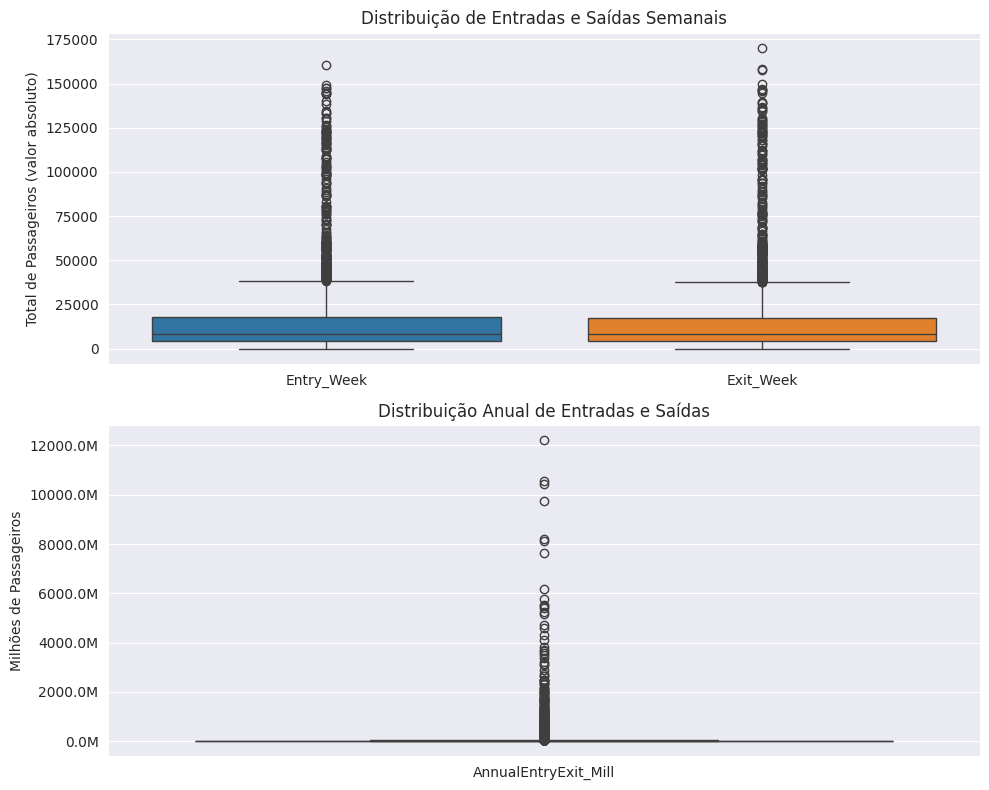

In [ ]:
# Estilo
sns.set_style('darkgrid')

# Criar figura e subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Boxplot para Entry_Week e Exit_Week
sns.boxplot(data=full_df[['Entry_Week', 'Exit_Week']], ax=axes[0])
axes[0].set_title('Distribuição de Entradas e Saídas Semanais')
axes[0].set_ylabel('Total de Passageiros (valor absoluto)')

# Boxplot para AnnualEntryExit_Mill com escala formatada em milhões
sns.boxplot(data=full_df[['AnnualEntryExit_Mill']], ax=axes[1])
axes[1].set_title('Distribuição Anual de Entradas e Saídas')
axes[1].set_ylabel('Milhões de Passageiros')
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}M'))

# Ajustar layout
plt.tight_layout()

# Salvar imagem
plt.savefig('boxplots.pdf')
plt.show()

#### Análise dos boxplots

Os boxplots mostram a distribuição dos valores de movimento de passageiros nas estações do metrô de Londres em diferentes períodos:

##### 1. Boxplot Superior: Entradas e Saídas Semanais (Dias Úteis)
- **Eixo X**:
  - `Entry_Week`: Entradas em dias úteis
  - `Exit_Week`: Saídas em dias úteis
- **Eixo Y**: Total de passageiros (valores absolutos por dia), escala até 175.000 passageiros
- **Interpretação**:
  - Mostra a distribuição do número diário típico de passageiros em dias úteis
  - A mediana (linha no meio da caixa) parece estar em torno de 25.000-50.000 passageiros
  - Há vários outliers (pontos acima do bigode superior) indicando estações extremamente movimentadas

##### 2. Boxplot Inferior: Total Anual de Entradas e Saídas
- **Eixo X**: `AnnualEntryExit_Mill` (Total anual estimado em milhões)
- **Eixo Y**: Milhões de passageiros, escala até 12.000M (12 bilhões)
- **Interpretação**:
  - Mostra a distribuição do movimento anual estimado (soma de entradas e saídas)
  - A mediana parece estar abaixo de 2.000 milhões (2 bilhões)
  - Há outliers extremos chegando a 12.000 milhões (12 bilhões), o que provavelmente representa as estações mais movimentadas como King's Cross ou Waterloo

##### Grande variação entre estações - algumas têm movimento muito maior que outras
2. **Assimetria** nos dados - a maioria das estações tem valores moderados, mas poucas têm valores extremamente altos
3. **Padrão similar** entre entradas e saídas em dias úteis
4. **Escala anual** mostra o impacto cumulativo das estações mais movimentadas

Estes boxplots ajudam a visualizar a desigualdade no uso das estações, com poucas estações concentrando a maior parte do movimento de passageiros.

### Normalizando entradas/saídas

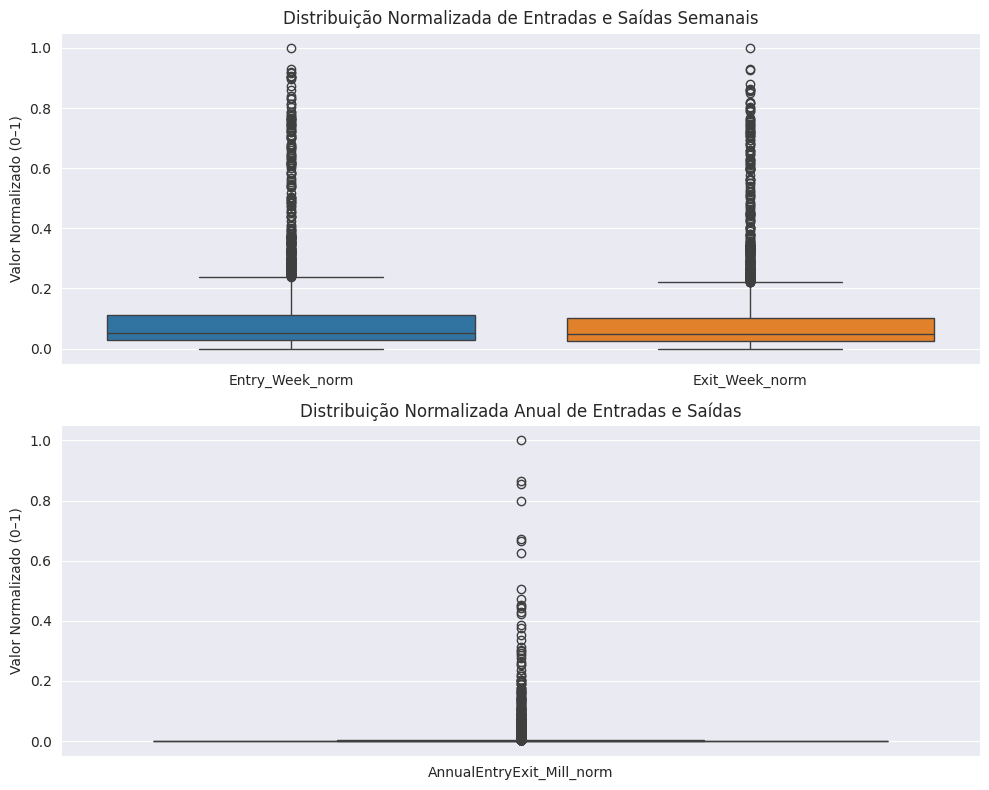

In [ ]:
# Normalizar colunas selecionadas
scaler = MinMaxScaler()
cols_to_normalize = ['Entry_Week', 'Exit_Week', 'AnnualEntryExit_Mill']
normalized_data = scaler.fit_transform(full_df[cols_to_normalize])
normalized_df = pd.DataFrame(normalized_data, columns=[f'{col}_norm' for col in cols_to_normalize])

# Adicionar colunas normalizadas ao full_df
full_df = pd.concat([full_df, normalized_df], axis=1)

# Estilo
sns.set_style('darkgrid')

# Criar figura e subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Boxplot para entradas e saídas semanais normalizadas
sns.boxplot(data=full_df[['Entry_Week_norm', 'Exit_Week_norm']], ax=axes[0])
axes[0].set_title('Distribuição Normalizada de Entradas e Saídas Semanais')
axes[0].set_ylabel('Valor Normalizado (0–1)')

# Boxplot para total anual normalizado
sns.boxplot(data=full_df[['AnnualEntryExit_Mill_norm']], ax=axes[1])
axes[1].set_title('Distribuição Normalizada Anual de Entradas e Saídas')
axes[1].set_ylabel('Valor Normalizado (0–1)')

# Ajustar layout e salvar
plt.tight_layout()
plt.savefig('boxplots_normalizados.pdf')
plt.show()

A decisão de remover ou manter os outliers neste contexto requer uma análise cuidadosa dos seus objetivos com a GNN (Graph Neural Network). Vamos examinar os prós e contras:

### **Por que manter?**
1. **Representam a realidade operacional**:
   - Estações como King's Cross, Waterloo ou Victoria realmente têm fluxos muito superiores à média
   - Removê-los artificialmente equalizaria um sistema que é naturalmente assimétrico

2. **Impacto na topologia da rede**:
   - Esses hubs são nós críticos na rede de transporte
   - Sua remoção distorceria a representação de conectividade e fluxos de transferência

3. **Aprendizado robusto**:
   - Uma GNN exposta à distribuição real pode aprender padrões hierárquicos (hubs vs. estações periféricas)
   - Útil para aplicações como previsão de congestionamentos ou otimização de rotas

### **Argumentos para REMOVER/ATENUAR outliers**:
1. **Dominância no aprendizado**:
   - Valores extremos podem fazer a GNN "esquecer" padrões das estações medianas
   - Risco de o modelo se especializar apenas nos hubs principais

2. **Normalização alternativa**:
   - Transformações logarítmicas ou winsorization (ex.: limitar valores ao percentil 99) podem suavizar o impacto sem perder informação

3. **Cenários específicos**:
   - Se o foco for estações "comuns" (ex.: análise de bairros residenciais), a remoção pode ser justificável

### **Recomendações práticas**:
1. **Experimente ambas abordagens**:
   - Treine a GNN com e sem outliers e compare o desempenho

2. **Técnicas intermediárias**:
   - **Cap values**: Substituir valores acima do percentil 95 pela mediana do top 5%
   - **Embeddings separados**: Tratar hubs como uma categoria especial (ex.: adicionar feature binária "is_hub")

3. **Arquitetura adaptativa**:
   - Usar attention mechanisms para que a GNN aprenda a ponderar automaticamente nós com diferentes escalas

4. **Validação temática**:
   - Verifique se a remoção prejudica casos de uso reais (ex.: o modelo ainda consegue prever fluxos em estações turísticas?)

### **Exemplo de abordagem híbrida** (Python/pseudo-código):
```python
# Opção 1: Winsorization
from scipy.stats.mstats import winsorize
df['AnnualEntryExit_Mill'] = winsorize(df['AnnualEntryExit_Mill'], limits=[0.01, 0.01])

# Opção 2: Transformação logarítmica
df['log_annual'] = np.log1p(df['AnnualEntryExit_Mill'])

# Opção 3: Feature binária para hubs
df['is_hub'] = (df['AnnualEntryExit_Mill'] > threshold).astype(int)
```

### **Conclusão**:
Para capturar a "maior realidade possível", **manter os outliers é geralmente preferível**, mas com adaptações:
- Use normalização por quantis em vez de min-max
- Adicione mecanismos na arquitetura da GNN para lidar com a heterogeneidade (ex.: normalização de nós por grau)
- Considere camadas de atenção que automaticamente ajustem a importância relativa dos nós

A assimetria é uma característica intrínseca de redes de transporte, e uma GNN que a incorpore tende a gerar insights mais úteis para aplicações reais.

### Conversão de tipos e feature engineering

In [ ]:
# Conversão para tipo categórico
full_df['nlc'] = full_df['nlc'].astype('category')
full_df['Station'] = full_df['Station'].astype('category')
full_df['Note'] = full_df['Note'].astype('category')

In [ ]:
# Total de uso em dias de semana
full_df['Total_Weekday'] = full_df['Entry_Week'] + full_df['Exit_Week']

# Total de uso no fim de semana (sábado + domingo)
full_df['Total_Weekend'] = (
    full_df['Entry_Saturday'] + full_df['Exit_Saturday'] +
    full_df['Entry_Sunday'] + full_df['Exit_Sunday']
)

# Razão entre uso no fim de semana e nos dias úteis
full_df['Ratio_Weekend_Weekday'] = full_df['Total_Weekend'] / full_df['Total_Weekday']

In [ ]:
full_df['date'].unique()

<PeriodArray>
['2011', '2010', '2008', '2013', '2012', '2007', '2009', '2014', '2016',
 '2017', '2015']
Length: 11, dtype: period[Y-DEC]

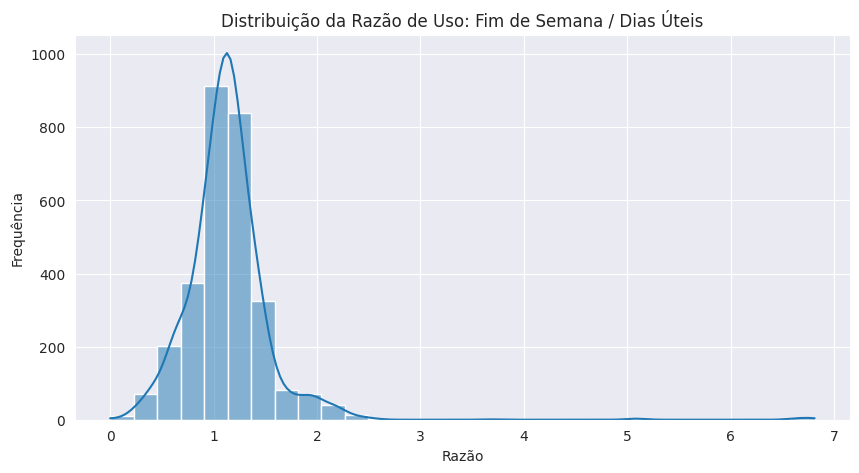

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(full_df['Ratio_Weekend_Weekday'], bins=30, kde=True)
plt.title('Distribuição da Razão de Uso: Fim de Semana / Dias Úteis')
plt.xlabel('Razão')
plt.ylabel('Frequência')
plt.show()

### Gráficos temporais agregando por ano

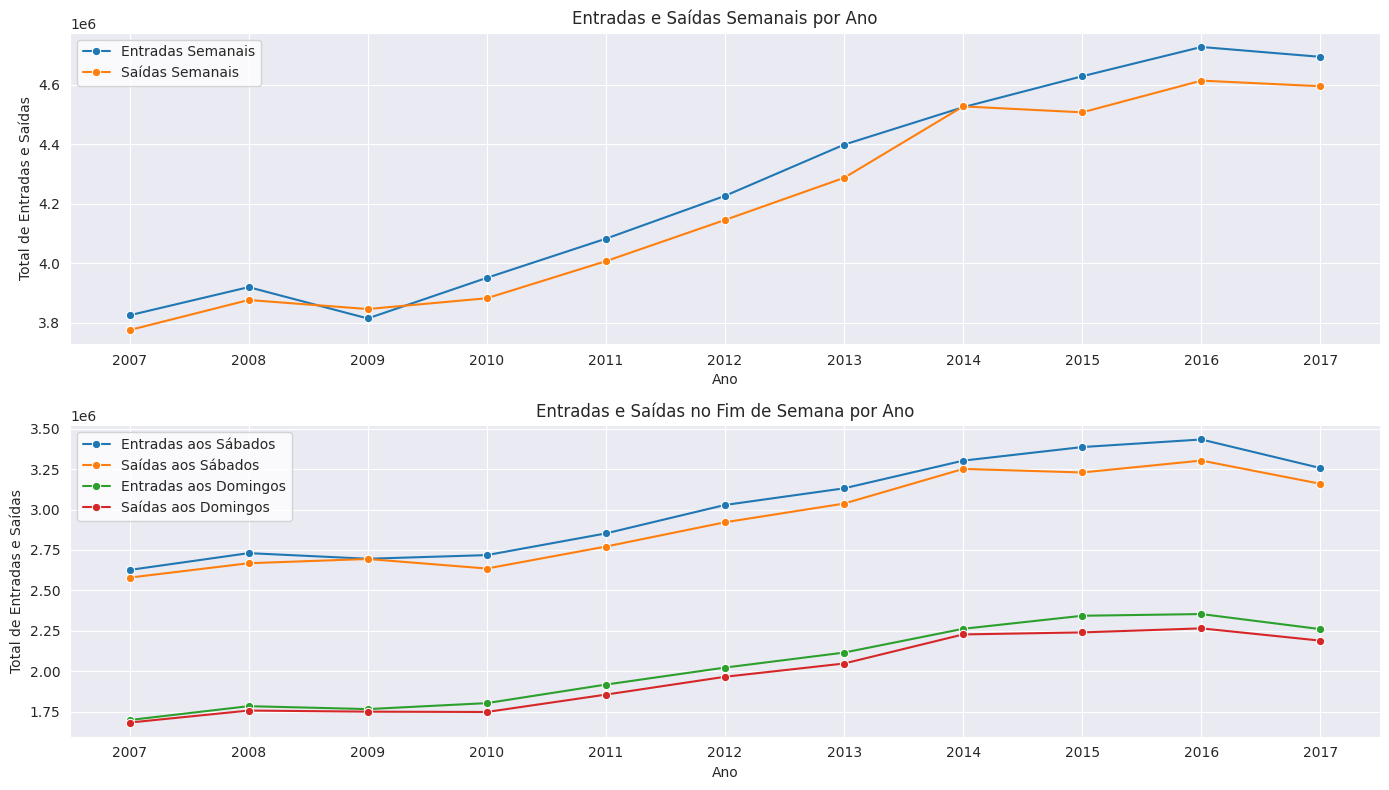

In [ ]:
# Agregar os dados por ano (somando as entradas e saídas)
full_df['year'] = full_df['date'].dt.year

# Agregar por ano e somar as entradas e saídas
annual_data = full_df.groupby('year').agg({
    'Entry_Week': 'sum',
    'Entry_Saturday': 'sum',
    'Entry_Sunday': 'sum',
    'Exit_Week': 'sum',
    'Exit_Saturday': 'sum',
    'Exit_Sunday': 'sum',
    'AnnualEntryExit_Mill': 'sum'
}).reset_index()

# Estilo do gráfico
sns.set_style('darkgrid')

# Criar figura para os gráficos
plt.figure(figsize=(14, 8))

# Gráfico de Entradas e Saídas Semanais por Ano
plt.subplot(2, 1, 1)
sns.lineplot(data=annual_data, x='year', y='Entry_Week', label='Entradas Semanais', marker='o')
sns.lineplot(data=annual_data, x='year', y='Exit_Week', label='Saídas Semanais', marker='o')
plt.title('Entradas e Saídas Semanais por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Entradas e Saídas')
plt.legend(facecolor='white')

# Definindo os ticks do eixo X para 2007 a 2017
plt.xticks(ticks=range(2007, 2018))

# Gráfico de Entradas e Saídas Totais por Ano
plt.subplot(2, 1, 2)
sns.lineplot(data=annual_data, x='year', y='Entry_Saturday', label='Entradas aos Sábados', marker='o')
sns.lineplot(data=annual_data, x='year', y='Exit_Saturday', label='Saídas aos Sábados', marker='o')
sns.lineplot(data=annual_data, x='year', y='Entry_Sunday', label='Entradas aos Domingos', marker='o')
sns.lineplot(data=annual_data, x='year', y='Exit_Sunday', label='Saídas aos Domingos', marker='o')
plt.title('Entradas e Saídas no Fim de Semana por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Entradas e Saídas')
plt.legend(facecolor='white')

# Definindo os ticks do eixo X para 2007 a 2017
plt.xticks(ticks=range(2007, 2018))

# Exibir os gráficos
plt.tight_layout()
plt.show()

## Futuro: incluir dados geográficos + grafo

In [ ]:
!wget -O LB_MSOA2021_shp.zip https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/LB_MSOA2021_shp.zip

--2025-07-04 17:41:05--  https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/LB_MSOA2021_shp.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/LB_MSOA2021_shp.zip [following]
--2025-07-04 17:41:06--  https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/LB_MSOA2021_shp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960034 (8.5M) [application/zip]
Saving to: ‘LB_MSOA2021_shp.zip’

LB_MSOA2021_shp.zip 100%[===================>]   8.54M  --.-KB/s    in 0.03s   

2025-07-04 17:41:06 (339 MB/s) - ‘L

In [ ]:
# Caminho para o arquivo ZIP
zip_path = '/content/LB_MSOA2021_shp.zip'

# Abre o arquivo ZIP e extrai tudo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print(f"Arquivos extraídos...")

Arquivos extraídos...


In [ ]:
# Caminho do arquivo JSON
stations_file = path + "/stations.json"

# Carregar o JSON
with open(stations_file, "r", encoding="utf-8") as file:
    data = json.load(file)

# Extração dos dados das estações
stations = data.get("stations", {})

# Transformar os dados no formato adequado para um DataFrame
stations_list = []
for station_id, details in stations.items():
    if "position" in details:
        stations_list.append({
            "station_id": station_id,
            "title": details.get("title", ""),
            "text": details.get("text", ""),
            "lat": details["position"]["lat"],
            "lon": details["position"]["lon"],
            "zone": details.get("zone", None)
        })

station_df = pd.DataFrame(stations_list)

In [ ]:
station_df

,station_id,title,text,lat,lon,zone
0,ActonTown,Acton Town,Acton \nTown,51.502500,-0.278126,3
1,Aldgate,Aldgate,Aldgate,51.513940,-0.075370,1
2,AldgateEast,Aldgate East,Aldgate \nEast,51.515140,-0.071780,1
3,Alperton,Alperton,Alperton,51.540970,-0.300610,4
4,Amersham,Amersham,Amersham,51.674350,-0.607320,9
...,...,...,...,...,...,...
261,WimbledonPark,Wimbledon Park,Wimbledon Park,51.433910,-0.198640,3
262,WoodGreen,Wood Green,Wood Green,51.597090,-0.109390,3
263,WoodLane,Wood Lane,Wood \nLane,51.597090,-0.109390,2
264,Woodford,Woodford,Woodford,51.605820,0.033280,4


In [ ]:
# Fuzzy matching entre nomes de estação
unique_stations = full_df['Station'].unique()
json_titles = station_df['title'].tolist()

matches = []
for station in unique_stations:
    best_match, score = process.extractOne(station, json_titles)
    matches.append({
        "Station": station,
        "matched_title": best_match,
        "match_score": score
    })

matches_df = pd.DataFrame(matches)

# Agora juntar lat, lon e zone usando matched_title (do JSON)
matches_with_info = matches_df.merge(
    station_df[['title', 'lat', 'lon', 'zone']],
    left_on='matched_title', right_on='title',
    how='left'
)

# Juntar isso ao full_df usando o nome original da estação
full_df_with_zone = full_df.merge(
    matches_with_info[['Station', 'lat', 'lon', 'zone']],
    on='Station',
    how='left'
)

# Criar geometria com lat/lon
geometry = [Point(xy) for xy in zip(full_df_with_zone['lon'], full_df_with_zone['lat'])]

# Criar GeoDataFrame final com a nova coluna zone incluída
full_gdf_final = gpd.GeoDataFrame(full_df_with_zone, geometry=geometry, crs='EPSG:4326')

# Verificar resultado
print(full_gdf_final[['Station', 'lat', 'lon', 'zone', 'geometry']].head())

                               Station       lat       lon  zone  \
0  Acton Town                           51.50250 -0.278126     3   
1  Aldgate                              51.51394 -0.075370     1   
2  Aldgate East                         51.51514 -0.071780     1   
3  Alperton                             51.54097 -0.300610     4   
4  Amersham                             51.67435 -0.607320     9   

                    geometry  
0   POINT (-0.27813 51.5025)  
1  POINT (-0.07537 51.51394)  
2  POINT (-0.07178 51.51514)  
3  POINT (-0.30061 51.54097)  
4  POINT (-0.60732 51.67435)  


In [ ]:
matches_df

,Station,matched_title,match_score
0,Acton Town,Acton Town,100
1,Aldgate,Aldgate,100
2,Aldgate East,Aldgate East,100
3,Alperton,Alperton,100
4,Amersham,Amersham,100
...,...,...,...
879,West Kensington,West Kensington,100
880,Westbourne Park,Westbourne Park,100
881,Willesden Green,Willesden Green,100
882,Willesden Junction,Willesden Junction,100


In [ ]:
full_gdf_final

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,...,Exit_Week_norm,AnnualEntryExit_Mill_norm,Total_Weekday,Total_Weekend,Ratio_Weekend_Weekday,year,lat,lon,zone,geometry
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,...,0.049305,0.000447,17094.0,20741.0,1.213350,2011,51.502500,-0.278126,3,POINT (-0.27813 51.5025)
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,...,0.064152,0.000511,22238.0,11043.0,0.496582,2011,51.513940,-0.075370,1,POINT (-0.07537 51.51394)
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,...,0.082001,0.000750,29002.0,32883.0,1.133818,2011,51.515140,-0.071780,1,POINT (-0.07178 51.51514)
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,...,0.027408,0.000242,9143.0,11513.0,1.259215,2011,51.540970,-0.300610,4,POINT (-0.30061 51.54097)
4,506,Amersham,,3461.0,1496.0,975.0,3775.0,1582.0,869.0,2.100000,...,0.022179,0.000172,7236.0,4922.0,0.680210,2011,51.674350,-0.607320,9,POINT (-0.60732 51.67435)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,...,0.014876,0.000149,5825.0,6345.0,1.089270,2015,51.433910,-0.198640,3,POINT (-0.19864 51.43391)
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,...,0.111524,0.001080,39263.0,59325.0,1.510965,2015,51.597090,-0.109390,3,POINT (-0.10939 51.59709)
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,...,0.035704,0.000303,11534.0,14355.0,1.244581,2015,51.597090,-0.109390,2,POINT (-0.10939 51.59709)
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,...,0.055703,0.000494,19118.0,21887.0,1.144837,2015,51.605820,0.033280,4,POINT (0.03328 51.60582)


In [ ]:
# Caminho para a pasta onde estão os arquivos
folder_path = "/content/msoa2021"

# Lista de todos os arquivos .shp
shp_files = [f for f in os.listdir(folder_path) if f.endswith(".shp")]

# Lista para armazenar os GeoDataFrames
gdfs = []

# Ler todos os .shp e armazenar na lista
for shp_file in shp_files:
    full_path = os.path.join(folder_path, shp_file)
    try:
        gdf = gpd.read_file(full_path)
        gdfs.append(gdf)
    except Exception as e:
        print(f"Erro ao ler {shp_file}: {e}")

# Combinar todos os mapas num único GeoDataFrame
map_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Garantir que o CRS dos pontos (gdf/full_gdf_final) está no mesmo CRS do mapa
if gdf.crs != map_gdf.crs:
    gdf = gdf.to_crs(map_gdf.crs)
    full_gdf_final = full_gdf_final.to_crs(map_gdf.crs)

#  Garantir que CRS seja o mesmo
if full_gdf_final.crs != map_gdf.crs:
    full_gdf_final = full_gdf_final.to_crs(map_gdf.crs)

# 2. Unir geometria do mapa com método atualizado
map_union = map_gdf.union_all()

# 3. Filtrar apenas estações dentro do mapa
stations_within_map = full_gdf_final[full_gdf_final.geometry.within(map_union)]

In [ ]:
full_gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype        
---  ------                     --------------  -----        
 0   nlc                        2955 non-null   category     
 1   Station                    2955 non-null   object       
 2   Note                       2955 non-null   category     
 3   Entry_Week                 2955 non-null   float64      
 4   Entry_Saturday             2955 non-null   float64      
 5   Entry_Sunday               2955 non-null   float64      
 6   Exit_Week                  2955 non-null   float64      
 7   Exit_Saturday              2955 non-null   float64      
 8   Exit_Sunday                2955 non-null   float64      
 9   AnnualEntryExit_Mill       2955 non-null   float64      
 10  date                       2955 non-null   period[Y-DEC]
 11  Borough                    1072 non-null   object       
 12  Entry_Week_n

In [ ]:
# Spatial join: associar cada estação ao distrito (bairro)
stations_with_msoa = gpd.sjoin(
    full_gdf_final, map_gdf, how="left", predicate="within"
)

# Preencher a coluna 'Borough' com base em 'lad22nm'
stations_with_msoa['Borough_inferred'] = stations_with_msoa['lad22nm']
stations_with_msoa['Borough'] = stations_with_msoa['Borough'].fillna(stations_with_msoa['Borough_inferred'])

# Limpar colunas temporárias
full_gdf_final = stations_with_msoa.drop(columns=['index_right', 'Borough_inferred'])

# Verificar quantos ainda ficaram nulos
print(full_gdf_final['Borough'].isna().sum())

135


In [ ]:
full_gdf_final['Borough'].isna().sum()

np.int64(135)

# **Fase 2 - Mineração de padrões frequentes**

**Descrição do GeoDataFrame resultante da Fase 1:**

Este `GeoDataFrame` contém **2737 entradas** e **26 colunas**, representando informações espaciais e temporais sobre estações, fluxo de passageiros e dados geográficos no contexto urbano.

## Estrutura

* **Tipo:** `GeoDataFrame`
* **Entradas:** 2737
* **Colunas:** 26

---

## Colunas

| Coluna                       | Descrição                                                                 | Tipo            |
|-----------------------------|---------------------------------------------------------------------------|-----------------|
| **nlc**                     | ID da estação (código numérico)                                          | `object`        |
| **Station Name**            | Nome da estação                                                          | `object`        |
| **Borough**                 | Nome do bairro ou região onde a estação está localizada                  | `object`        |
| **Note**                    | Observações sobre a contagem de dados                                    | `object`        |
| **Entry_Week**              | Total típico de entradas em um dia útil                                  | `float64`       |
| **Entry_Saturday**          | Total típico de entradas em um sábado                                    | `float64`       |
| **Entry_Sunday**            | Total típico de entradas em um domingo                                   | `float64`       |
| **Exit_Week**               | Total típico de saídas em um dia útil                                    | `float64`       |
| **Exit_Saturday**           | Total típico de saídas em um sábado                                      | `float64`       |
| **Exit_Sunday**             | Total típico de saídas em um domingo                                     | `float64`       |
| **AnnualEntryExit_Mill**    | Total anual estimado de entradas + saídas (em milhões)                   | `float64`       |
| **date**                    | Ano da contagem (em formato de período anual)                            | `period[Y-DEC]` |
| **Entry_Week_norm**         | Entrada em dia útil, normalizada (escala comparativa entre estações)     | `float64`       |
| **Exit_Week_norm**          | Saída em dia útil, normalizada                                           | `float64`       |
| **AnnualEntryExit_Mill_norm** | Total anual de fluxo, normalizado                                      | `float64`       |
| **Total_Weekday**           | Total de entradas e saídas em dias úteis                                  | `float64`       |
| **Total_Weekend**           | Total de entradas e saídas no fim de semana                               | `float64`       |
| **Ratio_Weekend_Weekday**   | Razão entre o fluxo de fim de semana e dias úteis                        | `float64`       |
| **year**                    | Ano extraído da coluna `date`                                            | `int64`         |
| **lat**                     | Latitude da estação                                                      | `float64`       |
| **lon**                     | Longitude da estação                                                     | `float64`       |
| **geometry**                | Geometria do ponto geográfico (latitude, longitude)                      | `geometry`      |
| **msoa21cd**                | Código da área estatística (MSOA 2021)                                   | `object`        |
| **msoa21nm**                | Nome da área estatística (MSOA 2021)                                     | `object`        |
| **lad22cd**                 | Código do distrito administrativo local (LAD 2022)                       | `object`        |
| **lad22nm**                 | Nome do distrito administrativo local (LAD 2022)                         | `object`        |

---

## Notas

* A presença da coluna `geometry` torna esse objeto um `GeoDataFrame`, permitindo operações espaciais com bibliotecas como `GeoPandas`.
* As colunas `lat` e `lon` também estão disponíveis para uso direto sem depender de `geometry`.
* As colunas normalizadas (`_norm`) são úteis para comparações relativas entre estações, independente da escala absoluta.
* MSOA é uma unidade geográfica de nível médio, utilizada no recenseamento populacional da Inglaterra e País de Gales, com uma população típica de 7.000-10.000 pessoas. É construída a partir de aglomerados de "Lower Layer Super Output Areas" (LSOA).

## Gerando visualizações da rede p/ o artigo

In [ ]:
!wget -O "London_Train_Lines.json" "https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/London%20Train%20Lines.json"
!wget -O "London_Stations.json" "https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/London%20stations.json"

--2025-07-04 17:41:20--  https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/London%20Train%20Lines.json
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/London%20Train%20Lines.json [following]
--2025-07-04 17:41:20--  https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/London%20Train%20Lines.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 682792 (667K) [text/plain]
Saving to: ‘London_Train_Lines.json’

London_Train_Lines. 100%[===================>] 666.79K  --.-KB/s    in 0.01s   

2025-07-04 17

In [ ]:
class LondonMetroGraph:
    """
    Class to build, clean, and visualize the London Metro/Rail Network as a NetworkX graph.

    Attributes:
        stations_gdf (GeoDataFrame): Geospatial data of the metro stations.
        rail_lines_gdf (GeoDataFrame): Geospatial data of the rail lines.
        full_gdf_final (GeoDataFrame): External dataset to be matched with the graph.
        zone_colors (dict): Dictionary mapping zones to colors.
        G (networkx.Graph): Graph of the metro network.
    """

    def __init__(self, stations_path, lines_path, full_gdf_final):
        """
        Initialize the LondonMetroGraph class.

        Args:
            stations_path (str): Path to the JSON file containing station data.
            lines_path (str): Path to the JSON file containing rail line data.
            full_gdf_final (GeoDataFrame): External dataset with station information to be matched.
        """
        self.stations_gdf = gpd.read_file(stations_path)
        self.rail_lines_gdf = gpd.read_file(lines_path)
        self.full_gdf_final = full_gdf_final.copy()
        self.zone_colors = {
            1: "#cc0000",
            2: "#ff7c00",
            3: "#ffdf00",
            4: "#c2ff00",
            5: "#5eff00",
            6: "#00ffff"
        }
        self.G = None

    def clean_name(self, name):
        """
        Clean and normalize station names.

        Args:
            name (str): Station name.

        Returns:
            str: Cleaned station name.
        """
        if not isinstance(name, str):
            return name
        return (
            name.lower().strip()
            .replace('&', 'and')
            .replace('-', ' ')
            .replace("'", '')
            .replace('.', '')
            .replace('  ', ' ')
        )

    def build_graph(self):
        """
        Build the metro network graph using proximity to rail lines to connect stations.
        """
        stations_proj = self.stations_gdf.to_crs(epsg=3857).copy()
        rail_lines_proj = self.rail_lines_gdf.to_crs(epsg=3857)

        stations_proj['color'] = stations_proj['zone'].astype(str).apply(self.fixed_zone_color)

        self.G = nx.Graph()
        for _, row in stations_proj.iterrows():
            self.G.add_node(row['name'], geometry=row.geometry, zone=row['zone'], color=row['color'])

        for line in rail_lines_proj.geometry:
            buffer = line.buffer(100)
            nearby = stations_proj[stations_proj.geometry.intersects(buffer)].copy()
            nearby['dist_along'] = nearby.geometry.apply(lambda p: line.project(p))
            nearby_sorted = nearby.sort_values(by='dist_along')
            names = nearby_sorted['name'].tolist()
            for i in range(len(names) - 1):
                if not self.G.has_edge(names[i], names[i + 1]):
                    self.G.add_edge(names[i], names[i + 1])

    def fixed_zone_color(self, zone_str):
        """
        Assign colors to stations based on their zone.

        Args:
            zone_str (str): Zone string.

        Returns:
            tuple: RGB color.
        """
        if not isinstance(zone_str, str) or zone_str.strip() == '':
            return (0.7, 0.7, 0.7)
        zones = [int(z.strip()) for z in zone_str.split(',') if z.strip().isdigit()]
        valid_zones = [z for z in zones if z in self.zone_colors]
        if valid_zones:
            return to_rgb(self.zone_colors[valid_zones[0]])
        return (0.7, 0.7, 0.7)

    def clean_and_match_full_gdf(self):
        """
        Clean station names and match them to the graph nodes using exact and fuzzy matching.
        """
        self.full_gdf_final['Station_clean'] = self.full_gdf_final['Station'].apply(self.clean_name)

        graph_station_names_clean = {self.clean_name(name): name for name in self.G.nodes}
        station_to_node_index = {self.clean_name(name): i for i, name in enumerate(self.G.nodes)}

        correcoes = {
            'bank and monument': 'bank',
            'edgware road (bak)': 'edgware road',
            'edgware road (cir)': 'edgware road',
            'shepherds bush (cen)': 'shepherds bush',
            'shepherds bush (handc)': 'shepherds bush',
            'heathrow terminals 123': 'heathrow terminals 2 and 3',
            'desconhecida': None
        }
        self.full_gdf_final['Station_clean'] = self.full_gdf_final['Station_clean'].replace(correcoes)
        self.full_gdf_final = self.full_gdf_final[self.full_gdf_final['Station_clean'].notna()].copy()

        self.full_gdf_final['node_index'] = self.full_gdf_final['Station_clean'].map(station_to_node_index)

        unmapped_mask = self.full_gdf_final['node_index'].isna()
        unmapped_stations = self.full_gdf_final.loc[unmapped_mask, 'Station_clean'].unique()

        graph_names_list = list(station_to_node_index.keys())
        mapped_names = {}
        for station in unmapped_stations:
            best_match = self.fuzzy_match_station(station, graph_names_list)
            mapped_names[station] = best_match

        self.full_gdf_final.loc[unmapped_mask, 'Station_clean_fuzzy'] = \
            self.full_gdf_final.loc[unmapped_mask, 'Station_clean'].apply(lambda x: mapped_names.get(x, x))

        self.full_gdf_final['final_station_name'] = self.full_gdf_final['Station_clean_fuzzy'].combine_first(
            self.full_gdf_final['Station_clean']
        )

        self.full_gdf_final['node_index'] = self.full_gdf_final['final_station_name'].map(station_to_node_index)
        self.full_gdf_final['Station'] = self.full_gdf_final['final_station_name']

        self.full_gdf_final = self.full_gdf_final.drop(columns=['Station_clean_fuzzy', 'final_station_name'])
        self.full_gdf_final.to_file('full_gdf_final_cleaned.geojson', driver='GeoJSON')

    def fuzzy_match_station(self, name, choices, threshold=80):
        """
        Perform fuzzy matching between a station name and graph node names.

        Args:
            name (str): Station name to match.
            choices (list): List of possible node names.
            threshold (int): Minimum score for fuzzy matching.

        Returns:
            str or None: Best matched station name or None if no match.
        """
        match, score = process.extractOne(name, choices)
        if score >= threshold:
            return match
        return None

    def plot_network(self, with_map=False, original=True):
        """
        Plot the metro network graph.

        Args:
            with_map (bool): Whether to plot com rail map background.
        """
        stations_proj = self.stations_gdf.to_crs(epsg=3857)
        rail_lines_proj = self.rail_lines_gdf.to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(14, 14))

        if with_map:
            rail_lines_proj.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5, zorder=0)

        for u, v in self.G.edges():
            p1 = self.G.nodes[u]['geometry']
            p2 = self.G.nodes[v]['geometry']
            line = LineString([p1, p2])
            ax.plot(*line.xy, color="skyblue", linewidth=1.2, alpha=0.6, zorder=1)

        for node, data in self.G.nodes(data=True):
            ax.plot(data['geometry'].x, data['geometry'].y, 'o',
                    markersize=10, color=data['color'],
                    markeredgecolor='white', markeredgewidth=1.3, zorder=2)

        legend_patches = [mpatches.Patch(color=self.zone_colors[z], label=f"Zone {z}") for z in self.zone_colors]
        legend_patches.append(mpatches.Patch(color='gray', label='Suburban or National Rail'))
        ax.legend(handles=legend_patches, title="Zones", loc='center left', bbox_to_anchor=(1, 0.5))

        if original:
          fig.suptitle("London Metro/Rail Network", fontsize=16, y=0.75)
        else:
          fig.suptitle("London Metro Network", fontsize=16, y=0.75)
        ax.set_axis_off()
        plt.tight_layout()

        minx, miny, maxx, maxy = stations_proj.total_bounds
        ax.set_xlim(minx - 5000, maxx + 5000)
        ax.set_ylim(miny - 5000, maxy + 5000)
        ax.set_aspect('equal')

        plt.show()

    def filter_graph_nodes_by_zones(self, allowed_zones={'1','2','3','4','5','6'}):
        G_filtered = self.G_original.copy()
        nodes_to_remove = [node for node, data in G_filtered.nodes(data=True)
                          if data.get('zone') not in allowed_zones]
        G_filtered.remove_nodes_from(nodes_to_remove)
        self.G_filtered = G_filtered
        print(f"Removed {len(nodes_to_remove)} nodes outside zones {allowed_zones} from the graph.")

    def rgb_tuple_to_hex(self, rgb):
        """
        Convert an RGB tuple (float 0-1) to hexadecimal color string (#RRGGBB).
        """
        return '#{:02x}{:02x}{:02x}'.format(
            int(rgb[0] * 255),
            int(rgb[1] * 255),
            int(rgb[2] * 255)
        )

    def prepare_graph_for_graphml(self, G):
        """
        Prepare a NetworkX graph for GraphML export by converting unsupported types.

        Args:
            G (networkx.Graph): The graph to prepare.

        Returns:
            networkx.Graph: A deep copy of the graph with cleaned attributes.
        """
        G_copy = copy.deepcopy(G)
        for node, data in G_copy.nodes(data=True):
            # Convert geometry to WKT string
            geom = data.get('geometry')
            if geom is not None:
                data['geometry'] = geom.wkt if hasattr(geom, 'wkt') else str(geom)

            # Convert color tuple to hex string
            color = data.get('color')
            if isinstance(color, tuple):
                data['color'] = self.rgb_tuple_to_hex(color)

            # Convert any remaining tuples to strings
            for key in list(data.keys()):
                if isinstance(data[key], tuple) and key != 'color':
                    data[key] = str(data[key])

        return G_copy

    def save_graph(self, path_graphml="london_metro_filtered.graphml", path_gexf=None):
        """
        Save the filtered graph in GraphML and optionally GEXF formats.

        Args:
            path_graphml (str): Path to save GraphML file.
            path_gexf (str, optional): Path to save GEXF file.
        """
        if self.G_filtered is None:
            raise ValueError("Filtered graph is not defined. Run filter_graph_nodes_by_zones first.")

        G_to_save = self.prepare_graph_for_graphml(self.G_filtered)
        nx.write_graphml(G_to_save, path_graphml)
        print(f"Graph saved to {path_graphml}")

        if path_gexf is not None:
            nx.write_gexf(G_to_save, path_gexf)
            print(f"Graph saved to {path_gexf}")

    def save_full_gdf_final(self, path_csv="full_gdf_final_filtered.csv"):
        """
        Save the filtered full_gdf_final GeoDataFrame with features and node indices as CSV,
        removing the geometry column to avoid warnings.

        Args:
            path_csv (str): File path to save CSV.
        """
        df_copy = self.full_gdf_final.copy()
        if 'geometry' in df_copy.columns:
            df_copy = df_copy.drop(columns=['geometry'])
        df_copy.to_csv(path_csv, index=False)

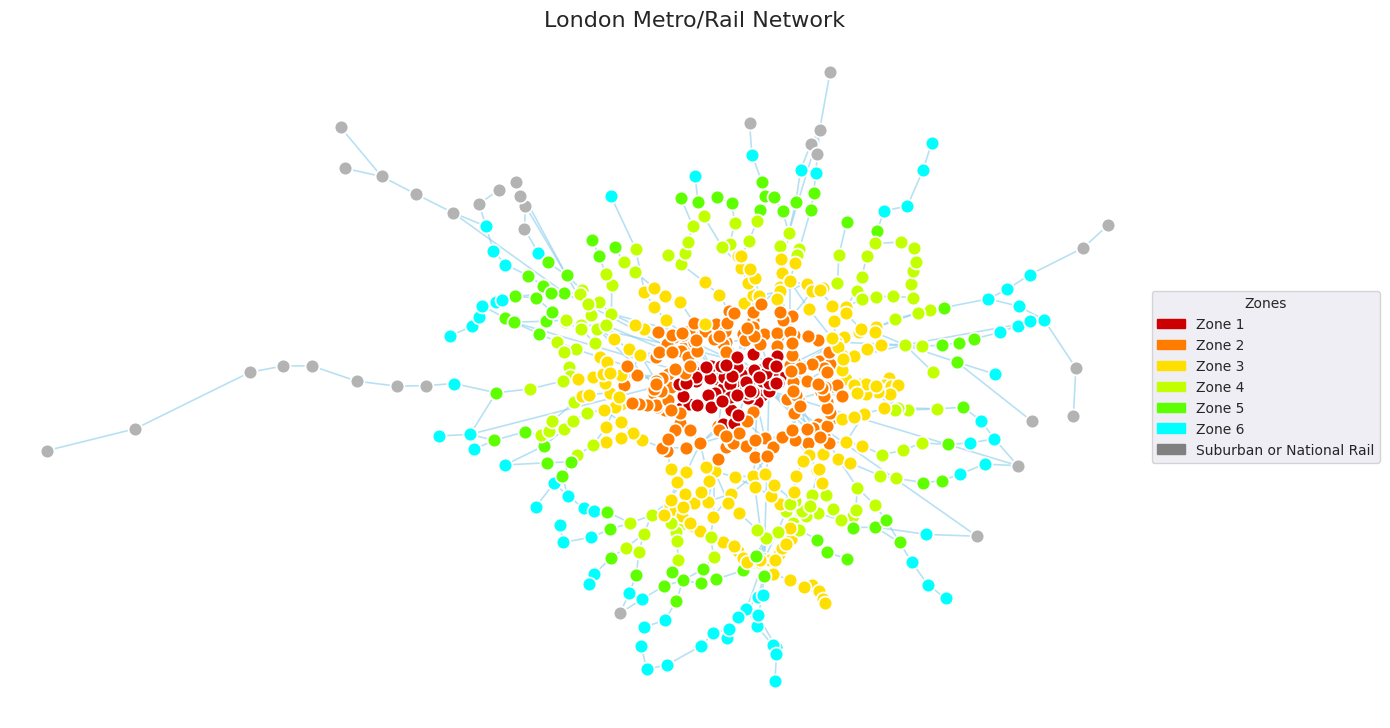

Removed 99 nodes outside zones {'2', '1', '6', '3', '5', '4'} from the graph.
Graph saved to london_metro_filtered.graphml


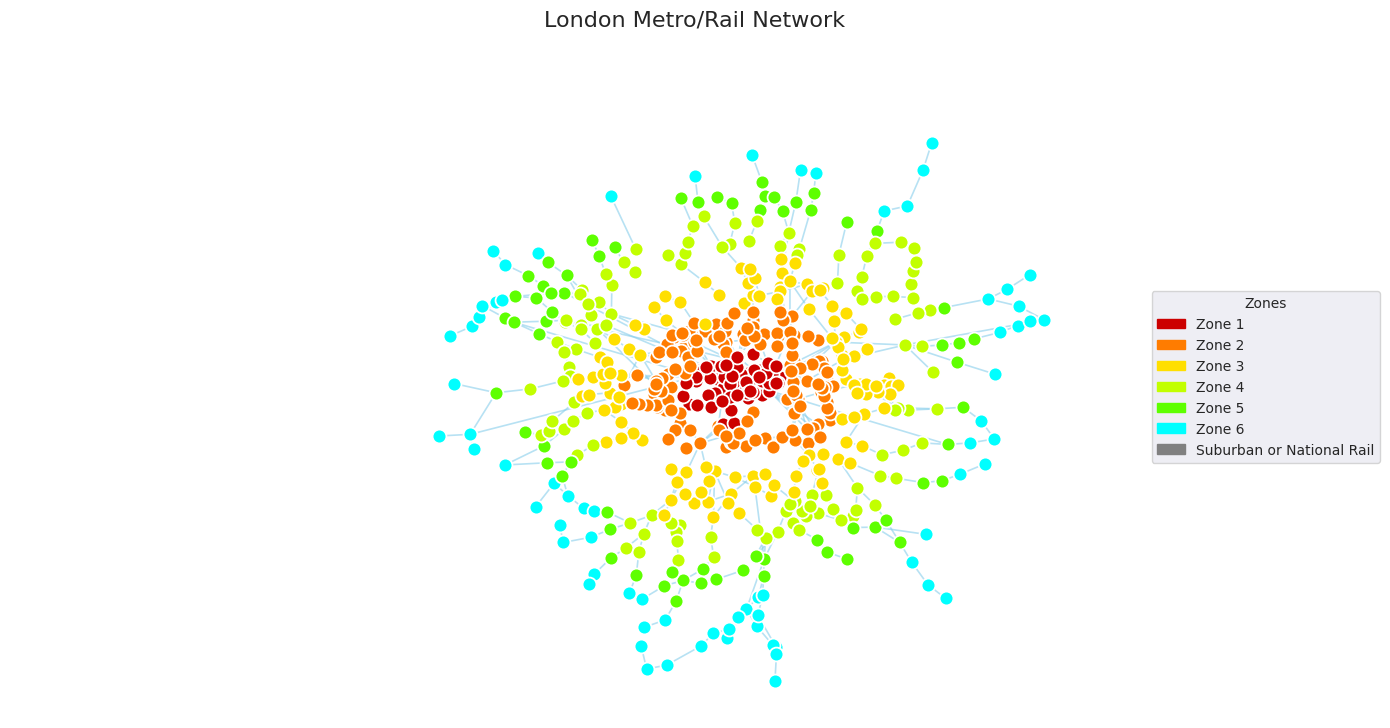

   nlc       Station Note  Entry_Week  Entry_Saturday  Entry_Sunday  \
0  500    acton town           8702.0          6326.0        4216.0   
1  502       aldgate          11319.0          2358.0        2251.0   
2  503  aldgate east          15045.0          8983.0        8051.0   
3  505      alperton           4478.0          3357.0        2373.0   
4  506      amersham           3461.0          1496.0         975.0   

   Exit_Week  Exit_Saturday  Exit_Sunday  AnnualEntryExit_Mill  ...       lat  \
0     8392.0         5976.0       4223.0                  5.46  ...  51.50250   
1    10919.0         3676.0       2758.0                  6.24  ...  51.51394   
2    13957.0         8177.0       7672.0                  9.16  ...  51.51514   
3     4665.0         3384.0       2399.0                  2.95  ...  51.54097   
4     3775.0         1582.0        869.0                  2.10  ...  51.67435   

        lon  zone                       geometry   msoa21cd  \
0 -0.278126     3  POIN

In [ ]:
# Carregar dados e criar objeto conforme antes
stations_path = "London_Stations.json"
lines_path = "London_Train_Lines.json"

metro = LondonMetroGraph(stations_path, lines_path, full_gdf_final)
metro.build_graph()
metro.clean_and_match_full_gdf()

G = metro.G.copy()
metro.G_original = metro.G.copy()
allowed_zones = {'1','2','3','4','5','6'}
metro.plot_network()
metro.filter_graph_nodes_by_zones(allowed_zones)

# Salvar dados para PyG Temporal
metro.save_graph(path_graphml="london_metro_filtered.graphml")
metro.save_full_gdf_final(path_csv="full_gdf_final_filtered.csv")

# Plotar grafo filtrado
metro.G = metro.G_filtered
metro.plot_network()

print(metro.full_gdf_final.head())
print(metro.full_gdf_final.info())


## 0) Pré-mineração de padrões frequentes

In [ ]:
# Nome dos nós do grafo
station_names_graph = set(G.nodes)

# Nome das estações temporais
station_names_data = set(full_gdf_final['Station'].unique())

# Estações que existem no grafo mas não nos dados
missing_in_data = station_names_graph - station_names_data
print(f"Estações no grafo que não têm dados temporais: {len(missing_in_data)}")

Estações no grafo que não têm dados temporais: 403


In [ ]:
# Remove todas as linhas com pelo menos um valor NaN
full_gdf_final = full_gdf_final.dropna()
full_gdf_final.reset_index()
full_gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2737 entries, 0 to 2954
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype        
---  ------                     --------------  -----        
 0   nlc                        2737 non-null   category     
 1   Station                    2737 non-null   object       
 2   Note                       2737 non-null   category     
 3   Entry_Week                 2737 non-null   float64      
 4   Entry_Saturday             2737 non-null   float64      
 5   Entry_Sunday               2737 non-null   float64      
 6   Exit_Week                  2737 non-null   float64      
 7   Exit_Saturday              2737 non-null   float64      
 8   Exit_Sunday                2737 non-null   float64      
 9   AnnualEntryExit_Mill       2737 non-null   float64      
 10  date                       2737 non-null   period[Y-DEC]
 11  Borough                    2737 non-null   object       
 12  Entry_Week_norm  

In [ ]:
full_gdf_final

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,...,Ratio_Weekend_Weekday,year,lat,lon,zone,geometry,msoa21cd,msoa21nm,lad22cd,lad22nm
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,...,1.213350,2011,51.502500,-0.278126,3,POINT (519609.561 179579.054),E02000270,Ealing 033,E09000009,Ealing
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,...,0.496582,2011,51.513940,-0.075370,1,POINT (533648 181201.736),E02000001,City of London 001,E09000001,City of London
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,...,1.133818,2011,51.515140,-0.071780,1,POINT (533893.575 181341.736),E02000884,Tower Hamlets 021,E09000030,Tower Hamlets
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,...,1.259215,2011,51.540970,-0.300610,4,POINT (517949.734 183820.682),E02000121,Brent 029,E09000005,Brent
5,507,Angel,,27812.0,21215.0,12655.0,27740.0,21851.0,12446.0,17.780000,...,1.227085,2011,51.532530,-0.105790,1,POINT (531483.794 183213.935),E02000573,Islington 020,E09000019,Islington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,...,1.089270,2015,51.433910,-0.198640,3,POINT (525313.801 172084.357),E02000689,Merton 001,E09000024,Merton
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,...,1.510965,2015,51.597090,-0.109390,3,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,...,1.244581,2015,51.597090,-0.109390,2,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,...,1.144837,2015,51.605820,0.033280,4,POINT (540902.528 191622.832),E02000751,Redbridge 001,E09000026,Redbridge


## 1) Discretizar atributos numéricos

In [ ]:
# Cópia da base para transformar
df_assoc = full_gdf_final.copy()

# Discretizar as colunas alvo em 3 categorias (low, medium, high)
df_assoc['Total_Weekday_bin'] = pd.qcut(df_assoc['Total_Weekday'], q=3, labels=['low', 'medium', 'high'])
df_assoc['Total_Weekend_bin'] = pd.qcut(df_assoc['Total_Weekend'], q=3, labels=['low', 'medium', 'high'])

In [ ]:
'Anerley' in df_assoc['Station'].values

False

In [ ]:
df_assoc

,nlc,Station,Note,Entry_Week,Entry_Saturday,Entry_Sunday,Exit_Week,Exit_Saturday,Exit_Sunday,AnnualEntryExit_Mill,...,lat,lon,zone,geometry,msoa21cd,msoa21nm,lad22cd,lad22nm,Total_Weekday_bin,Total_Weekend_bin
0,500,Acton Town,,8702.0,6326.0,4216.0,8392.0,5976.0,4223.0,5.460000,...,51.502500,-0.278126,3,POINT (519609.561 179579.054),E02000270,Ealing 033,E09000009,Ealing,medium,medium
1,502,Aldgate,,11319.0,2358.0,2251.0,10919.0,3676.0,2758.0,6.240000,...,51.513940,-0.075370,1,POINT (533648 181201.736),E02000001,City of London 001,E09000001,City of London,medium,low
2,503,Aldgate East,,15045.0,8983.0,8051.0,13957.0,8177.0,7672.0,9.160000,...,51.515140,-0.071780,1,POINT (533893.575 181341.736),E02000884,Tower Hamlets 021,E09000030,Tower Hamlets,high,high
3,505,Alperton,,4478.0,3357.0,2373.0,4665.0,3384.0,2399.0,2.950000,...,51.540970,-0.300610,4,POINT (517949.734 183820.682),E02000121,Brent 029,E09000005,Brent,low,low
5,507,Angel,,27812.0,21215.0,12655.0,27740.0,21851.0,12446.0,17.780000,...,51.532530,-0.105790,1,POINT (531483.794 183213.935),E02000573,Islington 020,E09000019,Islington,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,768,Wimbledon Park,,3293.0,2293.0,1378.0,2532.0,1572.0,1102.0,1.821025,...,51.433910,-0.198640,3,POINT (525313.801 172084.357),E02000689,Merton 001,E09000024,Merton,low,low
2951,770,Wood Green,,20281.0,18092.0,12443.0,18982.0,16840.0,11950.0,13.189190,...,51.597090,-0.109390,3,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey,high,high
2952,599,Wood Lane,,5457.0,5186.0,1893.0,6077.0,4333.0,2943.0,3.698414,...,51.597090,-0.109390,2,POINT (531048.504 190386.815),E02000412,Haringey 016,E09000014,Haringey,low,medium
2953,769,Woodford,,9637.0,6998.0,4270.0,9481.0,6445.0,4174.0,6.034086,...,51.605820,0.033280,4,POINT (540902.528 191622.832),E02000751,Redbridge 001,E09000026,Redbridge,medium,medium


In [ ]:
# Discretizar também a razão entre finais de semana e dias úteis
df_assoc['Ratio_bin'] = pd.qcut(df_assoc['Ratio_Weekend_Weekday'], q=3, labels=['low', 'medium', 'high'])

# Colunas categóricas úteis diretamente - Garante que as colunas categóricas (como Borough e zone) sejam do tipo str, necessário para formar transações no estilo atributo=valor
cat_cols = ['Borough', 'zone']
for col in cat_cols:
    df_assoc[col] = df_assoc[col].astype(str)

## 2) Transformar para formato transacional

In [ ]:
# Montar transações estilo "col=valor"
trans_cols = ['Total_Weekday_bin', 'Total_Weekend_bin', 'Ratio_bin', 'Borough', 'zone']

transactions = []
for _, row in df_assoc[trans_cols].iterrows(): # P/ cada linha do df_assoc, extrai os valores das colunas discretizadas e categóricas
    items = [f"{col}={row[col]}" for col in trans_cols]
    transactions.append(items) # Monta uma lista de strings no formato coluna=valor, que representa uma transação para mineração de regras

# Codificação binária das transações (One-hot encoding)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Usa TransactionEncoder do mlxtend para converter as transações em um array booleano (one-hot).
# Cria um DataFrame (df_trans) com colunas como Borough=Camden, Total_Weekday_bin=high, etc.

In [ ]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Borough=Barking and Dagenham    2737 non-null   bool 
 1   Borough=Barnet                  2737 non-null   bool 
 2   Borough=Bexley                  2737 non-null   bool 
 3   Borough=Brent                   2737 non-null   bool 
 4   Borough=Camden                  2737 non-null   bool 
 5   Borough=City of London          2737 non-null   bool 
 6   Borough=City of Westminster     2737 non-null   bool 
 7   Borough=Ealing                  2737 non-null   bool 
 8   Borough=Enfield                 2737 non-null   bool 
 9   Borough=Greenwich               2737 non-null   bool 
 10  Borough=Hackney                 2737 non-null   bool 
 11  Borough=Hammersmith and Fulham  2737 non-null   bool 
 12  Borough=Haringey                2737 non-null   bool 
 13  Bor

In [ ]:
df_trans

,Borough=Barking and Dagenham,Borough=Barnet,Borough=Bexley,Borough=Brent,Borough=Camden,Borough=City of London,Borough=City of Westminster,Borough=Ealing,Borough=Enfield,Borough=Greenwich,...,Total_Weekday_bin=medium,Total_Weekend_bin=high,Total_Weekend_bin=low,Total_Weekend_bin=medium,zone=1,zone=2,zone=3,zone=4,zone=5,zone=6
0,False,False,False,False,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,True,False,True,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2733,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
2734,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
2735,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,False,False


Cada linha de `df_trans` resultante representa **uma estação em dado momento de tempo** e seus **atributos discretizados**, organizados no formato de transações, como por exemplo:

* **Bairro** (*Borough*)
* **Fluxo anual discretizado** (*AnnualEntryExit\_Mill\_bin*)
* **Fluxo em dias úteis** (*Total\_Weekday\_bin*)
* **Fluxo no fim de semana** (*Total\_Weekend\_bin*)

Um exemplo de transação gerada é:

```
['Borough=Camden', 'AnnualEntryExit_Mill_bin=High', 'Total_Weekday_bin=Medium', 'Total_Weekend_bin=Low']
```

→ Essa transação indica que a estação está localizada em *Camden*, possui um fluxo anual **alto**, um fluxo de dias úteis **médio** e um fluxo de fim de semana **baixo**.

## 3) Obter Itemsets Frequentes e Regras de Associação

In [ ]:
# Gerar itemsets frequentes
frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True) # use_colnames=True garante que os nomes das colunas originais sejam mantidos nos resultados.

# Gerar regras
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Filtra as regras onde o consequente (parte “então” da regra) contém algum valor de interesse, relacionado ao fluxo discretizado.
# Ordena as regras pela métrica lift, da maior para a menor, priorizando as mais significativas.

In [ ]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         204 non-null    object 
 1   consequents         204 non-null    object 
 2   antecedent support  204 non-null    float64
 3   consequent support  204 non-null    float64
 4   support             204 non-null    float64
 5   confidence          204 non-null    float64
 6   lift                204 non-null    float64
 7   representativity    204 non-null    float64
 8   leverage            204 non-null    float64
 9   conviction          204 non-null    float64
 10  zhangs_metric       204 non-null    float64
 11  jaccard             204 non-null    float64
 12  certainty           204 non-null    float64
 13  kulczynski          204 non-null    float64
dtypes: float64(12), object(2)
memory usage: 22.4+ KB


In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Total_Weekday_bin=low),(Borough=Brent),0.333212,0.086957,0.055170,0.165570,1.904057,1.0,0.026195,1.094212,0.712078,0.151151,0.086101,0.400012
1,(Borough=Brent),(Total_Weekday_bin=low),0.086957,0.333212,0.055170,0.634454,1.904057,1.0,0.026195,1.824088,0.520025,0.151151,0.451781,0.400012
2,(Total_Weekend_bin=low),(Borough=Brent),0.333212,0.086957,0.054439,0.163377,1.878838,1.0,0.025464,1.091344,0.701506,0.148851,0.083699,0.394714
3,(Borough=Brent),(Total_Weekend_bin=low),0.086957,0.333212,0.054439,0.626050,1.878838,1.0,0.025464,1.783097,0.512304,0.148851,0.439178,0.394714
4,(Borough=Westminster),(zone=1),0.068688,0.259408,0.058458,0.851064,3.280791,1.0,0.040640,4.972546,0.746469,0.216802,0.798896,0.538208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,"(Ratio_bin=medium, Total_Weekday_bin=medium)","(zone=2, Total_Weekend_bin=medium)",0.137742,0.126416,0.057727,0.419098,3.315236,1.0,0.040315,1.503841,0.809923,0.279646,0.335036,0.437873
200,(Total_Weekend_bin=medium),"(zone=2, Ratio_bin=medium, Total_Weekday_bin=m...",0.333212,0.062112,0.057727,0.173246,2.789254,1.0,0.037031,1.134422,0.962046,0.170996,0.118494,0.551329
201,(zone=2),"(Total_Weekday_bin=medium, Ratio_bin=medium, T...",0.257947,0.128243,0.057727,0.223796,1.745099,1.0,0.024648,1.123104,0.575385,0.175751,0.109610,0.336969
202,(Ratio_bin=medium),"(Total_Weekday_bin=medium, zone=2, Total_Weeke...",0.333212,0.112897,0.057727,0.173246,1.534541,1.0,0.020109,1.072994,0.522414,0.148636,0.068029,0.342286


## 4) Filtrar Regras com Consequente Focado nos Targets / Elaborar uma representação de padrões de frequências

### **Lift**

Para uma regra de associação do tipo:

$$
A \Rightarrow B
$$

O **lift** é calculado como:

$$
\text{Lift}(A \Rightarrow B) = \frac{P(A \cap B)}{P(A) \cdot P(B)}
$$


In [ ]:
target_cols = [
    'Total_Weekday_bin=high', 'Total_Weekday_bin=medium', 'Total_Weekday_bin=low',
    'Total_Weekend_bin=high', 'Total_Weekend_bin=medium', 'Total_Weekend_bin=low'
]

rules_filtered = rules[rules['consequents'].apply(
    lambda x: any(item in target_cols for item in x)
)].sort_values(by='lift', ascending=False)

In [ ]:
rules_filtered

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
194,"(zone=2, Total_Weekend_bin=medium)","(Ratio_bin=medium, Total_Weekday_bin=medium)",0.126416,0.137742,0.057727,0.456647,3.315236,1.0,0.040315,1.586922,0.799422,0.279646,0.369849,0.437873
199,"(Ratio_bin=medium, Total_Weekday_bin=medium)","(zone=2, Total_Weekend_bin=medium)",0.137742,0.126416,0.057727,0.419098,3.315236,1.0,0.040315,1.503841,0.809923,0.279646,0.335036,0.437873
181,"(Total_Weekend_bin=high, zone=1)","(Total_Weekday_bin=high, Ratio_bin=high)",0.167336,0.166240,0.091341,0.545852,3.283507,1.0,0.063523,1.835874,0.835208,0.377074,0.455300,0.547651
184,"(Total_Weekday_bin=high, Ratio_bin=high)","(Total_Weekend_bin=high, zone=1)",0.166240,0.167336,0.091341,0.549451,3.283507,1.0,0.063523,1.848107,0.834110,0.377074,0.458906,0.547651
93,(zone=1),"(Total_Weekday_bin=high, Ratio_bin=low)",0.259408,0.084034,0.070881,0.273239,3.251549,1.0,0.049082,1.260341,0.935001,0.260054,0.206564,0.558359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,(zone=3),(Total_Weekday_bin=medium),0.172817,0.333212,0.061381,0.355180,1.065929,1.0,0.003796,1.034069,0.074773,0.138044,0.032946,0.269695
59,(zone=3),(Total_Weekend_bin=high),0.172817,0.333577,0.061016,0.353066,1.058423,1.0,0.003368,1.030125,0.066730,0.136998,0.029244,0.267990
153,(zone=3),"(Total_Weekend_bin=high, Total_Weekday_bin=high)",0.172817,0.292656,0.052978,0.306554,1.047488,1.0,0.002402,1.020042,0.054807,0.128432,0.019648,0.243789
42,(zone=3),(Total_Weekday_bin=low),0.172817,0.333212,0.058458,0.338266,1.015170,1.0,0.000874,1.007639,0.018065,0.130612,0.007581,0.256852


In [ ]:
rules_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 194 to 24
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         132 non-null    object 
 1   consequents         132 non-null    object 
 2   antecedent support  132 non-null    float64
 3   consequent support  132 non-null    float64
 4   support             132 non-null    float64
 5   confidence          132 non-null    float64
 6   lift                132 non-null    float64
 7   representativity    132 non-null    float64
 8   leverage            132 non-null    float64
 9   conviction          132 non-null    float64
 10  zhangs_metric       132 non-null    float64
 11  jaccard             132 non-null    float64
 12  certainty           132 non-null    float64
 13  kulczynski          132 non-null    float64
dtypes: float64(12), object(2)
memory usage: 15.5+ KB


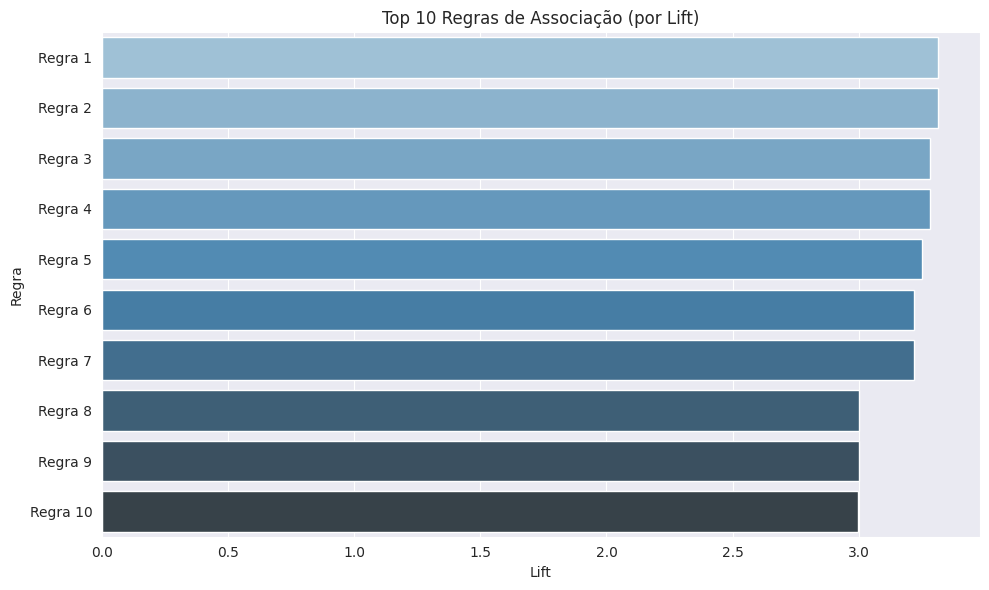

In [ ]:
# Selecionar as 10 regras com maior lift
top_rules = rules_filtered.sort_values(by="lift", ascending=False).head(10).copy()

# Criar strings legíveis
top_rules["antecedents_str"] = top_rules["antecedents"].apply(lambda x: ', '.join(list(x)))
top_rules["consequents_str"] = top_rules["consequents"].apply(lambda x: ', '.join(list(x)))

# Criar nomes como "Regra 1", "Regra 2", ...
top_rules["regra_id"] = ["Regra " + str(i+1) for i in range(len(top_rules))]

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_rules,
    y="regra_id",
    x="lift",
    palette="Blues_d",
    hue="regra_id",        # necessário para aplicar o palette
    dodge=False,           # evita barras lado a lado (requerido com hue)
    legend=False           # evita legenda desnecessária
)
plt.title("Top 10 Regras de Associação (por Lift)")
plt.xlabel("Lift")
plt.ylabel("Regra")
plt.tight_layout()
plt.savefig("teste.pdf")
plt.show()

In [ ]:
top_rules_md = top_rules[["regra_id", "antecedents_str", "consequents_str", "lift"]].copy()
top_rules_md.columns = ["Regra", "Antecedente(s)", "Consequente(s)", "Lift"]
print(top_rules_md.to_markdown(index=False))

| Regra    | Antecedente(s)                             | Consequente(s)                                 |    Lift |
|:---------|:-------------------------------------------|:-----------------------------------------------|--------:|
| Regra 1  | zone=2, Total_Weekend_bin=medium           | Ratio_bin=medium, Total_Weekday_bin=medium     | 3.31524 |
| Regra 2  | Ratio_bin=medium, Total_Weekday_bin=medium | zone=2, Total_Weekend_bin=medium               | 3.31524 |
| Regra 3  | Total_Weekend_bin=high, zone=1             | Total_Weekday_bin=high, Ratio_bin=high         | 3.28351 |
| Regra 4  | Total_Weekday_bin=high, Ratio_bin=high     | Total_Weekend_bin=high, zone=1                 | 3.28351 |
| Regra 5  | zone=1                                     | Total_Weekday_bin=high, Ratio_bin=low          | 3.25155 |
| Regra 6  | Ratio_bin=medium, Total_Weekend_bin=medium | zone=2, Total_Weekday_bin=medium               | 3.21962 |
| Regra 7  | zone=2, Total_Weekday_bin=medium           | Ratio_

### **Interpretação das Regras**

| Regra        | Interpretação                                                                                                                                                       |
| ------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Regra 1**  | Estações com **movimento médio** nos dias úteis e **razão média** fim de semana/dia útil tendem a ter **movimento médio no fim de semana** e estarem na **zona 2**. |
| **Regra 2**  | Estações localizadas na **zona 2** com **movimento médio no fim de semana** geralmente têm também **movimento médio nos dias úteis** e **razão média**.             |
| **Regra 3**  | Estações na **zona 1** com **alto movimento no fim de semana** tendem fortemente a também ter **alto fluxo nos dias úteis** e **alta razão**.                       |
| **Regra 4**  | O inverso da Regra 3: se a estação tem **alto fluxo nos dias úteis** e **alta razão**, é provável que seja na **zona 1** com **alto movimento no fim de semana**.   |
| **Regra 5**  | Estações na **zona 1** costumam ter **alto fluxo nos dias úteis**, mas **baixa razão**, ou seja, o fluxo cai no fim de semana.                                      |
| **Regra 6**  | Estações com **razão média** e **fluxo médio no fim de semana** tendem a estar na **zona 2** e também ter **movimento médio nos dias úteis**.                       |
| **Regra 7**  | Estações na **zona 2** com **movimento médio nos dias úteis** tendem a apresentar **razão média** e **fluxo médio no fim de semana**.                               |
| **Regra 8**  | Estações com **baixa razão** e **baixa movimentação nos dias úteis** também têm **baixo movimento no fim de semana**.                                               |
| **Regra 9**  | Estações com **baixo movimento no fim de semana** tendem a ter também **baixo movimento nos dias úteis** e **baixa razão**.                                         |
| **Regra 10** | Estações com **alto movimento no fim de semana** estão associadas àquelas da **zona 1**, com **alto fluxo nos dias úteis** e **alta razão**.                        |

---

Essas regras revelam **padrões comportamentais e espaciais** no uso das estações:

* A **zona 1** está associada a **alta movimentação** durante a semana e o fim de semana.
* A **zona 2** concentra perfis de **movimentação média** com regularidade entre dias úteis e fins de semana.
* Estações com **baixo movimento** nos dias úteis têm forte tendência a se manter com **baixo uso também nos fins de semana**.

As regras com maior **lift** indicam **associação acima do esperado por acaso**, sendo úteis para:

* **Segmentar estações** por comportamento de uso.
* **Apoiar decisões de operação** (ex: alocação de trens por horário e local).
* **Análise urbana de mobilidade** nas zonas metropolitanas.

In [ ]:
# Selecionar as 10 regras com menor lift
low_lift_rules = rules_filtered.sort_values(by="lift", ascending=True).head(10).copy()

# Transformar conjuntos para strings legíveis
low_lift_rules["antecedents_str"] = low_lift_rules["antecedents"].apply(lambda x: ', '.join(list(x)))
low_lift_rules["consequents_str"] = low_lift_rules["consequents"].apply(lambda x: ', '.join(list(x)))
low_lift_rules["rule"] = low_lift_rules["antecedents_str"] + " → " + low_lift_rules["consequents_str"]

# Exibir tabela
display(low_lift_rules[["rule", "lift"]])

,rule,lift
24,Ratio_bin=medium → Total_Weekday_bin=low,1.010238
42,zone=3 → Total_Weekday_bin=low,1.015170
153,"zone=3 → Total_Weekend_bin=high, Total_Weekday...",1.047488
59,zone=3 → Total_Weekend_bin=high,1.058423
52,zone=3 → Total_Weekday_bin=medium,1.065929
54,zone=4 → Total_Weekday_bin=medium,1.068975
118,"Ratio_bin=medium → Total_Weekend_bin=low, Tota...",1.074742
92,"Ratio_bin=low → Total_Weekday_bin=high, zone=1",1.087056
28,Ratio_bin=medium → Total_Weekend_bin=medium,1.214259
26,Ratio_bin=medium → Total_Weekday_bin=medium,1.240585


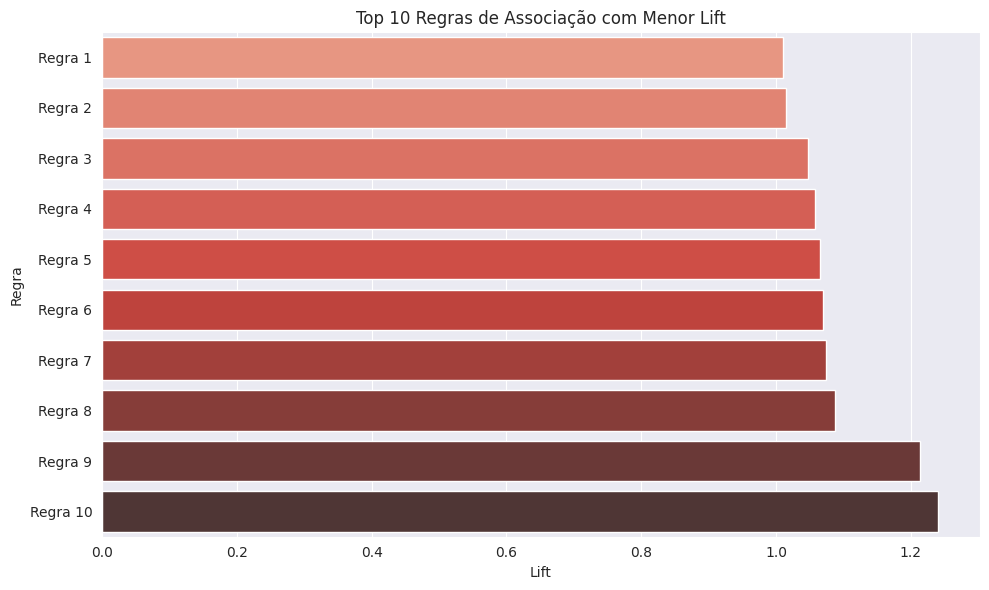

In [ ]:
# Selecionar as 10 regras com menor lift
bottom_rules = rules_filtered.sort_values(by="lift", ascending=True).head(10).copy()

# Transformar conjuntos em strings
bottom_rules["antecedents_str"] = bottom_rules["antecedents"].apply(lambda x: ', '.join(list(x)))
bottom_rules["consequents_str"] = bottom_rules["consequents"].apply(lambda x: ', '.join(list(x)))
bottom_rules["rule"] = ["Regra " + str(i + 1) for i in range(len(bottom_rules))]

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom_rules,
    y="rule",
    x="lift",
    hue="rule",
    dodge=False,
    palette="Reds_d",
    legend=False
)
plt.title("Top 10 Regras de Associação com Menor Lift")
plt.xlabel("Lift")
plt.ylabel("Regra")
plt.tight_layout()
plt.show()

### **Tabela – Regras com Lift próximo de 1**

| Regra    | Antecedente(s)    | Consequente(s)                                      | Lift   |
| -------- | ----------------- | --------------------------------------------------- | ------ |
| Regra 1  | Ratio\_bin=medium | Total\_Weekday\_bin=low                             | 1.0102 |
| Regra 2  | zone=3            | Total\_Weekday\_bin=low                             | 1.0152 |
| Regra 3  | zone=3            | Total\_Weekend\_bin=high, Total\_Weekday\_bin=high  | 1.0475 |
| Regra 4  | zone=3            | Total\_Weekend\_bin=high                            | 1.0584 |
| Regra 5  | zone=3            | Total\_Weekday\_bin=medium                          | 1.0659 |
| Regra 6  | zone=4            | Total\_Weekday\_bin=medium                          | 1.0690 |
| Regra 7  | Ratio\_bin=medium | Total\_Weekday\_bin=low, Total\_Weekend\_bin=medium | 1.0747 |
| Regra 8  | Ratio\_bin=low    | zone=1, Total\_Weekday\_bin=high                    | 1.0871 |
| Regra 9  | Ratio\_bin=medium | Total\_Weekend\_bin=medium                          | 1.2143 |
| Regra 10 | Ratio\_bin=medium | Total\_Weekday\_bin=medium                          | 1.2406 |


Essas regras têm **lift próximo de 1**, o que indica que a coocorrência entre os itens no antecedente e no consequente ocorre de maneira **quase independente**, ou seja, o conhecimento de uma parte **não fornece ganho informativo significativo** sobre a outra. Essas regras **não são especialmente úteis** do ponto de vista da associação forte, mas podem ser relevantes para análise de *baseline* ou correlações fracas esperadas.

## Verificando com lift < 1

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.1)

target_cols = [
    'Total_Weekday_bin=high', 'Total_Weekday_bin=medium', 'Total_Weekday_bin=low',
    'Total_Weekend_bin=high', 'Total_Weekend_bin=medium', 'Total_Weekend_bin=low'
]

rules_filtered = rules[rules['consequents'].apply(
    lambda x: any(item in target_cols for item in x)
)].sort_values(by='lift', ascending=False)


In [ ]:
# Reordenar para mostrar os menores lifts
rules_low_lift = rules_filtered.sort_values(by='lift', ascending=True)

# Selecionar as 10 regras com menor lift
rules_low_lift_top10 = rules_low_lift.head(10)

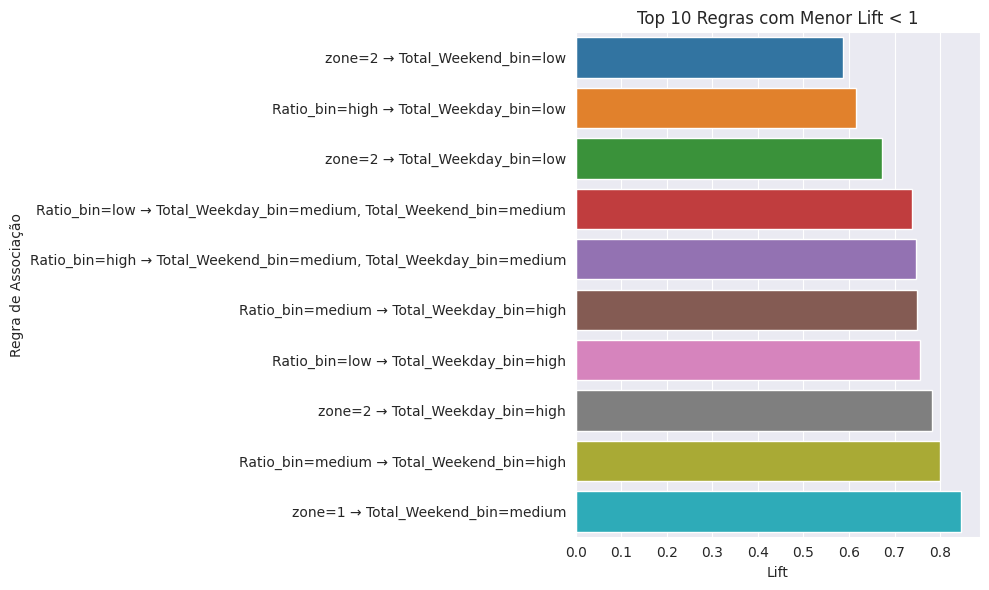

In [ ]:
# Garantir cópia real
rules_low_lift_top10 = rules_low_lift.head(10).copy()

# Gerar string descritiva da regra
rules_low_lift_top10['rule_text'] = rules_low_lift_top10.apply(
    lambda row: f"{', '.join(row['antecedents'])} → {', '.join(row['consequents'])}", axis=1)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=rules_low_lift_top10,
    y='rule_text',
    x='lift',
    hue='rule_text',
    legend=False
)
plt.xlabel('Lift')
plt.ylabel('Regra de Associação')
plt.title('Top 10 Regras com Menor Lift < 1')
plt.tight_layout()
plt.show()

## Fase 2 – Mineração de Padrões Frequentes

1. **Discretização** dos atributos contínuos como `Total_Weekday`, `Total_Weekend` e `Ratio_Weekend_Weekday` em categorias (`low`, `medium`, `high`) usando `qcut`.
2. **Conversão dos dados** para formato transacional com colunas do tipo `coluna=valor` (ex: `zone=3`, `Borough=Camden`).
3. Aplicação do algoritmo **Apriori** para extração de itemsets frequentes.
4. Geração de **regras de associação** com a função `association_rules`, usando `lift` como métrica principal.
5. Filtro das regras cujos **consequentes** estão relacionados com os padrões de fluxo (`Total_Weekday_bin`, `Total_Weekend_bin`).
6. **Visualização das 10 regras com maior lift**, representando as mais fortes associações.

---

Com base no **Top 10 Regras de Associação (por Lift)**:

* Há uma **forte correlação entre o zoneamento e o padrão de fluxo**:

  * Exemplo: `zone=1` associado a `Total_Weekend_bin=high`, `Total_Weekday_bin=high` e `Ratio_bin=high`, indicando grande uso em todos os dias da semana, inclusive fins de semana.
* **Padrões moderados** (bin=medium) de fluxo aparecem associados a `zone=2` e `Ratio_bin=medium`.

  * Mostra que **zonas intermediárias** têm comportamento menos extremo de uso.
* **Zonas mais periféricas** (`zone=4`, `5`, `6`) não aparecem nas regras mais fortes, sugerindo **menor frequência** ou **menor regularidade** no uso.

---

### Interpretação

* O **zoneamento urbano** é uma variável chave para entender padrões de mobilidade.
* Esta análise **confirma a importância das zonas centrais (1 e 2)** no transporte urbano em Londres.
* As **zonas com menor densidade urbana** apresentam menos regularidade no fluxo, o que pode indicar:

  * Uso mais esporádico,
  * Menor conectividade,
  * Dependência de outros meios de transporte.

---

### Possibilidades Futuras

* Cruzar essas regras com **atributos demográficos** das zonas (densidade populacional, renda, etc.).
* Aplicar **padrões sequenciais** para capturar mudanças ao longo do tempo (ex: antes e depois de 2020).
* Visualizar os fluxos em um **grafo geográfico** para ver conexões fortes com base nessas regras.

# **Fase 3 - Fase final**

## **Objetivo**

Na Fase 3, o objetivo é implementar, propor e avaliar estratégias de **previsão de séries temporais** para estimar o fluxo de passageiros nas estações do metrô de Londres. Essa previsão poderá auxiliar o planejamento operacional, a gestão de infraestrutura e a compreensão da demanda ao longo do tempo.

Além da aplicação dos modelos, é esperado um processo sistemático de avaliação e documentação dos resultados, conforme os critérios do desafio acadêmico.

---

## **Descrição do Dataset: `full_gdf_final`**

O dataset contém informações consolidadas sobre 2737 registros de estações ou pontos específicos do metrô de Londres, com dados de fluxo, características espaciais e atributos administrativos.

### 🔎 **Tabela de Atributos**

| **Coluna**                  | **Descrição**                                                           | **Tipo**         |
|------------------------------|-------------------------------------------------------------------------|------------------|
| `nlc`                        | Código único da estação                                                 | `category`       |
| `Station`                    | Nome da estação                                                         | `object`         |
| `Note`                       | Observações adicionais                                                  | `category`       |
| `Entry_Week`                 | Total de entradas típicas em um dia útil (estimativa)                   | `float64`        |
| `Entry_Saturday`             | Total de entradas típicas em um sábado (estimativa)                     | `float64`        |
| `Entry_Sunday`               | Total de entradas típicas em um domingo (estimativa)                    | `float64`        |
| `Exit_Week`                  | Total de saídas típicas em um dia útil (estimativa)                     | `float64`        |
| `Exit_Saturday`              | Total de saídas típicas em um sábado (estimativa)                       | `float64`        |
| `Exit_Sunday`                | Total de saídas típicas em um domingo (estimativa)                      | `float64`        |
| `AnnualEntryExit_Mill`       | Total anual estimado de entradas + saídas (em milhões)                  | `float64`        |
| `date`                       | Data de referência (período)                                            | `period[Y-DEC]`  |
| `Borough`                    | Distrito da estação                                                     | `object`         |
| `Entry_Week_norm`            | Entrada típica em dia útil (normalizada)                                | `float64`        |
| `Exit_Week_norm`             | Saída típica em dia útil (normalizada)                                  | `float64`        |
| `AnnualEntryExit_Mill_norm`  | Total anual normalizado de entradas + saídas                            | `float64`        |
| `Total_Weekday`              | Total de entradas + saídas típicas em dia útil                          | `float64`        |
| `Total_Weekend`              | Total de entradas + saídas típicas em final de semana                   | `float64`        |
| `Ratio_Weekend_Weekday`      | Razão entre o fluxo de fim de semana e o de dia útil                    | `float64`        |
| `year`                       | Ano de referência                                                       | `int64`          |
| `lat`                        | Latitude da estação                                                     | `float64`        |
| `lon`                        | Longitude da estação                                                    | `float64`        |
| `zone`                       | Zona tarifária do metrô                                                 | `int64`          |
| `geometry`                   | Geometria espacial da estação                                           | `geometry`       |
| `msoa21cd`                   | Código da área estatística MSOA (2021)                                  | `object`         |
| `msoa21nm`                   | Nome da área estatística MSOA (2021)                                    | `object`         |
| `lad22cd`                    | Código do distrito administrativo (2022)                                | `object`         |
| `lad22nm`                    | Nome do distrito administrativo (2022)                                  | `object`         |

---

## **Resumo do que já havia sido realizado (Fases Anteriores)**

Durante as fases 1 e 2 do projeto, foram conduzidas as seguintes etapas de preparação de dados:

✅ **Integração e Limpeza de Dados**:

✔ Consolidação de informações temporais, espaciais e administrativas a partir de diferentes fontes (Kaggle, Doogal, ONS).

✔ Padronização e limpeza de nomes de estações com fuzzy matching.

✔ Imputação de dados faltantes.

✔ Cálculo de métricas derivadas, como `Total_Weekday`, `Total_Weekend` e `Ratio_Weekend_Weekday`.

✔ Associação das estações a distritos administrativos e áreas estatísticas (Boroughs, MSOA, LAD).

✅ **Construção do Grafo do Metrô**:

✔ Geração da rede metroviária como grafo espacial usando `networkx`.

✔ Inclusão de atributos como zona tarifária, localização geográfica e pertencimento administrativo.

✔ Visualizações da rede e sobreposição com o mapa dos Boroughs de Londres.

O resultado dessas etapas foi o dataset final consolidado: `full_gdf_final`, utilizado como base para os experimentos de previsão.

---

## **O que foi Realizado na Fase 3**

✅ Preparação das séries temporais das principais features de fluxo:

✔ **Total de passageiros em dia útil (`Total_Weekday`)**, selecionada como variável-alvo para previsão.

✅ Implementação e comparação sistemática de modelos de previsão:

✔ **Prophet** — Modelagem robusta de tendência e sazonalidade.

✔ **ARIMA** — Modelo clássico auto-regressivo para séries estacionárias ou integradas.
✔ **LSTM** — Rede neural recorrente para captura de padrões
temporais complexos.

✅ Avaliação dos modelos em dois cenários:

✔ **Splits fixos de treino-teste**, simulando aplicações operacionais reais.

✔ **Validação cruzada com 6 folds** do tipo rolling-origin, para avaliação robusta e testes estatísticos.

✅ Realização de análise estatística formal:

✔ Testes de Wilcoxon para comparar LSTM com modelos clássicos.

✔ Teste de Mann-Whitney para avaliar o desempenho do Prophet entre zonas centrais e periféricas.

✔ ANOVA e Tukey HSD para explorar a variação do desempenho do LSTM entre zonas tarifárias.

✅ Visualizações detalhadas:

✔ Forecasts por estação.

✔ Distribuições de erro por modelo e zona.

✔ Mapas da rede metroviária e sua distribuição espacial.

✅ Elaboração de um **artigo científico completo** em formato ACM, estruturado em:

✔ Introdução, Fundamentação Teórica, Trabalhos Relacionados, Metodologia, Resultados, Análises e Conclusão.

---

# **Objetivo Final**

O projeto visa aplicar e avaliar modelos preditivos de séries temporais no contexto do transporte público de Londres, integrando dados espaciais e temporais. O trabalho demonstra a aplicação prática de técnicas estatísticas e de aprendizado profundo, considerando limitações de dados, desafios espaciais e as peculiaridades de redes de transporte.

In [ ]:
full_gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2737 entries, 0 to 2954
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype        
---  ------                     --------------  -----        
 0   nlc                        2737 non-null   category     
 1   Station                    2737 non-null   object       
 2   Note                       2737 non-null   category     
 3   Entry_Week                 2737 non-null   float64      
 4   Entry_Saturday             2737 non-null   float64      
 5   Entry_Sunday               2737 non-null   float64      
 6   Exit_Week                  2737 non-null   float64      
 7   Exit_Saturday              2737 non-null   float64      
 8   Exit_Sunday                2737 non-null   float64      
 9   AnnualEntryExit_Mill       2737 non-null   float64      
 10  date                       2737 non-null   period[Y-DEC]
 11  Borough                    2737 non-null   object       
 12  Entry_Week_norm  

### *Mapping*

In [ ]:
mapping = {
    # Espaços extras e versões com espaços inconsistentes
    'Acton Town                         ': 'Acton Town',
    'Acton Town': 'Acton Town',

    'Aldgate                            ': 'Aldgate',
    'Aldgate': 'Aldgate',

    'Aldgate East                       ': 'Aldgate East',
    'Aldgate East  ': 'Aldgate East',

    'Alperton                           ': 'Alperton',
    'Alperton  ': 'Alperton',

    'Angel                              ': 'Angel',
    'Angel  ': 'Angel',

    'Archway                            ': 'Archway',
    'Archway   ': 'Archway',

    'Arnos Grove                        ': 'Arnos Grove',
    'Arnos Grove': 'Arnos Grove',

    'Arsenal                            ': 'Arsenal',
    'Arsenal': 'Arsenal',

    'Baker Street                       ': 'Baker Street',
    'Baker Street  ': 'Baker Street',

    'Balham                             ': 'Balham',
    'Balham ': 'Balham',

    'Bank & Monument                    ': 'Bank & Monument',
    'Bank & Monument  ': 'Bank & Monument',
    'Bank': 'Bank & Monument',  # mapping curto

    'Barbican                           ': 'Barbican',
    'Barbican  ': 'Barbican',

    'Barking                            ': 'Barking',
    'Barking   ': 'Barking',

    'Barkingside                        ': 'Barkingside',
    'Barkingside': 'Barkingside',

    'Barons Court                       ': 'Barons Court',
    'Barons Court  ': 'Barons Court',

    'Bayswater                          ': 'Bayswater',
    'Bayswater ': 'Bayswater',

    'Becontree                          ': 'Becontree',
    'Becontree ': 'Becontree',

    'Belsize Park                       ': 'Belsize Park',
    'Belsize Park  ': 'Belsize Park',

    'Bermondsey                         ': 'Bermondsey',
    'Bermondsey': 'Bermondsey',

    'Bethnal Green                      ': 'Bethnal Green',
    'Bethnal Green ': 'Bethnal Green',

    'Blackhorse Road                    ': 'Blackhorse Road',
    'Blackhorse Road      ': 'Blackhorse Road',

    'Blackfriars                        ': 'Blackfriars',
    'Blackfriars ': 'Blackfriars',

    'Bond Street                        ': 'Bond Street',
    'Bond Street ': 'Bond Street',

    'Borough                            ': 'Borough',
    'Borough   ': 'Borough',

    'Boston Manor                       ': 'Boston Manor',
    'Boston Manor  ': 'Boston Manor',

    'Bounds Green                       ': 'Bounds Green',
    'Bounds Green  ': 'Bounds Green',

    'Bow Road                           ': 'Bow Road',
    'Bow Road  ': 'Bow Road',

    'Brent Cross                        ': 'Brent Cross',
    'Brent Cross': 'Brent Cross',

    'Brixton                            ': 'Brixton',
    'Brixton': 'Brixton',

    'Bromley-by-Bow                     ': 'Bromley-by-Bow',
    'Bromley-by-Bow       ': 'Bromley-by-Bow',

    'Burnt Oak                          ': 'Burnt Oak',
    'Burnt Oak ': 'Burnt Oak',

    'Caledonian Road                    ': 'Caledonian Road',
    'Caledonian Road      ': 'Caledonian Road',

    'Camden Town                        ': 'Camden Town',
    'Camden Town ': 'Camden Town',

    'Canada Water                       ': 'Canada Water',
    'Canada Water  ': 'Canada Water',

    'Canary Wharf                       ': 'Canary Wharf',
    'Canary Wharf  ': 'Canary Wharf',

    'Canning Town                       ': 'Canning Town',
    'Canning Town  ': 'Canning Town',

    'Cannon Street                      ': 'Cannon Street',
    'Cannon Street ': 'Cannon Street',

    'Canons Park                        ': 'Canons Park',
    'Canons Park': 'Canons Park',

    'Chalk Farm                         ': 'Chalk Farm',
    'Chalk Farm': 'Chalk Farm',

    'Chancery Lane                      ': 'Chancery Lane',
    'Chancery Lane ': 'Chancery Lane',

    'Charing Cross                      ': 'Charing Cross',
    'Charing Cross ': 'Charing Cross',

    'Chiswick Park                      ': 'Chiswick Park',
    'Chiswick Park ': 'Chiswick Park',

    'Clapham Common                     ': 'Clapham Common',
    'Clapham Common       ': 'Clapham Common',

    'Clapham North                      ': 'Clapham North',
    'Clapham North ': 'Clapham North',

    'Clapham South                      ': 'Clapham South',
    'Clapham South ': 'Clapham South',

    'Cockfosters                        ': 'Cockfosters',
    'Cockfosters': 'Cockfosters',

    'Colindale                          ': 'Colindale',
    'Colindale ': 'Colindale',

    'Colliers Wood                      ': 'Colliers Wood',
    'Colliers Wood ': 'Colliers Wood',

    'Covent Garden                      ': 'Covent Garden',
    'Covent Garden ': 'Covent Garden',

    'Dagenham East                      ': 'Dagenham East',
    'Dagenham East ': 'Dagenham East',

    'Dagenham Heathway                  ': 'Dagenham Heathway',
    'Dagenham Heathway    ': 'Dagenham Heathway',

    'Dollis Hill                        ': 'Dollis Hill',
    'Dollis Hill ': 'Dollis Hill',

    'Ealing Broadway                    ': 'Ealing Broadway',
    'Ealing Broadway  ': 'Ealing Broadway',

    'Ealing Common                      ': 'Ealing Common',
    'Ealing Common ': 'Ealing Common',

    "Earl's Court                       ": "Earl's Court",
    "Earl's Court  ": "Earl's Court",

    'East Acton                         ': 'East Acton',
    'East Acton': 'East Acton',

    'East Finchley                      ': 'East Finchley',
    'East Finchley ': 'East Finchley',

    'East Ham                           ': 'East Ham',
    'East Ham  ': 'East Ham',

    'East Putney                        ': 'East Putney',
    'East Putney ': 'East Putney',

    'Eastcote                           ': 'Eastcote',
    'Eastcote  ': 'Eastcote',

    'Edgware                            ': 'Edgware',
    'Edgware   ': 'Edgware',

    'Edgware Road (Bak)': 'Edgware Road Bakerloo',
    'Edgware Road (Bak)   ': 'Edgware Road Bakerloo',

    'Edgware Road (Cir)': 'Edgware Road Circle',
    'Edgware Road (Cir)   ': 'Edgware Road Circle',

    'Edgware Road': 'Edgware Road',  # Geral

    'Elephant & Castle                  ': 'Elephant & Castle',
    'Elephant & Castle': 'Elephant & Castle',

    'Elm Park                           ': 'Elm Park',
    'Elm Park  ': 'Elm Park',

    'Embankment                         ': 'Embankment',
    'Embankment': 'Embankment',

    'Euston                             ': 'Euston',
    'Euston ': 'Euston',

    'Euston Square                      ': 'Euston Square',
    'Euston Square  ': 'Euston Square',

    'Fairlop                            ': 'Fairlop',
    'Fairlop   ': 'Fairlop',

    'Farringdon                         ': 'Farringdon',
    'Farringdon': 'Farringdon',

    'Finchley Central                   ': 'Finchley Central',
    'Finchley Central ': 'Finchley Central',

    'Finchley Road                      ': 'Finchley Road',
    'Finchley Road  ': 'Finchley Road',

    'Finsbury Park                      ': 'Finsbury Park',
    'Finsbury Park  ': 'Finsbury Park',

    'Fulham Broadway                    ': 'Fulham Broadway',
    'Fulham Broadway  ': 'Fulham Broadway',

    'Gants Hill                         ': 'Gants Hill',
    'Gants Hill': 'Gants Hill',

    'Gloucester Road                    ': 'Gloucester Road',
    'Gloucester Road  ': 'Gloucester Road',

    'Golders Green                      ': 'Golders Green',
    'Golders Green ': 'Golders Green',

    'Goldhawk Road                      ': 'Goldhawk Road',
    'Goldhawk Road  ': 'Goldhawk Road',

    'Goodge Street                      ': 'Goodge Street',
    'Goodge Street  ': 'Goodge Street',

    'Great Portland Street              ': 'Great Portland Street',
    'Great Portland Street ': 'Great Portland Street',

    'Green Park                         ': 'Green Park',
    'Green Park': 'Green Park',

    'Greenford                          ': 'Greenford',
    'Greenford ': 'Greenford',

    'Gunnersbury                        ': 'Gunnersbury',
    'Gunnersbury ': 'Gunnersbury',

    'Hainault                           ': 'Hainault',
    'Hainault  ': 'Hainault',

    'Hampstead                          ': 'Hampstead',
    'Hampstead ': 'Hampstead',

    'Hanger Lane                        ': 'Hanger Lane',
    'Hanger Lane ': 'Hanger Lane',

    'Harlesden                          ': 'Harlesden',
    'Harlesden ': 'Harlesden',

    'Harrow & Wealdstone                ': 'Harrow & Wealdstone',
    'Harrow & Wealdstone ': 'Harrow & Wealdstone',

    'Harrow-on-the-Hill                 ': 'Harrow-on-the-Hill',
    'Harrow-on-the-Hill   ': 'Harrow-on-the-Hill',

    'Hatton Cross                       ': 'Hatton Cross',
    'Hatton Cross  ': 'Hatton Cross',

    'Hendon Central                     ': 'Hendon Central',
    'Hendon Central ': 'Hendon Central',

    'High Barnet                        ': 'High Barnet',
    'High Barnet ': 'High Barnet',

    'High Street Kensington             ': 'High Street Kensington',
    'High Street Kensington ': 'High Street Kensington',

    'Highbury & Islington               ': 'Highbury & Islington',
    'Highbury & Islington ': 'Highbury & Islington',

    'Highgate                           ': 'Highgate',
    'Highgate  ': 'Highgate',

    'Hillingdon                         ': 'Hillingdon',
    'Hillingdon': 'Hillingdon',

    'Holborn                            ': 'Holborn',
    'Holborn ': 'Holborn',

    'Holland Park                       ': 'Holland Park',
    'Holland Park  ': 'Holland Park',

    'Holloway Road                      ': 'Holloway Road',
    'Holloway Road  ': 'Holloway Road',

    'Hornchurch                         ': 'Hornchurch',
    'Hornchurch': 'Hornchurch',

    'Hounslow Central                   ': 'Hounslow Central',
    'Hounslow Central ': 'Hounslow Central',

    'Hounslow East                      ': 'Hounslow East',
    'Hounslow East  ': 'Hounslow East',

    'Hounslow West                      ': 'Hounslow West',
    'Hounslow West  ': 'Hounslow West',

    'Hyde Park Corner                   ': 'Hyde Park Corner',
    'Hyde Park Corner ': 'Hyde Park Corner',

    'Ickenham                           ': 'Ickenham',
    'Ickenham  ': 'Ickenham',

    'Kennington                         ': 'Kennington',
    'Kennington': 'Kennington',

    'Kensal Green                       ': 'Kensal Green',
    'Kensal Green  ': 'Kensal Green',

    'Kensington (Olympia)               ': 'Kensington (Olympia)',
    'Kensington (Olympia) ': 'Kensington (Olympia)',

    'Kentish Town                       ': 'Kentish Town',
    'Kentish Town  ': 'Kentish Town',

    'Kenton                             ': 'Kenton',
    'Kenton ': 'Kenton',

    'Kew Gardens                        ': 'Kew Gardens',
    'Kew Gardens': 'Kew Gardens',

    'Kilburn                            ': 'Kilburn',
    'Kilburn   ': 'Kilburn',

    'Kilburn Park                       ': 'Kilburn Park',
    'Kilburn Park  ': 'Kilburn Park',

    "King's Cross St. Pancras           ": "King's Cross St. Pancras",
    "King's Cross St. Pancras ": "King's Cross St. Pancras",

    'Kingsbury                          ': 'Kingsbury',
    'Kingsbury ': 'Kingsbury',

    'Knightsbridge                      ': 'Knightsbridge',
    'Knightsbridge  ': 'Knightsbridge',

    'Ladbroke Grove                     ': 'Ladbroke Grove',
    'Ladbroke Grove ': 'Ladbroke Grove',

    'Lambeth North                      ': 'Lambeth North',
    'Lambeth North  ': 'Lambeth North',

    'Lancaster Gate                     ': 'Lancaster Gate',
    'Lancaster Gate ': 'Lancaster Gate',

    'Latimer Road                       ': 'Latimer Road',
    'Latimer Road  ': 'Latimer Road',

    'Leicester Square                   ': 'Leicester Square',
    'Leicester Square ': 'Leicester Square',

    'Leyton                             ': 'Leyton',
    'Leyton ': 'Leyton',

    'Leytonstone                        ': 'Leytonstone',
    'Leytonstone ': 'Leytonstone',

    'Liverpool Street                   ': 'Liverpool Street',
    'Liverpool Street ': 'Liverpool Street',

    'London Bridge                      ': 'London Bridge',
    'London Bridge ': 'London Bridge',

    'Maida Vale                         ': 'Maida Vale',
    'Maida Vale': 'Maida Vale',

    'Manor House                        ': 'Manor House',
    'Manor House ': 'Manor House',

    'Mansion House                      ': 'Mansion House',
    'Mansion House ': 'Mansion House',

    'Marble Arch                        ': 'Marble Arch',
    'Marble Arch': 'Marble Arch',

    'Marylebone                         ': 'Marylebone',
    'Marylebone': 'Marylebone',

    'Mile End                           ': 'Mile End',
    'Mile End  ': 'Mile End',

    'Mill Hill East                     ': 'Mill Hill East',
    'Mill Hill East ': 'Mill Hill East',

    'Moorgate                           ': 'Moorgate',
    'Moorgate  ': 'Moorgate',

    'Morden                             ': 'Morden',
    'Morden ': 'Morden',

    'Mornington Crescent                ': 'Mornington Crescent',
    'Mornington Crescent ': 'Mornington Crescent',

    'Neasden                            ': 'Neasden',
    'Neasden': 'Neasden',

    'Newbury Park                       ': 'Newbury Park',
    'Newbury Park  ': 'Newbury Park',

    'North Acton                        ': 'North Acton',
    'North Acton ': 'North Acton',

    'North Ealing                       ': 'North Ealing',
    'North Ealing  ': 'North Ealing',

    'North Greenwich                    ': 'North Greenwich',
    'North Greenwich  ': 'North Greenwich',

    'North Harrow                       ': 'North Harrow',
    'North Harrow  ': 'North Harrow',

    'North Wembley                      ': 'North Wembley',
    'North Wembley  ': 'North Wembley',

    'Northfields                        ': 'Northfields',
    'Northfields ': 'Northfields',

    'Northolt                           ': 'Northolt',
    'Northolt  ': 'Northolt',

    'Northwick Park                     ': 'Northwick Park',
    'Northwick Park ': 'Northwick Park',

    'Northwood                          ': 'Northwood',
    'Northwood ': 'Northwood',

    'Northwood Hills                    ': 'Northwood Hills',
    'Northwood Hills  ': 'Northwood Hills',

    'Notting Hill Gate                  ': 'Notting Hill Gate',
    'Notting Hill Gate': 'Notting Hill Gate',

    'Oakwood                            ': 'Oakwood',
    'Oakwood ': 'Oakwood',

    'Old Street                         ': 'Old Street',
    'Old Street': 'Old Street',

    'Osterley                           ': 'Osterley',
    'Osterley  ': 'Osterley',

    'Oval                               ': 'Oval',
    'Oval ': 'Oval',

    'Oxford Circus                      ': 'Oxford Circus',
    'Oxford Circus ': 'Oxford Circus',

    'Paddington                         ': 'Paddington',
    'Paddington ': 'Paddington',

    'Park Royal                         ': 'Park Royal',
    'Park Royal': 'Park Royal',

    'Parsons Green                      ': 'Parsons Green',
    'Parsons Green ': 'Parsons Green',

    'Perivale                           ': 'Perivale',
    'Perivale  ': 'Perivale',

    'Piccadilly Circus                  ': 'Piccadilly Circus',
    'Piccadilly Circus': 'Piccadilly Circus',

    'Pimlico                            ': 'Pimlico',
    'Pimlico   ': 'Pimlico',

    'Pinner                             ': 'Pinner',
    'Pinner ': 'Pinner',

    'Plaistow                          ': 'Plaistow',
    'Plaistow  ': 'Plaistow',

    'Pontoon Dock                      ': 'Pontoon Dock',
    'Pontoon Dock  ': 'Pontoon Dock',

    'Preston Road                     ': 'Preston Road',
    'Preston Road ': 'Preston Road',

    'Prince Regent                     ': 'Prince Regent',
    'Prince Regent  ': 'Prince Regent',

    'Putney Bridge                     ': 'Putney Bridge',
    'Putney Bridge  ': 'Putney Bridge',

    'Queen\'s Park                    ': 'Queen\'s Park',
    'Queen\'s Park ': 'Queen\'s Park',

    'Queensbury                      ': 'Queensbury',
    'Queensbury ': 'Queensbury',

    'Queensway                       ': 'Queensway',
    'Queensway ': 'Queensway',

    'Ravenscourt Park               ': 'Ravenscourt Park',
    'Ravenscourt Park ': 'Ravenscourt Park',

    'Rayners Lane                  ': 'Rayners Lane',
    'Rayners Lane ': 'Rayners Lane',

    'Redbridge                    ': 'Redbridge',
    'Redbridge ': 'Redbridge',

    'Richmond                     ': 'Richmond',
    'Richmond ': 'Richmond',

    'Rickmansworth               ': 'Rickmansworth',
    'Rickmansworth ': 'Rickmansworth',

    'Roding Valley               ': 'Roding Valley',
    'Roding Valley ': 'Roding Valley',

    'Rotherhithe                 ': 'Rotherhithe',
    'Rotherhithe ': 'Rotherhithe',

    'Royal Albert                ': 'Royal Albert',
    'Royal Albert ': 'Royal Albert',

    'Royal Oak                  ': 'Royal Oak',
    'Royal Oak ': 'Royal Oak',

    'Royal Victoria             ': 'Royal Victoria',
    'Royal Victoria ': 'Royal Victoria',

    'Ruislip                   ': 'Ruislip',
    'Ruislip ': 'Ruislip',

    'Ruislip Manor             ': 'Ruislip Manor',
    'Ruislip Manor ': 'Ruislip Manor',

    'Ruislip Gardens           ': 'Ruislip Gardens',
    'Ruislip Gardens ': 'Ruislip Gardens',

    'Russell Square            ': 'Russell Square',
    'Russell Square ': 'Russell Square',

    'Seven Sisters             ': 'Seven Sisters',
    'Seven Sisters ': 'Seven Sisters',

    'Shadwell                  ': 'Shadwell',
    'Shadwell ': 'Shadwell',

    "Shepherd's Bush (Cen)"  : "Shepherd's Bush Central",
    "Shepherd's Bush (H&C)"  : "Shepherd's Bush Hammersmith & City",

    'Sloane Square             ': 'Sloane Square',
    'Sloane Square ': 'Sloane Square',

    'South Ealing              ': 'South Ealing',
    'South Ealing ': 'South Ealing',

    'South Harrow              ': 'South Harrow',
    'South Harrow ': 'South Harrow',

    'South Kensington          ': 'South Kensington',
    'South Kensington ': 'South Kensington',

    'South Wimbledon           ': 'South Wimbledon',
    'South Wimbledon ': 'South Wimbledon',

    'South Woodford            ': 'South Woodford',
    'South Woodford ': 'South Woodford',

    'Southfields               ': 'Southfields',
    'Southfields ': 'Southfields',

    'Southgate                 ': 'Southgate',
    'Southgate ': 'Southgate',

    'St. James\'s Park         ': "St. James's Park",
    'St. Paul\'s               ': "St. Paul's",

    'Stamford Brook            ': 'Stamford Brook',
    'Stamford Brook ': 'Stamford Brook',

    'Stanmore                  ': 'Stanmore',
    'Stanmore ': 'Stanmore',

    'Stepney Green             ': 'Stepney Green',
    'Stepney Green ': 'Stepney Green',

    'Stockwell                 ': 'Stockwell',
    'Stockwell ': 'Stockwell',

    'Stonebridge Park          ': 'Stonebridge Park',
    'Stonebridge Park ': 'Stonebridge Park',

    'Stratford                 ': 'Stratford',
    'Stratford ': 'Stratford',

    'Sudbury Hill              ': 'Sudbury Hill',
    'Sudbury Hill ': 'Sudbury Hill',

    'Sudbury Town              ': 'Sudbury Town',
    'Sudbury Town ': 'Sudbury Town',

    'Sutton                   ': 'Sutton',
    'Sutton ': 'Sutton',

    'Swiss Cottage             ': 'Swiss Cottage',
    'Swiss Cottage ': 'Swiss Cottage',

    'Temple                   ': 'Temple',
    'Temple ': 'Temple',

    'Tooting Bec              ': 'Tooting Bec',
    'Tooting Bec ': 'Tooting Bec',

    'Tooting Broadway          ': 'Tooting Broadway',
    'Tooting Broadway ': 'Tooting Broadway',

    'Tottenham Court Road      ': 'Tottenham Court Road',
    'Tottenham Court Road ': 'Tottenham Court Road',

    'Tottenham Hale            ': 'Tottenham Hale',
    'Tottenham Hale ': 'Tottenham Hale',

    'Totteridge & Whetstone    ': 'Totteridge & Whetstone',
    'Totteridge & Whetstone ': 'Totteridge & Whetstone',

    'Tower Hill               ': 'Tower Hill',
    'Tower Hill ': 'Tower Hill',

    'Tufnell Park             ': 'Tufnell Park',
    'Tufnell Park ': 'Tufnell Park',

    'Turnham Green            ': 'Turnham Green',
    'Turnham Green ': 'Turnham Green',

    'Turnpike Lane            ': 'Turnpike Lane',
    'Turnpike Lane ': 'Turnpike Lane',

    'Upminster                ': 'Upminster',
    'Upminster ': 'Upminster',

    'Upminster Bridge         ': 'Upminster Bridge',
    'Upminster Bridge ': 'Upminster Bridge',

    'Upney                   ': 'Upney',
    'Upney ': 'Upney',

    'Upton Park              ': 'Upton Park',
    'Upton Park ': 'Upton Park',

    'Uxbridge                ': 'Uxbridge',
    'Uxbridge ': 'Uxbridge',

    'Vauxhall                ': 'Vauxhall',
    'Vauxhall ': 'Vauxhall',

    'Victoria                ': 'Victoria',
    'Victoria ': 'Victoria',

    'Walthamstow Central     ': 'Walthamstow Central',
    'Walthamstow Central ': 'Walthamstow Central',

    'Walthamstow Queen\'s Road': "Walthamstow Queen's Road",

    'Wanstead                ': 'Wanstead',
    'Wanstead ': 'Wanstead',

    'Warren Street           ': 'Warren Street',
    'Warren Street ': 'Warren Street',

    'Warwick Avenue          ': 'Warwick Avenue',
    'Warwick Avenue ': 'Warwick Avenue',

    'Waterloo                ': 'Waterloo',
    'Waterloo ': 'Waterloo',

    'Wembley Central         ': 'Wembley Central',
    'Wembley Central ': 'Wembley Central',

    'Wembley Park            ': 'Wembley Park',
    'Wembley Park ': 'Wembley Park',

    'West Brompton           ': 'West Brompton',
    'West Brompton ': 'West Brompton',

    'West Ham                ': 'West Ham',
    'West Ham ': 'West Ham',

    'West Hampstead          ': 'West Hampstead',
    'West Hampstead ': 'West Hampstead',

    'West Harrow             ': 'West Harrow',
    'West Harrow ': 'West Harrow',

    'West Kensington         ': 'West Kensington',
    'West Kensington ': 'West Kensington',

    'West Ruislip            ': 'West Ruislip',
    'West Ruislip ': 'West Ruislip',

    'Westbourne Park         ': 'Westbourne Park',
    'Westbourne Park ': 'Westbourne Park',

    'Westminster             ': 'Westminster',
    'Westminster ': 'Westminster',

    'White City              ': 'White City',
    'White City ': 'White City',

    'Whitechapel             ': 'Whitechapel',
    'Whitechapel ': 'Whitechapel',

    'Willesden Green         ': 'Willesden Green',
    'Willesden Green ': 'Willesden Green',

    'Willesden Junction      ': 'Willesden Junction',
    'Willesden Junction ': 'Willesden Junction',

    'Wimbledon               ': 'Wimbledon',
    'Wimbledon ': 'Wimbledon',

    'Wimbledon Park          ': 'Wimbledon Park',
    'Wimbledon Park ': 'Wimbledon Park',

    'Wood Green              ': 'Wood Green',
    'Wood Green ': 'Wood Green',

    'Woodford                ': 'Woodford',
    'Woodford ': 'Woodford',

    'Woodside Park           ': 'Woodside Park',
    'Woodside Park ': 'Woodside Park',

    'Desconhecida' : None  # Remover estações desconhecidas ou inválidas
}

In [ ]:
# Função para normalizar uma estação, aplicando strip e mapping
def normalize_station(name):
    if pd.isna(name):
        return None
    name = name.strip()
    mapped_name = mapping.get(name, name)  # mantém original se não encontrar no mapping
    if mapped_name is None:
        return None  # remove entradas inválidas
    return mapped_name

# Aplicar no full_gdf_final, criando uma nova coluna 'station_clean' ou sobrescrevendo
full_gdf_final['Station'] = full_gdf_final['Station'].apply(normalize_station)


### *Forecast*

#### Classe base

In [ ]:
ZONE_COLORS = {
    1: "#cc0000",
    2: "#ff7c00",
    3: "#ffdf00",
    4: "#c2ff00",
    5: "#5eff00",
    6: "#00ffff"
}

class PassengerFlowForecaster:
    def __init__(self, df, target='Total_Weekday', station=None, save_dir=None):
        self.df = df.copy()
        self.target = target
        self.station = station
        self.save_dir = save_dir if save_dir else "."
        self.scaler = MinMaxScaler()

    def _get_zone_color(self):
        zone_info = self.df[self.df['Station'] == self.station]['zone']
        return ZONE_COLORS.get(zone_info.iloc[0], 'blue')

    def _prepare_series(self):
        """
        Extracts and prepares the univariate time series for the selected station.

        The method filters the dataset for the specified station, sorts the data by date,
        sets the 'date' column as the index, and returns the target variable as a pandas Series.

        Returns:
            pandas.Series: Time series of the target variable for the selected station,
            indexed by datetime.

        Raises:
            ValueError: If no station is specified during class instantiation.
        """
        station_df = self.df[self.df['Station'] == self.station].sort_values('date')
        ts = station_df.set_index('date')[self.target].dropna()
        ts.index = pd.to_datetime(ts.index)
        return ts

    def _calculate_metrics(self, y_true, y_pred):
        """
        Computes standard forecast error metrics for model evaluation.

        Metrics calculated:
            - Root Mean Squared Error (RMSE)
            - Mean Absolute Error (MAE)
            - Mean Absolute Percentage Error (MAPE)
            - Coefficient of Determination (R²), only if at least 2 data points exist.

        Args:
            y_true (array-like): True observed values.
            y_pred (array-like): Predicted values.

        Returns:
            dict: Dictionary containing RMSE, MAE, MAPE (%) and R² score.
        """
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = None
        if len(y_true) >= 2:
            r2 = r2_score(y_true, y_pred)
        return {'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape, 'R2': r2}

    def _plot_forecast(self, ts_real, ts_pred, test_start, title, filename=None):
        """
        Plots observed and forecast time series with consistent style,
        connecting last observed point to first forecast point with dashed line and same alpha as forecast.

        Args:
            ts_real (pandas.Series): Full observed time series.
            ts_pred (pandas.Series): Forecasted values (must align with index).
            test_start (datetime-like): Start date of forecast period.
            title (str): Plot title.
            filename (str, optional): If provided, saves plot to this path as PDF. If None, displays plot.
        """
        sns.set_style('darkgrid')
        plt.figure(figsize=(12, 6))

        margin = pd.DateOffset(months=3)
        start_date = pd.Timestamp('2007-01-01') - margin
        end_date = pd.Timestamp('2017-01-01') + margin

        # Filtrar séries para o intervalo de plotagem com margem
        ts_real_plot = ts_real[(ts_real.index >= start_date) & (ts_real.index <= end_date)]
        color = self._get_zone_color()

        # Plot da série real (observada) com linha sólida e círculos
        plt.plot(ts_real_plot.index, ts_real_plot.values, 'o-', label='Observed', color=color)

        # Filtrar forecast para plot, apenas do ponto test_start em diante e dentro do intervalo
        ts_pred_plot = ts_pred[(ts_pred.index >= test_start) & (ts_pred.index <= end_date)]

        if not ts_pred_plot.empty:
            alpha_forecast = 0.6
            # Conectar último ponto real antes do forecast ao primeiro ponto previsto com linha tracejada e alpha igual ao forecast
            last_real_date = ts_real_plot.index[ts_real_plot.index < test_start].max()
            if pd.notna(last_real_date):
                last_real_val = ts_real_plot.loc[last_real_date]
                first_forecast_date = ts_pred_plot.index[0]
                first_forecast_val = ts_pred_plot.iloc[0]

                plt.plot([last_real_date, first_forecast_date],
                        [last_real_val, first_forecast_val],
                        linestyle='--', color=color, alpha=alpha_forecast)

            # Plot forecast como linha tracejada com 'x' e transparência
            plt.plot(ts_pred_plot.index, ts_pred_plot.values, 'x--', color=color, alpha=alpha_forecast, label='Forecast')

        plt.xlim(start_date, end_date)
        plt.xticks(pd.date_range(start=start_date, end=end_date, freq='YS'), rotation=45)
        plt.title(title)
        plt.xlabel('Year')
        plt.ylabel('Total Weekday')
        plt.grid(True)
        plt.legend(facecolor='white')
        plt.tight_layout()

        if filename:
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            plt.savefig(filename)
            plt.close()
        else:
            plt.show()

    def forecast(self, method, train_end, test_start, order=(1, 1, 1), epochs=50, look_back=7, plot_path=None):
        """
        Unified method to train and evaluate Prophet, ARIMA, or LSTM forecasting models.

        Args:
            method (str): Forecasting method. One of ['prophet', 'arima', 'lstm'].
            train_end (int): Last year of the training period.
            test_start (int): First year of the testing period.
            order (tuple): ARIMA model order (p, d, q). Ignored for other models.
            epochs (int): Number of epochs for LSTM. Ignored for other models.
            look_back (int): Look-back window for LSTM. Ignored for other models.
            plot_path (str, optional): Path to save the forecast plot.

        Returns:
            dict or tuple:
                - For Prophet: dict with error metrics.
                - For ARIMA and LSTM: tuple (full series, forecast series, error metrics).
                - None if an error occurs or insufficient data.
        """
        if method == 'prophet':
            ts = self._prepare_series().reset_index().rename(columns={'date': 'ds', self.target: 'y'})
            train = ts[ts['ds'].dt.year <= train_end].dropna()
            test = ts[ts['ds'].dt.year >= test_start].dropna()

            if len(train) < 2 or test.empty:
                print(f"[WARN][Prophet] Not enough data for station {self.station}")
                return None

            model = Prophet(yearly_seasonality=True)
            model.fit(train)
            future = pd.concat([train[['ds']], test[['ds']]])
            forecast = model.predict(future)
            forecast_series = forecast.set_index('ds')['yhat']
            ts_full = ts.set_index('ds')['y']
            y_true = ts_full.loc[test['ds']].values
            y_pred = forecast_series.reindex(test['ds']).values

            if plot_path:
                self._plot_forecast(ts_full, forecast_series, pd.Timestamp(f"{test_start}-01-01"),
                                    f'Prophet Forecast - {self.station}', plot_path)

            return self._calculate_metrics(y_true, y_pred)

        elif method == 'arima':
            ts = self._prepare_series().dropna()
            train = ts[ts.index.year <= train_end].dropna()
            test = ts[ts.index.year >= test_start].dropna()

            if train.empty or test.empty:
                print(f"[WARN][ARIMA] Not enough data for station {self.station}")
                return None, None, None

            try:
                model = ARIMA(train, order=order)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                forecast.index = test.index
                combined = pd.concat([train, forecast])

                if plot_path:
                    self._plot_forecast(ts, combined, pd.Timestamp(f"{test_start}-01-01"),
                                        f'ARIMA Forecast - {self.station}', plot_path)

                return ts, forecast, self._calculate_metrics(test.values, forecast.values)
            except Exception as e:
                print(f"[ERROR][ARIMA] {e}")
                return None, None, None

        elif method == 'lstm':
            ts = self._prepare_series().dropna()
            train = ts[ts.index.year <= train_end].values.reshape(-1, 1)
            test = ts[ts.index.year >= test_start].values.reshape(-1, 1)

            if len(train) < look_back + 1 or len(test) == 0:
                print(f"[WARN][LSTM] Insufficient data for '{self.station}'.")
                return None, None, None

            scaled_train = self.scaler.fit_transform(train)
            X, y = [], []
            for i in range(look_back, len(scaled_train)):
                X.append(scaled_train[i - look_back:i, 0])
                y.append(scaled_train[i, 0])
            X, y = np.array(X), np.array(y)
            X = X.reshape((X.shape[0], X.shape[1], 1))

            inputs = Input(shape=(look_back, 1))
            x = LSTM(50, activation='tanh')(inputs)
            outputs = Dense(1)(x)
            model = Model(inputs, outputs)
            model.compile(optimizer='adam', loss='mse')
            model.fit(X, y, epochs=epochs, verbose=0)

            lstm_inputs = np.concatenate((scaled_train[-look_back:], np.zeros((len(test), 1))), axis=0)
            X_test = []
            for i in range(look_back, len(lstm_inputs)):
                X_test.append(lstm_inputs[i - look_back:i, 0])
            X_test = np.array(X_test).reshape(-1, look_back, 1)

            y_pred_scaled = model.predict(X_test, verbose=0)
            y_pred = self.scaler.inverse_transform(y_pred_scaled)
            pred_series = pd.Series(y_pred.flatten(), index=ts[ts.index.year >= test_start].index)
            combined = pd.concat([ts[ts.index.year <= train_end], pred_series])

            test_flat = test.flatten()
            mask = ~np.isnan(test_flat) & ~np.isnan(y_pred.flatten())
            if mask.sum() == 0:
                print(f"[WARN][LSTM] No valid test points for metrics '{self.station}'.")
                return ts, pred_series, None

            if plot_path:
                self._plot_forecast(ts, combined, pd.Timestamp(f"{test_start}-01-01"),
                                    f'LSTM Forecast - {self.station}', plot_path)

            return ts, pred_series, self._calculate_metrics(test_flat[mask], y_pred.flatten()[mask])

        else:
            print(f"[ERROR] Unknown method: {method}")
            return None

    def cross_validate_forecast(self, method, train_window=5, test_window=1, n_folds=3, epochs=50, look_back=3, plot_dir=None):
        """
        Perform rolling-origin cross-validation for Prophet, ARIMA, or LSTM models.

        Parameters:
            method (str): One of ['prophet', 'arima', 'lstm'].
            train_window (int): Number of years used for training in each fold.
            test_window (int): Number of years used for testing in each fold.
            n_folds (int): Number of cross-validation folds.
            epochs (int): Number of epochs for LSTM.
            look_back (int): Look-back window for LSTM.
            plot_dir (str): Directory to save plots for each fold.

        Returns:
            list of dicts: Forecast metrics for each fold.
        """
        ts = self._prepare_series().dropna()
        ts_years = sorted(ts.index.year.unique())

        # Check if data is enough for requested folds
        max_folds_possible = len(ts_years) - train_window - test_window + 1
        if max_folds_possible < n_folds:
            print(f"[WARN] Not enough data to run {n_folds} folds. Reducing folds to {max_folds_possible}.")
            n_folds = max_folds_possible
        if n_folds <= 0:
            print("[ERROR] Not enough data to run cross-validation with given parameters.")
            return []

        metrics_list = []

        for fold in range(n_folds):
            train_start_year = ts_years[0] + fold
            train_end_year = train_start_year + train_window - 1
            test_start_year = train_end_year + 1
            test_end_year = test_start_year + test_window - 1

            # Select train and test data slices
            train = ts[(ts.index.year >= train_start_year) & (ts.index.year <= train_end_year)]
            test = ts[(ts.index.year >= test_start_year) & (ts.index.year <= test_end_year)]

            # Skip folds with empty train or test
            if train.empty:
                print(f"[WARN][Fold {fold+1}] Train set empty for years {train_start_year}-{train_end_year}. Skipping fold.")
                continue
            if test.empty:
                print(f"[WARN][Fold {fold+1}] Test set empty for years {test_start_year}-{test_end_year}. Skipping fold.")
                continue

            print(f"[INFO][Fold {fold+1}] Train: {train_start_year}-{train_end_year}, Test: {test_start_year}-{test_end_year}")

            ts_full = ts.copy()
            forecast_series = None
            metrics = {}

            if method == 'prophet':
                df_train = train.reset_index().rename(columns={'date': 'ds', self.target: 'y'})
                df_test = test.reset_index().rename(columns={'date': 'ds', self.target: 'y'})
                model = Prophet(yearly_seasonality=True)
                model.fit(df_train)
                future = pd.concat([df_train[['ds']], df_test[['ds']]])
                forecast = model.predict(future)
                forecast_series = forecast.set_index('ds')['yhat']
                y_true = ts_full.loc[test.index]
                y_pred = forecast_series.loc[test.index]
                metrics = self._calculate_metrics(y_true, y_pred)

            elif method == 'arima':
                # Verificação adicional para número mínimo de pontos para ARIMA
                min_train_points = 5  # ajustar conforme necessário
                if len(train) < min_train_points:
                    print(f"[WARN][Fold {fold+1}][ARIMA] Not enough data points (train: {len(train)}, test: {len(test)})")
                    continue
                try:
                    model = ARIMA(train, order=(1, 1, 1))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=len(test))
                    forecast.index = test.index
                    forecast_series = pd.concat([train, forecast])
                    metrics = self._calculate_metrics(test.values, forecast.values)
                except Exception as e:
                    print(f"[ERROR][Fold {fold+1}][ARIMA] {e}")
                    continue

            elif method == 'lstm':
                train_values = train.values.reshape(-1, 1)
                test_values = test.values.reshape(-1, 1)

                if len(train_values) < look_back + 1:
                    print(f"[WARN][Fold {fold+1}][LSTM] Insufficient training data.")
                    continue

                scaled_train = self.scaler.fit_transform(train_values)

                X, y = [], []
                for i in range(look_back, len(scaled_train)):
                    X.append(scaled_train[i - look_back:i, 0])
                    y.append(scaled_train[i, 0])
                X, y = np.array(X), np.array(y)
                X = X.reshape((X.shape[0], X.shape[1], 1))

                inputs = Input(shape=(look_back, 1))
                x = LSTM(50, activation='tanh')(inputs)
                outputs = Dense(1)(x)
                model = Model(inputs, outputs)
                model.compile(optimizer='adam', loss='mse')
                model.fit(X, y, epochs=epochs, verbose=0)

                lstm_inputs = np.concatenate((scaled_train[-look_back:], np.zeros((len(test_values), 1))), axis=0)
                X_test = []
                for i in range(look_back, len(lstm_inputs)):
                    X_test.append(lstm_inputs[i - look_back:i, 0])
                X_test = np.array(X_test).reshape(-1, look_back, 1)

                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred = self.scaler.inverse_transform(y_pred_scaled)

                pred_series = pd.Series(y_pred.flatten(), index=test.index)
                forecast_series = pd.concat([train, pred_series])
                test_flat = test_values.flatten()
                mask = ~np.isnan(test_flat) & ~np.isnan(y_pred.flatten())
                if mask.sum() == 0:
                    print(f"[WARN][Fold {fold+1}][LSTM] No valid points for metrics.")
                    continue
                metrics = self._calculate_metrics(test_flat[mask], y_pred.flatten()[mask])

            else:
                print(f"[ERROR] Unknown method: {method}")
                return []

            # Save plot if directory specified
            if forecast_series is not None and plot_dir:
                filename = f"{self.station}_{method}_fold{fold+1}_forecast.pdf"
                plot_path = os.path.join(plot_dir, filename)
                self._plot_forecast(ts_full, forecast_series, pd.Timestamp(f"{test_start_year}-01-01"), f"{method.capitalize()} Forecast - Fold {fold+1}", plot_path)

            # Append fold metadata
            metrics['Fold'] = fold + 1
            metrics['TrainStart'] = train_start_year
            metrics['TrainEnd'] = train_end_year
            metrics['TestStart'] = test_start_year
            metrics['TestEnd'] = test_end_year

            metrics_list.append(metrics)

        return metrics_list

#### Train-Test Split Fixo

***Experimento de Previsão do Fluxo de Passageiros***

Este experimento implementa um **pipeline de previsão** para estimar o fluxo de passageiros nas três estações mais movimentadas do metrô de Londres. O objetivo é avaliar e comparar o desempenho de diferentes modelos de séries temporais: **Prophet**, **ARIMA** e **LSTM**, em cenários experimentais controlados **sem validação cruzada**.

---

**Descrição do Fluxo de Trabalho**

1. **Carregamento dos Dados**

* Carrega o GeoDataFrame final e pré-processado contendo dados das estações a partir do arquivo `full_gdf_final.gpkg`.
* Realiza limpeza nos nomes das estações para evitar inconsistências.

2. **Seleção das Estações**

* Seleciona as 3 estações com maior fluxo médio de passageiros nos dias úteis (`Total_Weekday`).

3. **Pipeline de Previsão**

Para cada estação selecionada:

a) **Configuração**

* Recupera a zona associada à estação.
* Cria diretórios para armazenar os resultados dos experimentos.

b) **Experimentos**

São realizados dois setups experimentais:

* **Experimento 1:** Treina os modelos com dados até o ano de 2013 e realiza previsão a partir de 2014.
* **Experimento 2:** Treina os modelos com dados até o ano de 2015 e realiza previsão a partir de 2016.

c) **Modelos de Previsão**

Para cada setup, são aplicados os seguintes modelos:

* **Prophet:** Modelo aditivo decompondo tendência e sazonalidade.
* **ARIMA:** Modelo clássico autoregressivo integrado de média móvel.
* **LSTM:** Rede neural profunda capaz de capturar dependências temporais complexas.

Para cada modelo:

* É gerada a previsão.
* Os gráficos da previsão são salvos em formato PDF.
* São calculadas e armazenadas métricas de acurácia da previsão.

---

**Saídas**

* Gráficos das previsões para cada estação, experimento e modelo.
* Métricas consolidadas de todos os forecasts salvas em:
  `forecast_experiments/all_stations_forecast_metrics.csv`

---

**Métricas de Avaliação**

São calculadas as seguintes métricas para cada previsão:

* Erro Quadrático Médio (MSE)
* Erro Absoluto Médio (MAE)
* Erro Percentual Absoluto Médio (MAPE)

---

**Notas de Execução**

* O tempo total de execução do pipeline é registrado.
* Erros no carregamento dos dados são tratados com mensagens informativas.

---

**Estrutura dos Diretórios**

```
forecast_experiments/
├── <nome_da_estação>/
│   ├── train_2013/
│   │   └── plots/
│   ├── train_2015/
│   │   └── plots/
├── all_stations_forecast_metrics.csv
```

---

**Dependências**

Este script depende de:

* `GeoPandas` para manipulação de dados espaciais.
* `Prophet`, `statsmodels` (ARIMA) e `TensorFlow/Keras` (LSTM) para previsão.
* Classe `PassengerFlowForecaster` que encapsula a lógica específica de cada modelo.

In [ ]:
def ensure_dir(path):
    """Creates a directory if it doesn't already exist."""
    if not os.path.exists(path):
        os.makedirs(path)

def main():
    """
    Pipeline for forecasting passenger flow at the top 3 busiest stations using Prophet, ARIMA, and LSTM.

    Workflow:
    - Loads the final GeoDataFrame with station data.
    - Selects the top 3 stations by average weekday passenger flow.
    - For each station and each experiment setup:
        - Trains and evaluates Prophet, ARIMA, and LSTM models.
        - Saves plots and forecast metrics.
    - Consolidates all metrics into a CSV file.
    """
    start_total = time.time()
    gpkg_path = "full_gdf_final.gpkg"

    # Load GeoDataFrame with preprocessed station data
    try:
        full_gdf_final = gpd.read_file(gpkg_path)
        print(f"[INFO] GeoDataFrame loaded from {gpkg_path}.")
    except Exception as e:
        print(f"[ERROR] Could not load {gpkg_path}: {e}")
        sys.exit(1)

    # Clean station names to avoid inconsistencies
    full_gdf_final['Station'] = full_gdf_final['Station'].str.strip()

    # Select top 3 stations with highest weekday passenger flow (avoiding duplicates)
    top_stations_df = full_gdf_final.sort_values('Total_Weekday', ascending=False).drop_duplicates('Station').head(3)
    top_stations = top_stations_df['Station'].tolist()

    base_dir = "forecast_experiments"
    ensure_dir(base_dir)

    all_metrics = []

    for station in top_stations:
        zone = top_stations_df[top_stations_df['Station'] == station]['zone'].iloc[0]
        print(f"\n=== Forecasting Station: {station} (Zone {zone}) ===")

        station_dir = os.path.join(base_dir, station.replace(" ", "_"))
        ensure_dir(station_dir)

        forecaster = PassengerFlowForecaster(
            full_gdf_final,
            target='Total_Weekday',
            station=station,
            save_dir=station_dir
        )

        # Two experimental setups: training until 2013 and 2015, testing after
        for train_end_year, test_start_year in [(2013, 2014), (2015, 2016)]:
            print(f"\n--- Experiment: Train until {train_end_year}, forecast from {test_start_year} ---")

            experiment_dir = os.path.join(station_dir, f"train_{train_end_year}")
            plots_dir = os.path.join(experiment_dir, "plots")
            ensure_dir(plots_dir)

            # Run all three forecasting methods
            for method in ['prophet', 'arima', 'lstm']:
                print(f"[INFO] Running {method.upper()} forecast...")

                plot_path = os.path.join(plots_dir, f"{station}_{method}_forecast.pdf")

                if method == 'prophet':
                    metrics = forecaster.forecast(
                        method='prophet',
                        train_end=train_end_year,
                        test_start=test_start_year,
                        plot_path=plot_path
                    )
                    if metrics:
                        metrics.update({
                            'Model': 'Prophet',
                            'Station': station,
                            'Zone': zone,
                            'TrainEnd': train_end_year
                        })
                        all_metrics.append(metrics)

                elif method == 'arima':
                    ts, forecast, metrics = forecaster.forecast(
                        method='arima',
                        train_end=train_end_year,
                        test_start=test_start_year,
                        order=(1, 1, 1),
                        plot_path=plot_path
                    )
                    if metrics:
                        metrics.update({
                            'Model': 'ARIMA',
                            'Station': station,
                            'Zone': zone,
                            'TrainEnd': train_end_year
                        })
                        all_metrics.append(metrics)

                elif method == 'lstm':
                    ts, forecast, metrics = forecaster.forecast(
                        method='lstm',
                        train_end=train_end_year,
                        test_start=test_start_year,
                        epochs=50,
                        look_back=3,
                        plot_path=plot_path
                    )
                    if metrics:
                        metrics.update({
                            'Model': 'LSTM',
                            'Station': station,
                            'Zone': zone,
                            'TrainEnd': train_end_year
                        })
                        all_metrics.append(metrics)

    # Save consolidated metrics to CSV
    if all_metrics:
        df_metrics = pd.DataFrame(all_metrics)
        metrics_path = os.path.join(base_dir, "all_stations_forecast_metrics.csv")
        df_metrics.to_csv(metrics_path, index=False)
        print(f"[INFO] All forecast metrics saved at {metrics_path}")
    else:
        print("[WARN] No metrics generated for any station.")

    total_duration = time.time() - start_total
    print(f"\n[INFO] Total runtime: {total_duration:.2f} seconds.")

if __name__ == "__main__":
    main()

[INFO] GeoDataFrame loaded from full_gdf_final.gpkg.

=== Forecasting Station: Waterloo (Zone 1) ===

--- Experiment: Train until 2013, forecast from 2014 ---
[INFO] Running PROPHET forecast...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/easad95x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/47uw7wpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13476', 'data', 'file=/tmp/tmpbonxdbg2/easad95x.json', 'init=/tmp/tmpbonxdbg2/47uw7wpk.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model_i6gpehb/prophet_model-20250704210225.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO] Running ARIMA forecast...
[INFO] Running LSTM forecast...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/e8fd4yw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/k9kt7pua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16027', 'data', 'file=/tmp/tmpbonxdbg2/e8fd4yw1.json', 'init=/tmp/tmpbonxdbg2/k9kt7pua.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelrfx52ybg/prophet_model-20250704210239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


--- Experiment: Train until 2015, forecast from 2016 ---
[INFO] Running PROPHET forecast...
[INFO] Running ARIMA forecast...
[INFO] Running LSTM forecast...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/vv3doym3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/gyjjc6uf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14868', 'data', 'file=/tmp/tmpbonxdbg2/vv3doym3.json', 'init=/tmp/tmpbonxdbg2/gyjjc6uf.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelemw8rd5k/prophet_model-20250704210245.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


=== Forecasting Station: Oxford Circus (Zone 1) ===

--- Experiment: Train until 2013, forecast from 2014 ---
[INFO] Running PROPHET forecast...
[INFO] Running ARIMA forecast...
[INFO] Running LSTM forecast...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/9o8rz6pu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/1u86rlp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14109', 'data', 'file=/tmp/tmpbonxdbg2/9o8rz6pu.json', 'init=/tmp/tmpbonxdbg2/1u86rlp9.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model7gzchqg0/prophet_model-20250704210251.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


--- Experiment: Train until 2015, forecast from 2016 ---
[INFO] Running PROPHET forecast...
[INFO] Running ARIMA forecast...
[INFO] Running LSTM forecast...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/0jpuz2ck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/2f8z19xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17466', 'data', 'file=/tmp/tmpbonxdbg2/0jpuz2ck.json', 'init=/tmp/tmpbonxdbg2/2f8z19xn.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model4zk9ljir/prophet_model-20250704210257.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:02:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: King's Cross St. Pancras (Zone 1) ===

--- Experiment: Train until 2013, forecast from 2014 ---
[INFO] Running PROPHET forecast...


21:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[INFO] Running ARIMA forecast...
[INFO] Running LSTM forecast...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/vffalvsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/m0184557.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66009', 'data', 'file=/tmp/tmpbonxdbg2/vffalvsx.json', 'init=/tmp/tmpbonxdbg2/m0184557.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model16bxazro/prophet_model-20250704210312.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:03:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


--- Experiment: Train until 2015, forecast from 2016 ---
[INFO] Running PROPHET forecast...
[INFO] Running ARIMA forecast...
[INFO] Running LSTM forecast...


[INFO] All forecast metrics saved at forecast_experiments/all_stations_forecast_metrics.csv

[INFO] Total runtime: 57.26 seconds.


In [91]:
def test_hypotheses(metrics_path):
    df = pd.read_csv(metrics_path)
    df['Model'] = df['Model'].str.strip()
    df['Station'] = df['Station'].str.strip()

    print("Hypotheses Testing Summary\n")

    # Iterar apenas nas combinações (Station, TrainEnd) existentes
    grouped = df.groupby(['Station', 'TrainEnd'])

    for (station, train_end), subset in grouped:
        print(f"Station: {station}, TrainEnd: {train_end}")

        # RMSE arrays para os modelos (podem ter múltiplas execuções)
        rmse_lstm = subset[subset['Model'] == 'LSTM']['RMSE'].values
        rmse_prophet = subset[subset['Model'] == 'Prophet']['RMSE'].values
        rmse_arima = subset[subset['Model'] == 'ARIMA']['RMSE'].values

        # Função auxiliar para testar Wilcoxon se possível
        def wilcoxon_test(a, b, label):
            if len(a) > 1 and len(b) > 1:
                stat, p_val = wilcoxon(a, b)
                result = "(Reject H0)" if p_val < 0.05 else "(Fail to reject H0)"
                print(f"  {label}: Wilcoxon p-value = {p_val:.4f} {result}")
            else:
                print(f"  {label}: Insufficient data for Wilcoxon test (need >1 sample each).")

        # H1: LSTM < ARIMA
        wilcoxon_test(rmse_lstm, rmse_arima, "H1 (LSTM < ARIMA)")
        # H1: LSTM < Prophet
        wilcoxon_test(rmse_lstm, rmse_prophet, "H1 (LSTM < Prophet)")
        # H2: Prophet < ARIMA
        wilcoxon_test(rmse_prophet, rmse_arima, "H2 (Prophet < ARIMA)")

        # H3: ARIMA competitivo: avaliação pela diferença relativa média
        if len(rmse_arima) > 0:
            min_others = []
            if len(rmse_lstm) > 0:
                min_others.append(rmse_lstm.min())
            if len(rmse_prophet) > 0:
                min_others.append(rmse_prophet.min())
            if min_others:
                min_other = min(min_others)
                diff = (rmse_arima.mean() - min_other) / min_other
                is_competitive = diff < 0.2  # critério arbitrário 20%
                print(f"  H3 (ARIMA competitive): Relative RMSE difference = {diff:.2%} -> {'Competitive' if is_competitive else 'Not competitive'}")
            else:
                print("  H3: Insufficient data for competitiveness evaluation.")
        else:
            print("  H3: No ARIMA data for competitiveness evaluation.")

        print()

if __name__ == "__main__":
    metrics_path = "/content/forecast_experiments/all_stations_forecast_metrics.csv"
    test_hypotheses(metrics_path)

Hypotheses Testing Summary

Station: King's Cross St. Pancras, TrainEnd: 2013
  H1 (LSTM < ARIMA): Insufficient data for Wilcoxon test (need >1 sample each).
  H1 (LSTM < Prophet): Insufficient data for Wilcoxon test (need >1 sample each).
  H2 (Prophet < ARIMA): Insufficient data for Wilcoxon test (need >1 sample each).
  H3 (ARIMA competitive): Relative RMSE difference = -49.05% -> Competitive

Station: King's Cross St. Pancras, TrainEnd: 2015
  H1 (LSTM < ARIMA): Insufficient data for Wilcoxon test (need >1 sample each).
  H1 (LSTM < Prophet): Insufficient data for Wilcoxon test (need >1 sample each).
  H2 (Prophet < ARIMA): Insufficient data for Wilcoxon test (need >1 sample each).
  H3 (ARIMA competitive): Relative RMSE difference = -77.74% -> Competitive

Station: Oxford Circus, TrainEnd: 2013
  H1 (LSTM < ARIMA): Insufficient data for Wilcoxon test (need >1 sample each).
  H1 (LSTM < Prophet): Insufficient data for Wilcoxon test (need >1 sample each).
  H2 (Prophet < ARIMA): Ins

#### Com Time Series Cross-Validation

***Experimento de Previsão do Fluxo de Passageiros com Validação Cruzada***

Este experimento implementa um **pipeline de previsão com validação cruzada** para estimar o fluxo de passageiros em estações do metrô de Londres, selecionadas por zona. O objetivo é avaliar o desempenho e a robustez dos modelos de séries temporais: **Prophet**, **ARIMA** e **LSTM**, utilizando uma abordagem sistemática de validação cruzada temporal.

---

**Descrição do Fluxo de Trabalho**

1. **Carregamento dos Dados**

* Carrega o GeoDataFrame final e pré-processado contendo dados das estações a partir do arquivo `full_gdf_final.gpkg`.
* Valida a presença das colunas obrigatórias: `Station`, `zone`, `Total_Weekday` e `date`.
* Realiza limpeza nos nomes das estações para evitar inconsistências.

2. **Seleção das Estações**

* Define o número de estações por zona a serem incluídas no experimento.
* Para cada zona, seleciona as 2 estações com maior fluxo médio de passageiros nos dias úteis (`Total_Weekday`).
* Garante que não haja duplicatas no conjunto de estações selecionadas.

3. **Pipeline de Previsão com Validação Cruzada**

Para cada estação selecionada:

a) **Configuração**

* Recupera a zona associada à estação.
* Cria diretórios para armazenar os resultados dos experimentos.

b) **Parâmetros da Validação Cruzada**

* Janela de treino: 5 anos
* Janela de teste: 1 ano
* Número de folds: 6
* Configurações adicionais para LSTM:

  * 50 épocas de treinamento
  * Look-back de 3 passos

c) **Modelos de Previsão**

Para cada modelo, é executada a validação cruzada:

* **Prophet:** Modelo aditivo que incorpora tendência e sazonalidade.
* **ARIMA:** Modelo autoregressivo integrado de média móvel.
* **LSTM:** Rede neural recorrente capaz de modelar padrões temporais complexos.

Para cada fold:

* A previsão é gerada.
* Os gráficos dos resultados são salvos.
* As métricas de desempenho do forecast são calculadas e armazenadas.

---

**Saídas**

* Gráficos das previsões e resultados de cada fold, separados por estação e modelo.
* Métricas consolidadas de todos os folds e modelos salvas em:
  `crossval_experiments/all_stations_crossval_metrics.csv`

---

**Métricas de Avaliação**

São calculadas as seguintes métricas para cada fold de cada modelo:

* Erro Quadrático Médio (MSE)
* Erro Absoluto Médio (MAE)
* Erro Percentual Absoluto Médio (MAPE)

---

**Notas de Execução**

* O tempo total de execução do pipeline é registrado.
* Caso falte alguma coluna obrigatória no dataset, o script interrompe a execução com mensagem de erro clara.
* Estações sem métricas geradas são reportadas com aviso no terminal.

---

**Estrutura dos Diretórios**

```
crossval_experiments/
├── <nome_da_estação>/
│   ├── prophet/
│   │   └── <plots dos folds>
│   ├── arima/
│   │   └── <plots dos folds>
│   ├── lstm/
│       └── <plots dos folds>
├── all_stations_crossval_metrics.csv
```

---

**Dependências**

Este script depende de:

* `GeoPandas` para manipulação de dados espaciais.
* `Prophet`, `statsmodels` (ARIMA) e `TensorFlow/Keras` (LSTM) para previsão.
* Classe `PassengerFlowForecaster` que encapsula a lógica específica de cada modelo e implementa a estratégia de validação cruzada temporal.

In [92]:
def ensure_dir(path):
    """Cria o diretório caso não exista."""
    os.makedirs(path, exist_ok=True)

def main():
    start_total = time.time()
    gpkg_path = "full_gdf_final.gpkg"

    try:
        full_gdf_final = gpd.read_file(gpkg_path)
        print(f"[INFO] GeoDataFrame loaded from {gpkg_path}.")
    except Exception as e:
        print(f"[ERROR] Could not load {gpkg_path}: {e}")
        sys.exit(1)

    required_cols = ['Station', 'zone', 'Total_Weekday', 'date']
    for col in required_cols:
        if col not in full_gdf_final.columns:
            print(f"[ERROR] Missing required column: {col}")
            sys.exit(1)

    full_gdf_final['Station'] = full_gdf_final['Station'].astype(str).str.strip()

    # Número de estações por zona a serem incluídas
    stations_per_zone = 2

    # Seleciona as top N estações por zona com base no Total_Weekday
    top_stations_df = (
        full_gdf_final.sort_values('Total_Weekday', ascending=False)
        .drop_duplicates(subset=['Station', 'zone'])
    )

    selected_stations = []
    for zone, group in top_stations_df.groupby('zone'):
        top_in_zone = group.head(stations_per_zone)
        selected_stations.extend(top_in_zone['Station'].tolist())

    base_dir = "crossval_experiments"
    ensure_dir(base_dir)

    all_metrics = []

    for station in selected_stations:
        zone_row = full_gdf_final.loc[full_gdf_final['Station'] == station, 'zone'].iloc[0]
        zone = int(zone_row) if pd.notna(zone_row) else -1

        print(f"\n=== Forecasting Station: {station} (Zone {zone}) ===")

        station_dir = os.path.join(base_dir, station.replace(" ", "_"))
        ensure_dir(station_dir)

        forecaster = PassengerFlowForecaster(
            full_gdf_final,
            target='Total_Weekday',
            station=station,
            save_dir=station_dir
        )

        train_window = 5
        test_window = 1
        n_folds = 6
        epochs = 50
        look_back = 3

        for model_name in ['prophet', 'arima', 'lstm']:
            print(f"\n[INFO] Running cross-validation for {model_name.upper()}...")

            model_dir = os.path.join(station_dir, model_name)
            ensure_dir(model_dir)

            metrics_cv = forecaster.cross_validate_forecast(
                method=model_name,
                train_window=train_window,
                test_window=test_window,
                n_folds=n_folds,
                epochs=epochs,
                look_back=look_back,
                plot_dir=model_dir
            )

            if metrics_cv:
                for fold_metrics in metrics_cv:
                    fold_metrics.update({
                        'Model': model_name.capitalize(),
                        'Station': station,
                        'Zone': zone
                    })
                    all_metrics.append(fold_metrics)
            else:
                print(f"[WARN] No metrics generated for {model_name.upper()} - {station}")

    if all_metrics:
        df_metrics = pd.DataFrame(all_metrics)
        metrics_path = os.path.join(base_dir, "all_stations_crossval_metrics.csv")
        df_metrics.to_csv(metrics_path, index=False)
        print(f"[INFO] All cross-validation metrics saved at {metrics_path}")
    else:
        print("[WARN] No metrics generated for any station.")

    total_duration = time.time() - start_total
    print(f"\n[INFO] Total runtime: {total_duration:.2f} seconds.")

if __name__ == "__main__":
    main()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ag9pqxxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/v96a97k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86856', 'data', 'file=/tmp/tmpbonxdbg2/ag9pqxxu.json', 'init=/tmp/tmpbonxdbg2/v96a97k6.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeliq3rr7s1/prophet_model-20250704211642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO] GeoDataFrame loaded from full_gdf_final.gpkg.

=== Forecasting Station: Waterloo (Zone 1) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:16:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/leon9crs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/dkm11kgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69127', 'data', 'file=/tmp/tmpbonxdbg2/leon9crs.json', 'init=/tmp/tmpbonxdbg2/dkm11kgk.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelkczmxziy/prophet_model-20250704211648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


21:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/kkskrq_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ml8dhwxo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22969', 'data', 'file=/tmp/tmpbonxdbg2/kkskrq_t.json', 'init=/tmp/tmpbonxdbg2/ml8dhwxo.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelgxmc0z02/prophet_model-20250704211649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


21:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/l6yemm_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/y102j_ce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21397', 'data', 'file=/tmp/tmpbonxdbg2/l6yemm_t.json', 'init=/tmp/tmpbonxdbg2/y102j_ce.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelohper1y4/prophet_model-20250704211650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/9d09mceb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/1sdyrjim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10260', 'data', 'file=/tmp/tmpbonxdbg2/9d09mceb.json', 'init=/tmp/tmpbonxdbg2/1sdyrjim.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model1s9rv_br/prophet_model-20250704211657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:17:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/f0k5p6tb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/fpku85rn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82673', 'data', 'file=/tmp/tmpbonxdbg2/f0k5p6tb.json', 'init=/tmp/tmpbonxdbg2/fpku85rn.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelykm8fj2w/prophet_model-20250704211704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:17:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


21:17:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/u3arv05v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/eed1i98_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96465', 'data', 'file=/tmp/tmpbonxdbg2/u3arv05v.json', 'init=/tmp/tmpbonxdbg2/eed1i98_.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelxb1ogz45/prophet_model-20250704211802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


=== Forecasting Station: Oxford Circus (Zone 1) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/h2zvfdi4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/rgugyxz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16424', 'data', 'file=/tmp/tmpbonxdbg2/h2zvfdi4.json', 'init=/tmp/tmpbonxdbg2/rgugyxz1.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelo524w5l9/prophet_model-20250704211803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/gof54hht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/4ujymtyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11116', 'data', 'file=/tmp/tmpbonxdbg2/gof54hht.json', 'init=/tmp/tmpbonxdbg2/4ujymtyp.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeli0g8phx3/prophet_model-20250704211803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ng5rrgcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/0mdpcau1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87284', 'data', 'file=/tmp/tmpbonxdbg2/ng5rrgcq.json', 'init=/tmp/tmpbonxdbg2/0mdpcau1.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelgvb_kn16/prophet_model-20250704211803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/3fp1wude.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/dfhtd0oe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83529', 'data', 'file=/tmp/tmpbonxdbg2/3fp1wude.json', 'init=/tmp/tmpbonxdbg2/dfhtd0oe.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelgrqul49r/prophet_model-20250704211809.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/mye1k70h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/8_8zr9yv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19917', 'data', 'file=/tmp/tmpbonxdbg2/mye1k70h.json', 'init=/tmp/tmpbonxdbg2/8_8zr9yv.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeli5jfpxb5/prophet_model-20250704211809.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/rqn4lpbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ccftrsp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30732', 'data', 'file=/tmp/tmpbonxdbg2/rqn4lpbo.json', 'init=/tmp/tmpbonxdbg2/ccftrsp2.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelm_ji5xgx/prophet_model-20250704211845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: Canary Wharf (Zone 2) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/k8mtoc93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/8rukn9u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45750', 'data', 'file=/tmp/tmpbonxdbg2/k8mtoc93.json', 'init=/tmp/tmpbonxdbg2/8rukn9u9.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelpsniij4u/prophet_model-20250704211852.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/tsc9j_dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/vrauws5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2658', 'data', 'file=/tmp/tmpbonxdbg2/tsc9j_dv.json', 'init=/tmp/tmpbonxdbg2/vrauws5j.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelsasv6ieq/prophet_model-20250704211853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/hy6wx68g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/1fii__fz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84336', 'data', 'file=/tmp/tmpbonxdbg2/hy6wx68g.json', 'init=/tmp/tmpbonxdbg2/1fii__fz.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelnfcf1chl/prophet_model-20250704211853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ux3s17cn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/tw25rrtl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2361', 'data', 'file=/tmp/tmpbonxdbg2/ux3s17cn.json', 'init=/tmp/tmpbonxdbg2/tw25rrtl.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelx8oqeftc/prophet_model-20250704211853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:19:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/uz1pp48j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/zgak_dn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16997', 'data', 'file=/tmp/tmpbonxdbg2/uz1pp48j.json', 'init=/tmp/tmpbonxdbg2/zgak_dn_.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model38trwh7z/prophet_model-20250704211901.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/qzxvmufe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ntq37psm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34755', 'data', 'file=/tmp/tmpbonxdbg2/qzxvmufe.json', 'init=/tmp/tmpbonxdbg2/ntq37psm.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_models9yvvtgd/prophet_model-20250704211938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: Brixton (Zone 2) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/_mfb1kh3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/wbd2z3m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84478', 'data', 'file=/tmp/tmpbonxdbg2/_mfb1kh3.json', 'init=/tmp/tmpbonxdbg2/wbd2z3m6.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelsrcq559e/prophet_model-20250704211946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/yw4kd28k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/sqph7bq2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24871', 'data', 'file=/tmp/tmpbonxdbg2/yw4kd28k.json', 'init=/tmp/tmpbonxdbg2/sqph7bq2.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelouz00sfx/prophet_model-20250704211946.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


21:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/47w3is6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/d8l6qnlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25423', 'data', 'file=/tmp/tmpbonxdbg2/47w3is6i.json', 'init=/tmp/tmpbonxdbg2/d8l6qnlc.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelr3foop7h/prophet_model-20250704211947.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/1elzpp_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6wk26hhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96035', 'data', 'file=/tmp/tmpbonxdbg2/1elzpp_u.json', 'init=/tmp/tmpbonxdbg2/6wk26hhf.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelctupux60/prophet_model-20250704211954.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/hb1s7qzh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/se3bzrcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51466', 'data', 'file=/tmp/tmpbonxdbg2/hb1s7qzh.json', 'init=/tmp/tmpbonxdbg2/se3bzrcr.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeljmqr4zoz/prophet_model-20250704212001.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


21:20:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/7vywvxlt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/hsmbew71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90074', 'data', 'file=/tmp/tmpbonxdbg2/7vywvxlt.json', 'init=/tmp/tmpbonxdbg2/hsmbew71.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelamh265vw/prophet_model-20250704212041.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


=== Forecasting Station: Stratford (Zone 3) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6_lf2ip5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/l1ln2yl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73603', 'data', 'file=/tmp/tmpbonxdbg2/6_lf2ip5.json', 'init=/tmp/tmpbonxdbg2/l1ln2yl0.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelt_tpp8mx/prophet_model-20250704212041.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/90tm2dan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/k8fm02q8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79230', 'data', 'file=/tmp/tmpbonxdbg2/90tm2dan.json', 'init=/tmp/tmpbonxdbg2/k8fm02q8.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelppl8p5ab/prophet_model-20250704212042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ymducibp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/b6wd14vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96070', 'data', 'file=/tmp/tmpbonxdbg2/ymducibp.json', 'init=/tmp/tmpbonxdbg2/b6wd14vv.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model7ygohscy/prophet_model-20250704212042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/iype2kfe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/bx_3rlmf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79446', 'data', 'file=/tmp/tmpbonxdbg2/iype2kfe.json', 'init=/tmp/tmpbonxdbg2/bx_3rlmf.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeln7w914ab/prophet_model-20250704212042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/0bnjhm1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/qk72t0zx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16487', 'data', 'file=/tmp/tmpbonxdbg2/0bnjhm1v.json', 'init=/tmp/tmpbonxdbg2/qk72t0zx.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model3wdpp4ba/prophet_model-20250704212050.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/9g3qklw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/j04whepb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69392', 'data', 'file=/tmp/tmpbonxdbg2/9g3qklw_.json', 'init=/tmp/tmpbonxdbg2/j04whepb.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelrhsgqz8w/prophet_model-20250704212129.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: Walthamstow Central (Zone 3) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ag24ih4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/z9dce1u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99131', 'data', 'file=/tmp/tmpbonxdbg2/ag24ih4u.json', 'init=/tmp/tmpbonxdbg2/z9dce1u9.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeloor8b299/prophet_model-20250704212135.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


21:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/yyio5ogy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6ot_s8w9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6615', 'data', 'file=/tmp/tmpbonxdbg2/yyio5ogy.json', 'init=/tmp/tmpbonxdbg2/6ot_s8w9.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelsf9ce4ok/prophet_model-20250704212135.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


21:21:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/5kjx3zjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/8ol3y2sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38370', 'data', 'file=/tmp/tmpbonxdbg2/5kjx3zjs.json', 'init=/tmp/tmpbonxdbg2/8ol3y2sl.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelmgtv1mph/prophet_model-20250704212136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/56nezenk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/2527ops8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82735', 'data', 'file=/tmp/tmpbonxdbg2/56nezenk.json', 'init=/tmp/tmpbonxdbg2/2527ops8.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelciwwwbcz/prophet_model-20250704212143.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/sp_4jlql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/5ha1gfdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53509', 'data', 'file=/tmp/tmpbonxdbg2/sp_4jlql.json', 'init=/tmp/tmpbonxdbg2/5ha1gfdv.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelh6doi_c2/prophet_model-20250704212144.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/en55la2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/styy727o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81399', 'data', 'file=/tmp/tmpbonxdbg2/en55la2g.json', 'init=/tmp/tmpbonxdbg2/styy727o.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelo5kqxf9d/prophet_model-20250704212218.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


=== Forecasting Station: Barking (Zone 4) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/q9i795k6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ieupislm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78410', 'data', 'file=/tmp/tmpbonxdbg2/q9i795k6.json', 'init=/tmp/tmpbonxdbg2/ieupislm.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model47nmmp3t/prophet_model-20250704212219.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/0lho3liz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/hzlnq9es.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68004', 'data', 'file=/tmp/tmpbonxdbg2/0lho3liz.json', 'init=/tmp/tmpbonxdbg2/hzlnq9es.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelbnldl46_/prophet_model-20250704212219.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/75fxc7jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/pu5l9xyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76664', 'data', 'file=/tmp/tmpbonxdbg2/75fxc7jv.json', 'init=/tmp/tmpbonxdbg2/pu5l9xyu.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelszrtbxh9/prophet_model-20250704212220.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/e0f5qflp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/sxhqp93w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63384', 'data', 'file=/tmp/tmpbonxdbg2/e0f5qflp.json', 'init=/tmp/tmpbonxdbg2/sxhqp93w.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelu2mbbrvk/prophet_model-20250704212225.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/u0e71dgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/c1vbiaxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39495', 'data', 'file=/tmp/tmpbonxdbg2/u0e71dgy.json', 'init=/tmp/tmpbonxdbg2/c1vbiaxt.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelgj6zesa6/prophet_model-20250704212232.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/v7xy0yx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/p83xr_ny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75261', 'data', 'file=/tmp/tmpbonxdbg2/v7xy0yx9.json', 'init=/tmp/tmpbonxdbg2/p83xr_ny.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelvful5jj8/prophet_model-20250704212308.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


=== Forecasting Station: Wembley Park (Zone 4) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/kmofa86y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/nvj4k6n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=938', 'data', 'file=/tmp/tmpbonxdbg2/kmofa86y.json', 'init=/tmp/tmpbonxdbg2/nvj4k6n4.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeloj_h2czg/prophet_model-20250704212308.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


21:23:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/vtz6050b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/orfg0ek8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56995', 'data', 'file=/tmp/tmpbonxdbg2/vtz6050b.json', 'init=/tmp/tmpbonxdbg2/orfg0ek8.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelkyeku21i/prophet_model-20250704212309.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


21:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6j2ufbbu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/hw9jhfvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85233', 'data', 'file=/tmp/tmpbonxdbg2/6j2ufbbu.json', 'init=/tmp/tmpbonxdbg2/hw9jhfvl.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model3n1m4qg5/prophet_model-20250704212310.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/5bnfkzhm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/yutq83yp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74999', 'data', 'file=/tmp/tmpbonxdbg2/5bnfkzhm.json', 'init=/tmp/tmpbonxdbg2/yutq83yp.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model8150rx5f/prophet_model-20250704212316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/vgyiqn8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/5b1ffjt9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97539', 'data', 'file=/tmp/tmpbonxdbg2/vgyiqn8c.json', 'init=/tmp/tmpbonxdbg2/5b1ffjt9.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelkzcg2pnu/prophet_model-20250704212322.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/lan1dtnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/dc8dwpb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65559', 'data', 'file=/tmp/tmpbonxdbg2/lan1dtnd.json', 'init=/tmp/tmpbonxdbg2/dc8dwpb1.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model2a09wkmj/prophet_model-20250704212354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: Harrow-on-the-Hill (Zone 5) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/myt4991u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/el8ph5xa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36870', 'data', 'file=/tmp/tmpbonxdbg2/myt4991u.json', 'init=/tmp/tmpbonxdbg2/el8ph5xa.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeltdu4bwc6/prophet_model-20250704212355.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


21:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/jtk32oad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/wn3xl_dp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78419', 'data', 'file=/tmp/tmpbonxdbg2/jtk32oad.json', 'init=/tmp/tmpbonxdbg2/wn3xl_dp.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelgug2_33t/prophet_model-20250704212402.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/scoe0wt6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/bnyddqxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78781', 'data', 'file=/tmp/tmpbonxdbg2/scoe0wt6.json', 'init=/tmp/tmpbonxdbg2/bnyddqxy.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model7s3xa5y_/prophet_model-20250704212403.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/oa9jkims.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/5hvihe7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36834', 'data', 'file=/tmp/tmpbonxdbg2/oa9jkims.json', 'init=/tmp/tmpbonxdbg2/5hvihe7f.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model1ccof_ht/prophet_model-20250704212408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6y7ggrsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/p1jsrfdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8046', 'data', 'file=/tmp/tmpbonxdbg2/6y7ggrsw.json', 'init=/tmp/tmpbonxdbg2/p1jsrfdq.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelv5cbklq_/prophet_model-20250704212415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


21:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/_jgat9iz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/1dy1camv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40656', 'data', 'file=/tmp/tmpbonxdbg2/_jgat9iz.json', 'init=/tmp/tmpbonxdbg2/1dy1camv.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelc60kqj2e/prophet_model-20250704212456.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:c


=== Forecasting Station: Dagenham Heathway (Zone 5) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/yxc94ufg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/kv36si0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95886', 'data', 'file=/tmp/tmpbonxdbg2/yxc94ufg.json', 'init=/tmp/tmpbonxdbg2/kv36si0k.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modele9kkdxb4/prophet_model-20250704212456.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/hk147es2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/qu4ojxrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86556', 'data', 'file=/tmp/tmpbonxdbg2/hk147es2.json', 'init=/tmp/tmpbonxdbg2/qu4ojxrg.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model93xlahee/prophet_model-20250704212457.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6_7hfxdw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/qf7q7zbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41465', 'data', 'file=/tmp/tmpbonxdbg2/6_7hfxdw.json', 'init=/tmp/tmpbonxdbg2/qf7q7zbg.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeldq5o4ee3/prophet_model-20250704212457.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:25:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/1uhn_hd3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/rwt4_boc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20652', 'data', 'file=/tmp/tmpbonxdbg2/1uhn_hd3.json', 'init=/tmp/tmpbonxdbg2/rwt4_boc.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modeldsszmq8f/prophet_model-20250704212504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ci5eog69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/amc31o5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97496', 'data', 'file=/tmp/tmpbonxdbg2/ci5eog69.json', 'init=/tmp/tmpbonxdbg2/amc31o5u.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model658nc6y1/prophet_model-20250704212510.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


21:25:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/n85ijqz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/vqu6ukyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95606', 'data', 'file=/tmp/tmpbonxdbg2/n85ijqz0.json', 'init=/tmp/tmpbonxdbg2/vqu6ukyt.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model44phk3dr/prophet_model-20250704212543.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: Uxbridge (Zone 6) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/pl1f2bxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/n2hcq3g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28040', 'data', 'file=/tmp/tmpbonxdbg2/pl1f2bxs.json', 'init=/tmp/tmpbonxdbg2/n2hcq3g4.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelpiau56xp/prophet_model-20250704212549.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


21:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/86ksulkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/_yr7axxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73066', 'data', 'file=/tmp/tmpbonxdbg2/86ksulkd.json', 'init=/tmp/tmpbonxdbg2/_yr7axxv.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model5jj2sf95/prophet_model-20250704212550.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


21:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/b3tfwu87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/l538fvf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39982', 'data', 'file=/tmp/tmpbonxdbg2/b3tfwu87.json', 'init=/tmp/tmpbonxdbg2/l538fvf8.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelqzpcp49f/prophet_model-20250704212550.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


21:25:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/wwrkoixp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/h2ptx_z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1901', 'data', 'file=/tmp/tmpbonxdbg2/wwrkoixp.json', 'init=/tmp/tmpbonxdbg2/h2ptx_z4.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelv7fxjl2p/prophet_model-20250704212557.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:25:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


21:26:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/0nues9f4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/a57sabi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87301', 'data', 'file=/tmp/tmpbonxdbg2/0nues9f4.json', 'init=/tmp/tmpbonxdbg2/a57sabi4.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model4lpzifj5/prophet_model-20250704212603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/gucqivl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/4i32ci90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42658', 'data', 'file=/tmp/tmpbonxdbg2/gucqivl8.json', 'init=/tmp/tmpbonxdbg2/4i32ci90.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelymufmq20/prophet_model-20250704212637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting Station: Heathrow Terminals 123 (Zone 6) ===

[INFO] Running cross-validation for PROPHET...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012


21:26:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/pxrlzlnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/afd1ltdh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10779', 'data', 'file=/tmp/tmpbonxdbg2/pxrlzlnw.json', 'init=/tmp/tmpbonxdbg2/afd1ltdh.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model9fnrxxpg/prophet_model-20250704212644.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013


21:26:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/g0ex4ct1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/m6qxb1l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85123', 'data', 'file=/tmp/tmpbonxdbg2/g0ex4ct1.json', 'init=/tmp/tmpbonxdbg2/m6qxb1l3.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model0k6yksue/prophet_model-20250704212645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014


21:26:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/6geg7abx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/8nfq786f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11536', 'data', 'file=/tmp/tmpbonxdbg2/6geg7abx.json', 'init=/tmp/tmpbonxdbg2/8nfq786f.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model3y4d3rys/prophet_model-20250704212645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/60mgxqkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/d7gwmhxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69606', 'data', 'file=/tmp/tmpbonxdbg2/60mgxqkq.json', 'init=/tmp/tmpbonxdbg2/d7gwmhxq.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_modelgr02bced/prophet_model-20250704212646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ojk89rd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbonxdbg2/ij6h5_oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9799', 'data', 'file=/tmp/tmpbonxdbg2/ojk89rd9.json', 'init=/tmp/tmpbonxdbg2/ij6h5_oj.json', 'output', 'file=/tmp/tmpbonxdbg2/prophet_model4_3c1nnw/prophet_model-20250704212646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for ARIMA...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017

[INFO] Running cross-validation for LSTM...
[INFO][Fold 1] Train: 2007-2011, Test: 2012-2012
[INFO][Fold 2] Train: 2008-2012, Test: 2013-2013
[INFO][Fold 3] Train: 2009-2013, Test: 2014-2014
[INFO][Fold 4] Train: 2010-2014, Test: 2015-2015
[INFO][Fold 5] Train: 2011-2015, Test: 2016-2016
[INFO][Fold 6] Train: 2012-2016, Test: 2017-2017
[INFO] All cross-validation metrics saved at crossval_experiments/all_stations_crossval_metrics.csv

[INFO] Total runtime: 639.33 seconds.


In [94]:
def main():
    metrics_path = "/content/crossval_experiments/all_stations_crossval_metrics.csv"

    # Carrega métricas geradas
    try:
        df = pd.read_csv(metrics_path)
        print(f"[INFO] Loaded metrics from {metrics_path}")
    except Exception as e:
        print(f"[ERROR] Could not load metrics file: {e}")
        return

    # Verificando dados básicos
    print("\n[INFO] Sample data:")
    print(df.head())

    # Checando quantos dados por Zona e Modelo
    counts = df.groupby(['Zone', 'Model']).size()
    print("\n[INFO] Number of samples per Zone and Model:")
    print(counts)

    # Hipótese H1: LSTM vs Prophet vs ARIMA (RMSE) - comparações pares por estação
    print("\n[H1] Pairwise Wilcoxon signed-rank test per station:")

    stations = df['Station'].unique()
    for station in stations:
        print(f"\nStation: {station}")
        df_station = df[df['Station'] == station]

        def compare_models(m1, m2):
            data1 = df_station[df_station['Model'] == m1]['RMSE']
            data2 = df_station[df_station['Model'] == m2]['RMSE']
            if len(data1) > 0 and len(data2) > 0:
                try:
                    stat, p = stats.wilcoxon(data1, data2)
                    print(f"{m1} vs {m2} RMSE: stat={stat:.3f}, p={p:.3f}")
                except Exception as e:
                    print(f"Error in Wilcoxon test {m1} vs {m2}: {e}")
            else:
                print(f"Not enough data for {m1} vs {m2}")

        compare_models('Lstm', 'Prophet')
        compare_models('Lstm', 'Arima')
        compare_models('Prophet', 'Arima')

    # Hipótese H2: Prophet RMSE Zone 1 vs Other Zones
    print("\n[H2] Prophet RMSE Zone 1 vs Other Zones:")

    df_prophet = df[df['Model'] == 'Prophet'].copy()
    df_prophet['ZoneGroup'] = df_prophet['Zone'].apply(lambda z: 'Zone 1' if z == 1 else 'Other Zones')

    group1 = df_prophet[df_prophet['ZoneGroup'] == 'Zone 1']['RMSE']
    group2 = df_prophet[df_prophet['ZoneGroup'] == 'Other Zones']['RMSE']

    print(f"Samples Zone 1: {len(group1)}, Samples Other Zones: {len(group2)}")

    if len(group1) > 1 and len(group2) > 1:
        stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        print(f"Prophet RMSE Zone 1 vs Other Zones: stat={stat:.3f}, p={p:.3f}")
    else:
        print("[WARN] Not enough samples in one or both groups for Mann-Whitney U test.")

    # Hipótese H3: ANOVA RMSE entre zonas para LSTM
    print("\n[H3] ANOVA RMSE entre zonas para LSTM:")

    df_lstm = df[df['Model'] == 'Lstm'].copy()
    groups = [group['RMSE'].values for _, group in df_lstm.groupby('Zone') if len(group) > 1]

    print(f"Number of groups with >1 sample: {len(groups)}")

    if len(groups) >= 2:
        try:
            stat, p = stats.f_oneway(*groups)
            print(f"ANOVA LSTM RMSE entre zonas: stat={stat:.3f}, p={p:.3f}")
        except Exception as e:
            print(f"Error in ANOVA test: {e}")
            print("Trying Kruskal-Wallis test as fallback...")
            try:
                stat, p = stats.kruskal(*groups)
                print(f"Kruskal-Wallis LSTM RMSE entre zonas: stat={stat:.3f}, p={p:.3f}")
            except Exception as e2:
                print(f"Error in Kruskal-Wallis test: {e2}")
    else:
        print("[WARN] Not enough groups with sufficient samples for ANOVA.")

if __name__ == "__main__":
    main()

[INFO] Loaded metrics from /content/crossval_experiments/all_stations_crossval_metrics.csv

[INFO] Sample data:
           RMSE           MAE  MAPE (%)  R2  Fold  TrainStart  TrainEnd  \
0  14075.499654  14075.499654  4.917119 NaN     1        2007      2011   
1  21523.349970  21523.349970  7.400816 NaN     2        2008      2012   
2  12283.319383  12283.319383  4.229516 NaN     3        2009      2013   
3   8912.949958   8912.949958  2.918996 NaN     4        2010      2014   
4   3779.316502   3779.316502  1.142896 NaN     5        2011      2015   

   TestStart  TestEnd    Model   Station  Zone  
0       2012     2012  Prophet  Waterloo     1  
1       2013     2013  Prophet  Waterloo     1  
2       2014     2014  Prophet  Waterloo     1  
3       2015     2015  Prophet  Waterloo     1  
4       2016     2016  Prophet  Waterloo     1  

[INFO] Number of samples per Zone and Model:
Zone  Model  
1     Arima      12
      Lstm       12
      Prophet    12
2     Arima      12
   

### Classe p/ construção/visualização da rede

In [ ]:
class LondonMetroGraph:
    """
    Class to build, clean, and visualize the London Metro/Rail Network as a NetworkX graph.

    Attributes:
        stations_gdf (GeoDataFrame): Geospatial data of the metro stations.
        rail_lines_gdf (GeoDataFrame): Geospatial data of the rail lines.
        full_gdf_final (GeoDataFrame): External dataset to be matched with the graph.
        zone_colors (dict): Dictionary mapping zones to colors.
        G (networkx.Graph): Graph of the metro network.
    """

    def __init__(self, stations_path, lines_path, full_gdf_final):
        """
        Initialize the LondonMetroGraph class.

        Args:
            stations_path (str): Path to the JSON file containing station data.
            lines_path (str): Path to the JSON file containing rail line data.
            full_gdf_final (GeoDataFrame): External dataset with station information to be matched.
        """
        self.stations_gdf = gpd.read_file(stations_path)
        self.rail_lines_gdf = gpd.read_file(lines_path)
        self.full_gdf_final = full_gdf_final.copy()
        self.zone_colors = {
            1: "#cc0000",
            2: "#ff7c00",
            3: "#ffdf00",
            4: "#c2ff00",
            5: "#5eff00",
            6: "#00ffff"
        }
        self.G = None

    def clean_name(self, name):
        """
        Clean and normalize station names.

        Args:
            name (str): Station name.

        Returns:
            str: Cleaned station name.
        """
        if not isinstance(name, str):
            return name
        return (
            name.lower().strip()
            .replace('&', 'and')
            .replace('-', ' ')
            .replace("'", '')
            .replace('.', '')
            .replace('  ', ' ')
        )

    def build_graph(self):
        """
        Build the metro network graph using proximity to rail lines to connect stations.
        """
        stations_proj = self.stations_gdf.to_crs(epsg=3857).copy()
        rail_lines_proj = self.rail_lines_gdf.to_crs(epsg=3857)

        stations_proj['color'] = stations_proj['zone'].astype(str).apply(self.fixed_zone_color)

        self.G = nx.Graph()
        for _, row in stations_proj.iterrows():
            self.G.add_node(row['name'], geometry=row.geometry, zone=row['zone'], color=row['color'])

        for line in rail_lines_proj.geometry:
            buffer = line.buffer(100)
            nearby = stations_proj[stations_proj.geometry.intersects(buffer)].copy()
            nearby['dist_along'] = nearby.geometry.apply(lambda p: line.project(p))
            nearby_sorted = nearby.sort_values(by='dist_along')
            names = nearby_sorted['name'].tolist()
            for i in range(len(names) - 1):
                if not self.G.has_edge(names[i], names[i + 1]):
                    self.G.add_edge(names[i], names[i + 1])

    def fixed_zone_color(self, zone_str):
        """
        Assign colors to stations based on their zone.

        Args:
            zone_str (str): Zone string.

        Returns:
            tuple: RGB color.
        """
        if not isinstance(zone_str, str) or zone_str.strip() == '':
            return (0.7, 0.7, 0.7)
        zones = [int(z.strip()) for z in zone_str.split(',') if z.strip().isdigit()]
        valid_zones = [z for z in zones if z in self.zone_colors]
        if valid_zones:
            return to_rgb(self.zone_colors[valid_zones[0]])
        return (0.7, 0.7, 0.7)

    def clean_and_match_full_gdf(self):
        """
        Clean station names and match them to the graph nodes using exact and fuzzy matching.
        """
        self.full_gdf_final['Station_clean'] = self.full_gdf_final['Station'].apply(self.clean_name)

        graph_station_names_clean = {self.clean_name(name): name for name in self.G.nodes}
        station_to_node_index = {self.clean_name(name): i for i, name in enumerate(self.G.nodes)}

        correcoes = {
            'bank and monument': 'bank',
            'edgware road (bak)': 'edgware road',
            'edgware road (cir)': 'edgware road',
            'shepherds bush (cen)': 'shepherds bush',
            'shepherds bush (handc)': 'shepherds bush',
            'heathrow terminals 123': 'heathrow terminals 2 and 3',
            'desconhecida': None
        }
        self.full_gdf_final['Station_clean'] = self.full_gdf_final['Station_clean'].replace(correcoes)
        self.full_gdf_final = self.full_gdf_final[self.full_gdf_final['Station_clean'].notna()].copy()

        self.full_gdf_final['node_index'] = self.full_gdf_final['Station_clean'].map(station_to_node_index)

        unmapped_mask = self.full_gdf_final['node_index'].isna()
        unmapped_stations = self.full_gdf_final.loc[unmapped_mask, 'Station_clean'].unique()

        graph_names_list = list(station_to_node_index.keys())
        mapped_names = {}
        for station in unmapped_stations:
            best_match = self.fuzzy_match_station(station, graph_names_list)
            mapped_names[station] = best_match

        self.full_gdf_final.loc[unmapped_mask, 'Station_clean_fuzzy'] = \
            self.full_gdf_final.loc[unmapped_mask, 'Station_clean'].apply(lambda x: mapped_names.get(x, x))

        self.full_gdf_final['final_station_name'] = self.full_gdf_final['Station_clean_fuzzy'].combine_first(
            self.full_gdf_final['Station_clean']
        )

        self.full_gdf_final['node_index'] = self.full_gdf_final['final_station_name'].map(station_to_node_index)
        self.full_gdf_final['Station'] = self.full_gdf_final['final_station_name']

        self.full_gdf_final = self.full_gdf_final.drop(columns=['Station_clean_fuzzy', 'final_station_name'])
        self.full_gdf_final.to_file('full_gdf_final_cleaned.geojson', driver='GeoJSON')

    def fuzzy_match_station(self, name, choices, threshold=80):
        """
        Perform fuzzy matching between a station name and graph node names.

        Args:
            name (str): Station name to match.
            choices (list): List of possible node names.
            threshold (int): Minimum score for fuzzy matching.

        Returns:
            str or None: Best matched station name or None if no match.
        """
        match, score = process.extractOne(name, choices)
        if score >= threshold:
            return match
        return None

    def plot_network(self, with_map=False, map_gdf=None, original=True, path='/content/', file=None):
        """
        Plot the metro network graph, optionally overlaying a background map.

        Args:
            with_map (bool): Whether to overlay the network on a background map (requires map_gdf).
            map_gdf (GeoDataFrame, optional): Background map in EPSG:3857 projection. Required if with_map=True.
            original (bool): If True, includes National Rail in legend and adjusts title.
            path (str): Path to save the figure if file is provided.
            file (str, optional): Filename to save the figure. If None, displays the plot.
        """
        stations_proj = self.stations_gdf.to_crs(epsg=3857)
        rail_lines_proj = self.rail_lines_gdf.to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(14, 14))

        # Plot background map if provided
        if with_map:
            if map_gdf is None:
                raise ValueError("map_gdf must be provided when with_map=True")
            map_gdf.plot(ax=ax, color="whitesmoke", edgecolor="gray", linewidth=0.5, zorder=0)
        else:
            rail_lines_proj.plot(ax=ax, color="lightgray", linewidth=1, alpha=0.5, zorder=0)

        # Plot edges (real graph connections only)
        for u, v in self.G.edges():
            p1 = self.G.nodes[u]['geometry']
            p2 = self.G.nodes[v]['geometry']
            line = LineString([p1, p2])
            ax.plot(*line.xy, color="skyblue", linewidth=1.2, alpha=0.6, zorder=2)

        # Plot nodes
        for node, data in self.G.nodes(data=True):
            ax.plot(data['geometry'].x, data['geometry'].y, 'o',
                    markersize=10, color=data['color'],
                    markeredgecolor='white', markeredgewidth=1.3, zorder=3)

        # Legend
        legend_patches = [mpatches.Patch(color=self.zone_colors[z], label=f"Zone {z}") for z in self.zone_colors]
        if original:
            legend_patches.append(mpatches.Patch(color='gray', label='Suburban or National Rail'))
        ax.legend(handles=legend_patches, title="Zones", loc='center left', bbox_to_anchor=(1, 0.5))

        # Axes adjustments
        ax.set_axis_off()

        # Ajusta limites para centralizar tudo
        if with_map and map_gdf is not None:
            minx, miny, maxx, maxy = map_gdf.total_bounds
        else:
            minx, miny, maxx, maxy = stations_proj.total_bounds

        padding_x = (maxx - minx) * 0.05
        padding_y = (maxy - miny) * 0.05
        ax.set_xlim(minx - padding_x, maxx + padding_x)
        ax.set_ylim(miny - padding_y, maxy + padding_y)
        ax.set_aspect('equal')

        plt.tight_layout()

        # Title closer to the plot
        title = "London Metro Network" if not original else "London Metro/Rail Network"
        fig.suptitle(title, fontsize=18, y=0.95)  # y controla a posição vertical (0=baixo, 1=topo). 0.95 fica mais próximo do grafo.

        # Output
        if file:
            plt.savefig(os.path.join(path, file), bbox_inches='tight', pad_inches=0)
        else:
            plt.show()

    def filter_graph_nodes_by_zones(self, allowed_zones={'1','2','3','4','5','6'}):
        G_filtered = self.G_original.copy()
        nodes_to_remove = [node for node, data in G_filtered.nodes(data=True)
                          if data.get('zone') not in allowed_zones]
        G_filtered.remove_nodes_from(nodes_to_remove)
        self.G_filtered = G_filtered
        print(f"Removed {len(nodes_to_remove)} nodes outside zones {allowed_zones} from the graph.")

    def rgb_tuple_to_hex(self, rgb):
        """
        Convert an RGB tuple (float 0-1) to hexadecimal color string (#RRGGBB).
        """
        return '#{:02x}{:02x}{:02x}'.format(
            int(rgb[0] * 255),
            int(rgb[1] * 255),
            int(rgb[2] * 255)
        )

    def prepare_graph_for_graphml(self, G):
        """
        Prepare a NetworkX graph for GraphML export by converting unsupported types.

        Args:
            G (networkx.Graph): The graph to prepare.

        Returns:
            networkx.Graph: A deep copy of the graph with cleaned attributes.
        """
        G_copy = copy.deepcopy(G)
        for node, data in G_copy.nodes(data=True):
            # Convert geometry to WKT string
            geom = data.get('geometry')
            if geom is not None:
                data['geometry'] = geom.wkt if hasattr(geom, 'wkt') else str(geom)

            # Convert color tuple to hex string
            color = data.get('color')
            if isinstance(color, tuple):
                data['color'] = self.rgb_tuple_to_hex(color)

            # Convert any remaining tuples to strings
            for key in list(data.keys()):
                if isinstance(data[key], tuple) and key != 'color':
                    data[key] = str(data[key])

        return G_copy

    def save_graph(self, G, path_graphml="london_metro.graphml", path_gexf=None):
        """
        Save a given graph in GraphML and optionally GEXF formats.

        Args:
            G (networkx.Graph): The graph to save.
            path_graphml (str): Path to save GraphML file.
            path_gexf (str, optional): Path to save GEXF file.
        """
        G_to_save = self.prepare_graph_for_graphml(G)
        nx.write_graphml(G_to_save, path_graphml)
        print(f"Graph saved to {path_graphml}")

        if path_gexf is not None:
            nx.write_gexf(G_to_save, path_gexf)
            print(f"Graph saved to {path_gexf}")

    def save_full_gdf_final(self, path_csv="full_gdf_final_filtered.csv"):
        """
        Save the filtered full_gdf_final GeoDataFrame with features and node indices as CSV,
        removing the geometry column to avoid warnings.

        Args:
            path_csv (str): File path to save CSV.
        """
        df_copy = self.full_gdf_final.copy()
        if 'geometry' in df_copy.columns:
            df_copy = df_copy.drop(columns=['geometry'])
        df_copy.to_csv(path_csv, index=False)

def main():
    # Caminho para o arquivo ZIP
    zip_path = '/content/LB_MSOA2021_shp.zip'

    # Abre o arquivo ZIP e extrai tudo
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')

    print(f"Arquivos extraídos...")

    # Caminho para a pasta onde estão os arquivos
    folder_path = "/content/msoa2021"

    # Lista de todos os arquivos .shp
    shp_files = [f for f in os.listdir(folder_path) if f.endswith(".shp")]

    # Lista para armazenar os GeoDataFrames
    gdfs = []

    # Ler todos os .shp e armazenar na lista
    for shp_file in shp_files:
        full_path = os.path.join(folder_path, shp_file)
        try:
            gdf = gpd.read_file(full_path)
            gdfs.append(gdf)
        except Exception as e:
            print(f"Erro ao ler {shp_file}: {e}")

    # Combinar todos os mapas num único GeoDataFrame
    map_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

    # Reprojetar map_gdf para EPSG:3857 se necessário
    if map_gdf.crs != "EPSG:3857":
        map_gdf = map_gdf.to_crs(epsg=3857)

    stations_path = "London_Stations.json"
    lines_path = "London_Train_Lines.json"

    metro = LondonMetroGraph(stations_path, lines_path, full_gdf_final)
    metro.build_graph()
    metro.clean_and_match_full_gdf()

    # Salvar rede completa
    #metro.save_graph(metro.G, path_graphml="london_metro.graphml")
    metro.save_full_gdf_final(path_csv="full_gdf_final.csv")

    print(f"Total nodes before filtering: {len(metro.G.nodes(data=True))}")

    # Plotar rede completa sem filtro
    metro.plot_network(original=True, with_map=False, path='/content/', file='graph_without_filter.pdf')

    # Filtrar e salvar rede filtrada
    metro.G_original = metro.G.copy()
    allowed_zones = {'1', '2', '3', '4', '5', '6'}
    metro.filter_graph_nodes_by_zones(allowed_zones)
    #metro.save_graph(metro.G_filtered, path_graphml="london_metro_filtered.graphml")
    metro.save_full_gdf_final(path_csv="full_gdf_final_filtered.csv")

    print(f"Total nodes after filtering: {len(metro.G_filtered.nodes(data=True))}")

    # Plotar rede filtrada com mapa de fundo
    metro.G = metro.G_filtered
    metro.plot_network(original=False, with_map=True, map_gdf=map_gdf, path='/content/', file='graph_with_filter.pdf')

    print(metro.full_gdf_final.head())
    print(metro.full_gdf_final.info())

Arquivos extraídos...
Total nodes before filtering: 659
Removed 99 nodes outside zones {'2', '1', '6', '3', '5', '4'} from the graph.
Total nodes after filtering: 560
   nlc       Station Note  Entry_Week  Entry_Saturday  Entry_Sunday  \
0  500    acton town           8702.0          6326.0        4216.0   
1  502       aldgate          11319.0          2358.0        2251.0   
2  503  aldgate east          15045.0          8983.0        8051.0   
3  505      alperton           4478.0          3357.0        2373.0   
5  507         angel          27812.0         21215.0       12655.0   

   Exit_Week  Exit_Saturday  Exit_Sunday  AnnualEntryExit_Mill  ...       lat  \
0     8392.0         5976.0       4223.0                  5.46  ...  51.50250   
1    10919.0         3676.0       2758.0                  6.24  ...  51.51394   
2    13957.0         8177.0       7672.0                  9.16  ...  51.51514   
3     4665.0         3384.0       2399.0                  2.95  ...  51.54097   
5

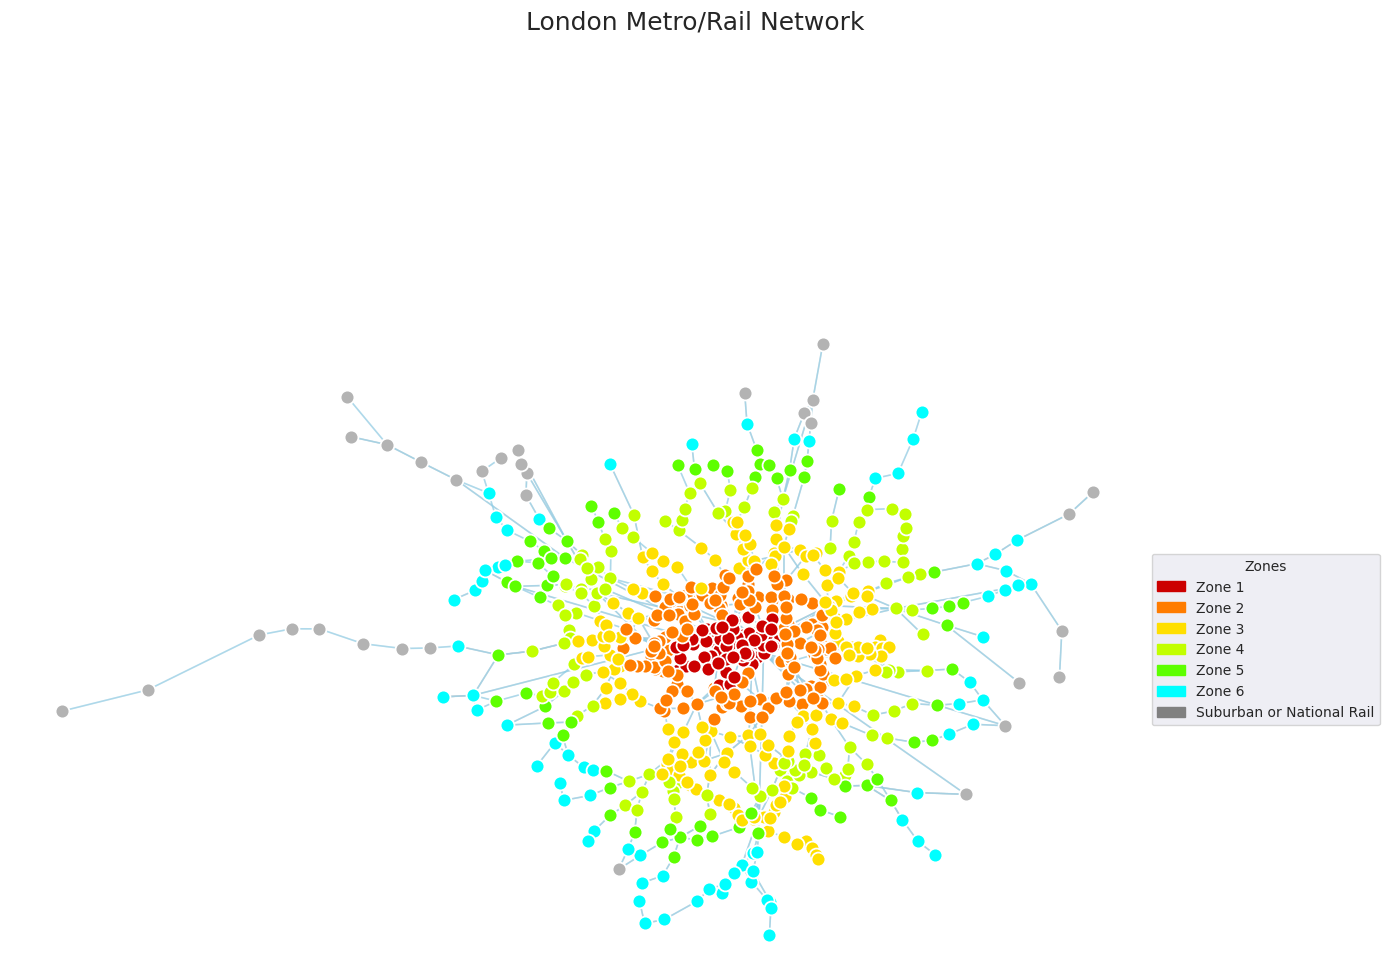

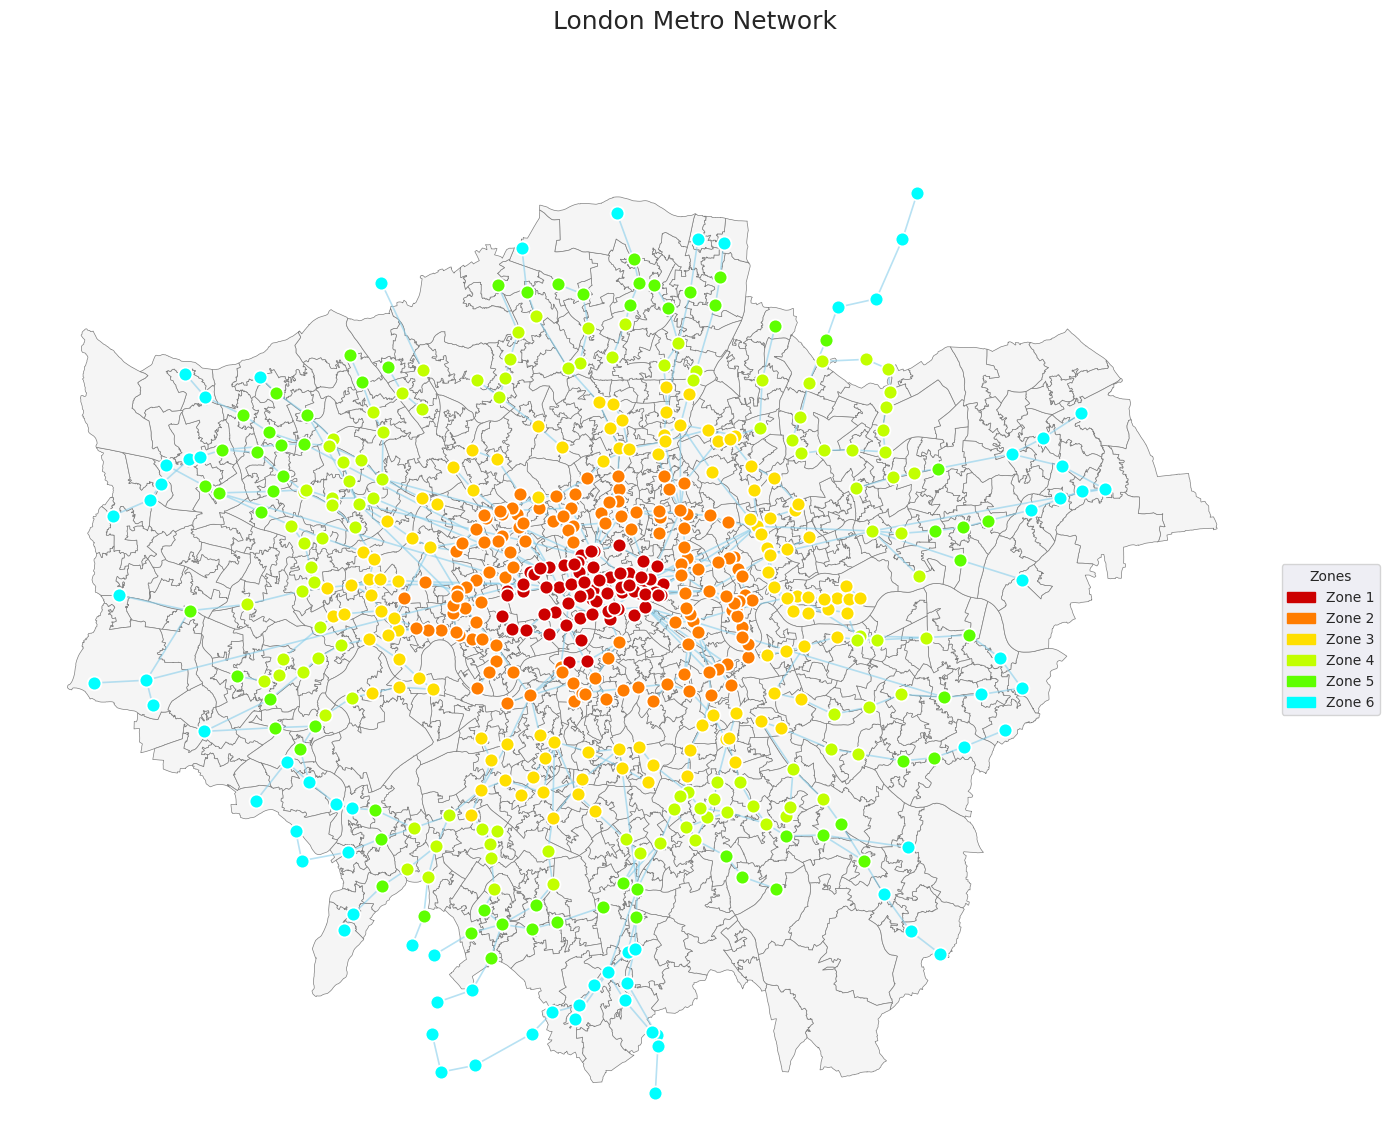

In [ ]:
if __name__ == '__main__':
  main()

In [ ]:
!wget -O LB_MSOA2021_shp.zip https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/LB_MSOA2021_shp.zip

--2025-07-04 18:09:29--  https://github.com/gabrielxcosta/PCC142---Data-Mining/raw/main/Project/LB_MSOA2021_shp.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/LB_MSOA2021_shp.zip [following]
--2025-07-04 18:09:29--  https://raw.githubusercontent.com/gabrielxcosta/PCC142---Data-Mining/main/Project/LB_MSOA2021_shp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960034 (8.5M) [application/zip]
Saving to: ‘LB_MSOA2021_shp.zip’

LB_MSOA2021_shp.zip 100%[===================>]   8.54M  --.-KB/s    in 0.05s   

2025-07-04 18:09:30 (187 MB/s) - ‘L